# Imports


In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import pickle
import itertools
import numpy as np
import random
from pandas.arrays import SparseArray


# Transformer


## getTrainingData


In [3]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,4)
print(I.shape,O.shape,S.shape)

(168, 41) (168, 41) (168,)


In [77]:
len(songStrings[0])

42

In [78]:
len("CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC")

42

In [109]:
len(I[140])

41

In [110]:
len(O[140])

41

In [74]:
I

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0.

In [97]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]


In [101]:
print(I[0].flatten(),O[0].flatten())
print(len(I[0].flatten()),len(O[0].flatten()))

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
41 41


In [90]:
print(len(O[0].flatten()))

41


In [5]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [6]:
I.shape

(168, 41)

In [7]:
I

array([[2, 2, 6, ..., 4, 3, 3],
       [2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       ...,
       [0, 5, 1, ..., 2, 1, 5],
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0]])

In [8]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [9]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())

print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
[6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2] [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
[5 1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4
 2 1 5 3] [1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0]
[1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0] [3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2 1
 5 3 0 5]


## Transformer Model


In [4]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        # adding noise to the store using torch random and then a variacnce // output.apply
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Test


In [5]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

## Train


In [ ]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        indices = torch.randperm(source.size(0))
        inputs_shuffled = source[indices]
        targets_shuffled = target[indices]
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = inputs_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        tgt = targets_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
        if  W[-1]>0.95:
            break    
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=4
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=10000)
plot(W)
model_name = 'Transformer'
transformer_model = model
torch.save(transformer_model, f'./SongModels/model_{model_name}_songs.model')


In [19]:
source,target,songs = getTrainingData(songStrings,4)
model.eval()  
x = test(model, source, target)
x

0.9551393728222997

In [8]:
torch.save(model, f'model_TF.model')

In [46]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'model_TF.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.7788908246225319

In [48]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'./dataModelsSongs/TF_22.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.9503484320557491

In [49]:
state_dict = torch.load(f'./dataCF/TF_1000_11.model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
      
model.to(device)  # Move the model to the appropriate device

model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)

In [42]:
model.eval()  
x = test(model, source, target)
x

0.7664053426248548

In [7]:
model.store[-1].shape

(168, 20)

In [8]:
source,target,songs=getTrainingData(songStrings,4)


In [ ]:
source.shape

(168, 41)

In [9]:
target.shape

(168, 41)

In [ ]:
songs.shape

(168,)

In [ ]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9700929152148664

## predict_next_token


In [7]:
def predict_next_token_TF(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]


In [ ]:
who=34
source[who]
predicted_token_index = predict_next_token_TF(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

In [11]:
    for i in range(len(songs)):
        print(i,songs[i])
        print("source",source[i])


0 0
source [2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3]
1 0
source [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
2 0
source [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
3 0
source [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
4 0
source [0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3
 2 2 2 6]
5 0
source [0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2
 2 2 6 6]
6 0
source [6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2
 2 6 6 0]
7 0
source [5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2
 6 6 0 0]
8 0
source [5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2 6
 6 0 0 6]
9 0
source [4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2 6 6
 0 0 6 5]
10 0
source [4 3 3 2 6 6 5 5 4 4 3 6 6 5

## shrinkingDecompositionInformation


In [8]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20, name= ""):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        if name == "TF":
            predicted_token_index = predict_next_token_TF(model, source[i])
        else:
            predicted_token_index = predict_next_token_RNNS(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(1)
        else:
            O.append(0)
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    #print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    #print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20, model_name= ""):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width, name=model_name)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(I*allO).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
        #print(f"I: {I}")
        #print(f"O: {O}")
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)



(20, 168)
(20, 168)
I: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
O: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
I: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

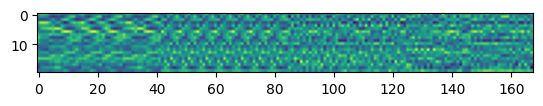

In [13]:
s,h=shrinkingDecompositionInformation(transformer_model,source,target,songs,numbers=list(range(4)),width=20)

In [14]:
M=removalIntoMatrix(s,20,h)

In [15]:
print(M.shape)

(4, 20)


0.8111417624295809 -0.004454685336307662


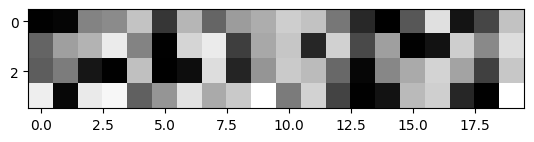

In [16]:
imshow(M,cmap="gray")
print(M.max(),M.min())

In [29]:
print(M.mean(),M.std())

0.4127551098296699 0.27312479520682564


In [30]:
print(songs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


(20, 168)
(20, 168)


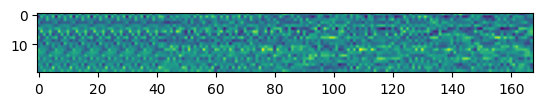

In [31]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [ ]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
model.state_dict().keys()
#model.state_dict().values()

odict_keys(['pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.1.linear2.weight', 'transformer_encode

In [ ]:
I.shape

(41, 8)

In [ ]:
O.shape

(41, 8)

# RNN models


## RNN


In [9]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x,verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = copy.deepcopy(self.h0.detach().numpy())
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## Attention layer


In [10]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNNA


In [11]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
        self.store = self.hidden.detach().numpy().copy()
        out = self.outputLayer(rnn_out)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


## LSTM


In [12]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


## LSTMA


In [13]:
class LSTMA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTMA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        out, self.h0 = self.lstmLayer(expanded_attn_out, self.h0)
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)  # Corrected line

        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    


## GRU


In [14]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.GRULayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## GRUA


In [15]:
class GRUA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRUA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp) 
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
    
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

    
                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)



## generateIOData on all songs at once with its corresponding combinations


Input shape: (42, 41, 8), Output (One-Hot) shape: (42, 41, 8), Output (Indices) shape: (42, 41), Song shape: (42,)


Text(0.5, 1.0, 'One Hot Label Input')

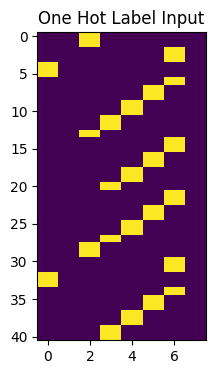

In [16]:
    songStrings = numpy.array([
        "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
        "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
        "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
        "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
        "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
        "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
        "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
        "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
        "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
        "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
        "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
        "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
        "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

    def generateIOData(nrOfSongs, songStrings):
        notes = list("ABCDEFGH")
        source = []
        target_one_hot = []
        target_indices = []
        songs = []  # Array to track the song index for each sequence

        for s in range(nrOfSongs):
            song_length = len(songStrings[s])
            for i in range(song_length):  # Adjust to iterate correctly
                input_one_hot = np.zeros((41, 8))
                current_target_one_hot = np.zeros((41, 8))
                current_target_indices = np.zeros(41, dtype=int)

                for j in range(41):
                    note_index = notes.index(songStrings[s][(i+j) % song_length])
                    next_note_index = notes.index(songStrings[s][(i+j+1) % song_length])

                    input_one_hot[j, note_index] = 1
                    current_target_one_hot[j, next_note_index] = 1
                    current_target_indices[j] = next_note_index

                source.append(input_one_hot)
                target_one_hot.append(current_target_one_hot)
                target_indices.append(current_target_indices)
                songs.append(s)  # Append the song index

        return np.array(source), np.array(target_one_hot), np.array(target_indices), np.array(songs)


I, O_hot, O_indices, songs = generateIOData(1, songStrings)
print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {O_indices.shape}, Song shape: {songs.shape}")

# Display the first input and output for visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
who = 0
plt.imshow(I[who], aspect='auto')
plt.title("One Hot Label Input")



In [ ]:
    I, O_hot, O_indices, songs = generateIOData(4, songStrings)


In [20]:
print(I[0])


[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 

In [4]:
O_indices


array([[2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       [6, 0, 0, ..., 2, 2, 2],
       ...,
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0],
       [3, 1, 2, ..., 3, 0, 5]])

(41, 8)
(41, 8)


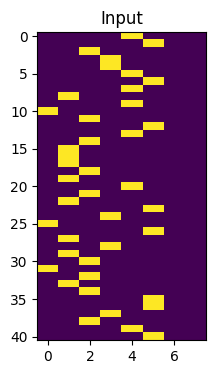

In [103]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
who = 140
plt.imshow(I[who], aspect='auto')
plt.title("Input")
print(I[who].shape)
print(O_hot[who].shape)



In [107]:
len(I[who])

41

In [40]:
songs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Train Rnns on all songs at once with its corresponding combinations


In [66]:
def train_model(model, num_epochs, songStrings, number_of_Songs):
    L = []  # Losses
    A = []  # Accuracies
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-3)
    
    # Assuming generateIOData has been adjusted to take only songStrings
    I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
    #print(f"Input shape: {I.shape}, Output (Indices) shape: {O_indices.shape}")
    # Convert the dataset to tensors
    inputs = torch.tensor(I, dtype=torch.float)
    targets = torch.tensor(O_indices, dtype=torch.long)

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch
        
        # Shuffle dataset
        indices = torch.randperm(inputs.size(0))
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        
        # Assuming the model expects inputs of shape [seq_len, batch, feature]
        src = inputs_shuffled
        tgt = targets_shuffled
        #print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
        # Forward pass
        outputs = model(src)
        output_flat = outputs.view(-1, outputs.shape[-1])  # Flatten output for CrossEntropyLoss
        loss = criterion(output_flat, tgt.view(-1))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()

        # Calculate accuracy
        _, predicted_indices = torch.max(output_flat, 1)
        #print(f'predicted { predicted_indices}')
        #print(f'target {tgt.view(-1)}')
        correct_predictions = (predicted_indices == tgt.view(-1)).sum().item()
        total_accuracy = correct_predictions / tgt.numel()
        
        # Log the loss and accuracy
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {total_accuracy:.4f}')
        
        L.append(total_loss)
        A.append(total_accuracy)

        # Early stopping criteria (optional)
        if total_accuracy >= 0.95:
            print("Early stopping criteria met")
            break

    return L, A

In [90]:
model = RNN()
num_epochs = 5000
number_of_Songs = 4
L, A  = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

168
tensor([124,  25,  34, 137,  27, 110,  13,  29, 128,  51,  12,  48,  69,  62,
        120,   1, 165,  20,  11, 164, 102, 142,  53,  81,  89, 125,  75,  30,
         55,  67, 158,  88,   6,  50,  24, 116,  14, 112,  17, 152,  56,  61,
         18, 100, 150, 156,  58, 151, 146,  74,  46,  47,  83,  21,  19, 154,
         66, 132, 123, 153,  65,  71, 133,  32,  63,  59,  79, 126, 136,  31,
        131, 140,  97, 111,  73, 119,  86,  43,  38, 134,   4, 105, 114,  39,
         77,  99,  94, 160, 103,  98, 143,  35,  44, 149,  54, 148,   9, 147,
          0,  10,  72,   3, 141, 162, 108,  80,  41, 127, 118,  92,  52,  42,
        163, 113, 121,  84, 107,  60,   7, 135,  78,   2,  33, 161, 155,  95,
        101, 117, 106, 139,  28, 159, 144,  70, 122, 167,  16,  76,  23,  40,
         91,  22,  93,  90,   5, 130,  64, 115,  26,  15, 104,  68,  49,  57,
        166,  96,  82, 129, 157,  87, 145,  37, 109,  45,  85, 138,   8,  36])
Epoch 1, Loss: 2.0729, Accuracy: 0.0994
168
tensor([  1,  4

KeyboardInterrupt: 

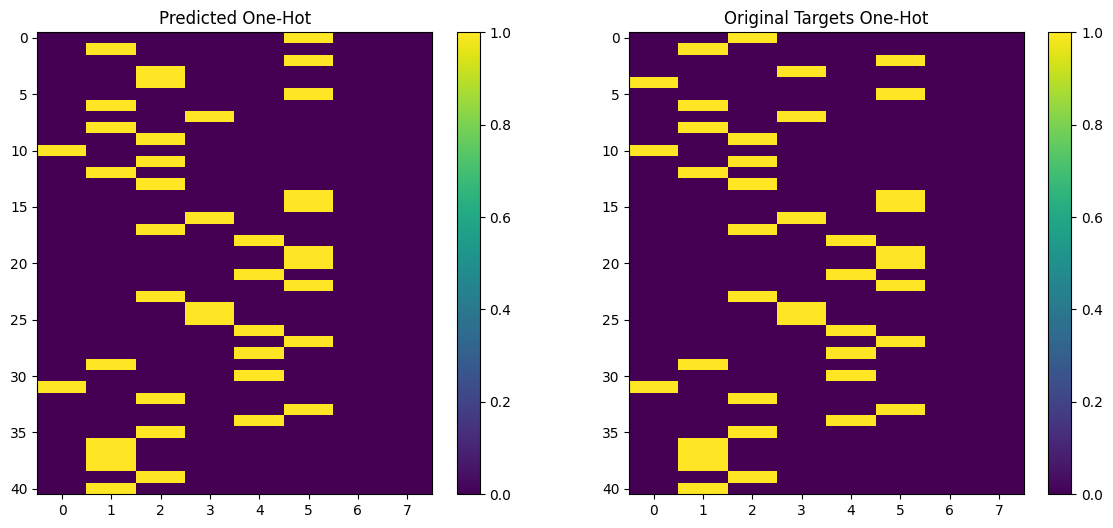

In [44]:
I, O, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset

inputs = torch.Tensor(I)
outputs = model(inputs)

_, predicted_indices = torch.max(outputs, 2)

num_classes = 8 

predicted_one_hot = F.one_hot(predicted_indices.squeeze(), num_classes=num_classes).numpy()


O_tensor = torch.tensor(O_indices, dtype=torch.long)
original_one_hot = F.one_hot(O_tensor, num_classes=num_classes).numpy()


plt.figure(figsize=(14, 6))
who = 160
# Plotting one-hot encoded predicted indices
plt.subplot(1, 2, 1)
plt.imshow(predicted_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Predicted One-Hot')

# Plotting one-hot encoded original targets
plt.subplot(1, 2, 2)
plt.imshow(original_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Original Targets One-Hot')

plt.show()

In [17]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}

In [13]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
number_of_Songs = 4
num_epochs = 10000
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L , A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    torch.save(model, f'./SongModels/model_{model_name}_songs.model')


Training RNN...
Epoch 1, Loss: 2.1002, Accuracy: 0.1720
Epoch 101, Loss: 1.7311, Accuracy: 0.3924
Epoch 201, Loss: 1.2693, Accuracy: 0.5129
Epoch 301, Loss: 0.9028, Accuracy: 0.7101
Epoch 401, Loss: 0.6484, Accuracy: 0.7933
Epoch 501, Loss: 0.4826, Accuracy: 0.8776
Epoch 601, Loss: 0.3768, Accuracy: 0.9138
Epoch 701, Loss: 0.3066, Accuracy: 0.9370
Epoch 801, Loss: 0.2624, Accuracy: 0.9464
Epoch 901, Loss: 0.2330, Accuracy: 0.9474
Early stopping criteria met
Training RNNA...
Epoch 1, Loss: 2.0826, Accuracy: 0.1607
Epoch 101, Loss: 1.9103, Accuracy: 0.1826
Epoch 201, Loss: 1.7912, Accuracy: 0.2207
Epoch 301, Loss: 1.6227, Accuracy: 0.3410
Epoch 401, Loss: 1.3642, Accuracy: 0.4834
Epoch 501, Loss: 1.1992, Accuracy: 0.5510
Epoch 601, Loss: 0.9910, Accuracy: 0.6648
Epoch 701, Loss: 0.8747, Accuracy: 0.6792
Epoch 801, Loss: 0.7817, Accuracy: 0.6973
Epoch 901, Loss: 0.6836, Accuracy: 0.7589
Epoch 1001, Loss: 0.5909, Accuracy: 0.7983
Epoch 1101, Loss: 0.5153, Accuracy: 0.8230
Epoch 1201, Loss:

In [16]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Number of Epoch: {len(metrics['Accuracy'])}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")


NameError: name 'results' is not defined

In [15]:
model.store[-1].shape

(168, 20)

In [106]:
I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
I.shape

(168, 41, 8)

## predict_next_token


In [17]:
def predict_next_token_RNNS(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    inputs = torch.Tensor([token_indices])
    outputs = model(inputs)

    with torch.no_grad():
        outputs = model(inputs)

    _, predicted_indices = torch.max(outputs, 2)
    #print(predicted_indices)

    
    #last_token_logits = output[-1, 0, :]  # Get logits for the last token
    #predicted_token_index =   # Find the index of the max log-probability
    predicted_token_index = predicted_indices[0, -1].item()  # Get the last item as a Python int

    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]



In [ ]:
who=88
I[who]
#print(I[who])
print(O_indices[who])
predicted_token_index = predict_next_token_RNNS(model, I[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(f"original target {O_indices[who][-1]}")

In [54]:
O_indices[who]

array([6, 6, 5, 5, 4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2,
       2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4])

tensor([2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5,
        5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3])
tensor([2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2])
tensor([2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2])
tensor([2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2])
tensor([0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2])
tensor([0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2])
tensor([2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0])
tensor([5, 5, 4, 4, 

tensor([5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2])
tensor([4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5])
tensor([4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5])
tensor([3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4])
tensor([3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4])
tensor([2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3])
tensor([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
        0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4])
tensor([1, 2, 3, 4, 

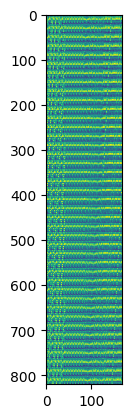

In [55]:
source, O_hot, target, songs = generateIOData(4, songStrings)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(4)),width=20)

In [56]:
M=removalIntoMatrix(s,20,h)

0.00856853999610463 -0.007828062947824677


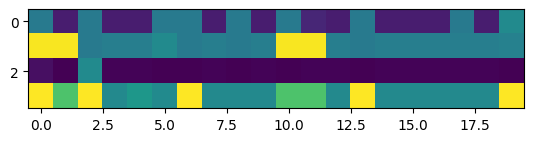

In [57]:
imshow(M)
print(M.max(),M.min())

# plot M


In [48]:
target

array([[2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       [6, 0, 0, ..., 2, 2, 2],
       ...,
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0],
       [3, 1, 2, ..., 3, 0, 5]])

tensor([[3, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5,
         4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2]])
tensor([[3, 6, 5, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4,
         4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2]])
tensor([[6, 5, 3, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4,
         3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2]])
tensor([[6, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3,
         2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6]])
tensor([[1, 1, 6, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2,
         2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6]])
tensor([[1, 5, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2,
         6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0]])
tensor([[6, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2, 6,
         6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0, 0]])

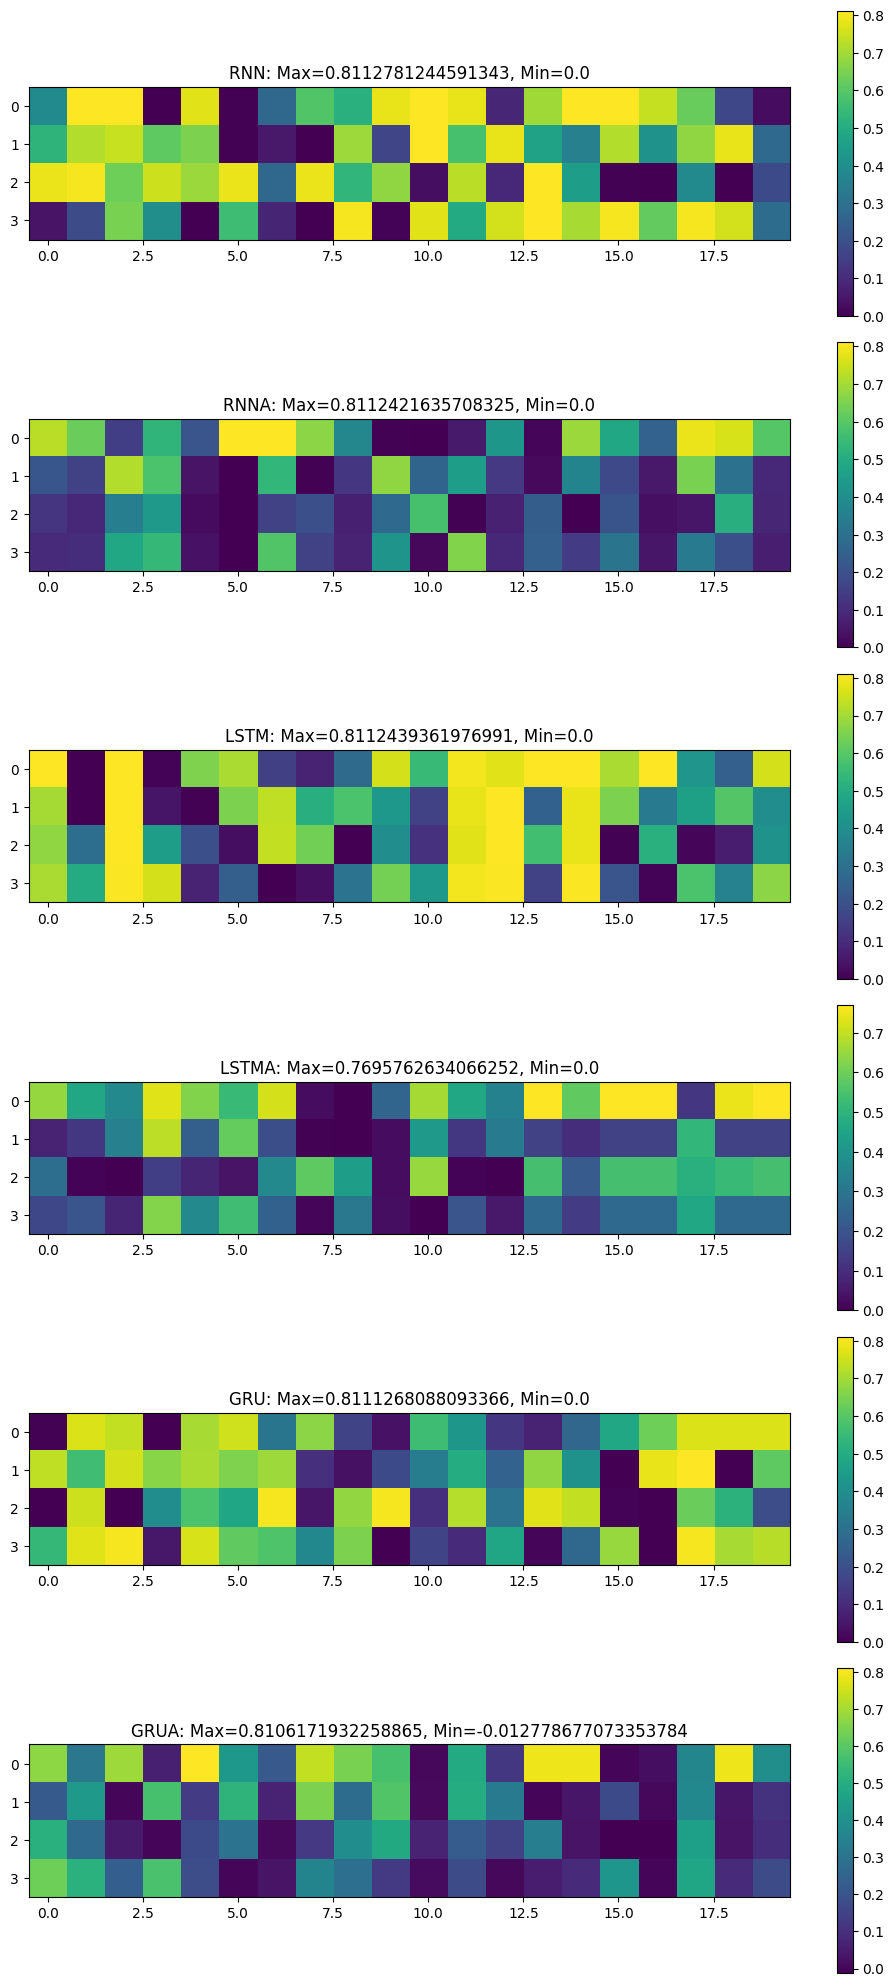

In [30]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA(),
}
source, O_hot, target, songs = generateIOData(4, songStrings)
fig, axs = plt.subplots(len(models), 1, figsize=(10, 20))

# For each model, process the data and plot the resulting matrix
for i, (model_name, model) in enumerate(models.items()):
    model = torch.load(f'./SongModels/model_{model_name}_songs.model')
    model.eval()  # Set the model to evaluation mode if you're doing inference

    s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20)
    M = removalIntoMatrix(s, 20, h)
    
    ax = axs[i]
    cax = ax.imshow(M)
    fig.colorbar(cax, ax=ax)
    ax.set_title(f"{model_name}: Max={M.max()}, Min={M.min()}")

plt.tight_layout()
plt.show()


In [ ]:
M

array([[-0.01394116,  0.        , -0.01394116, -0.01021922, -0.01394116,
        -0.01394116, -0.01394116, -0.01394116, -0.01394116, -0.01021922,
        -0.01394116, -0.01021922, -0.01394116, -0.01021922, -0.01021922,
        -0.01021922, -0.01394116, -0.01394116, -0.01394116, -0.01394116],
       [-0.02607095, -0.02607095, -0.02607095, -0.02526978, -0.02607095,
        -0.02607095, -0.02607095, -0.02607095,  0.        , -0.02526978,
        -0.02607095, -0.02526978, -0.02607095, -0.02526978, -0.02526978,
        -0.02526978, -0.02607095, -0.02607095, -0.02607095, -0.02607095],
       [-0.02395571, -0.02395571,  0.        , -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.01398283, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571],
       [ 0.01873013,  0.        ,  0.        ,  0.02300939,  0.01873013,
         0.01873013,  0.01873013,  0.01873013,  

# Calculations

In [18]:
def kmeans_thresholding(matrix, random_state=42):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering with a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=random_state).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()

    # Check if there are two centroids (clusters) and handle accordingly
    if len(centroids) > 1:
        # Determine threshold - you may choose a different method here
        threshold = np.mean(centroids)
    else:
        # If only one centroid (unlikely, but possible), use it as the threshold
        threshold = centroids[0]

    # Count the number of elements exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding



In [19]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [20]:
def calculate_degrees_of_overlap(matrix):
    # Assuming 'matrix' is a NumPy array of shape (4, 20)
    degree_2, degree_3, degree_4 = 0, 0, 0

    # Transpose is not necessary as we want to work column-wise
    for col in range(matrix.shape[1]):  # Iterate through each column
        count_ones = np.sum(matrix[:, col] == 1)  # Count the number of ones in the current column
        if count_ones == 2:
            degree_2 += 1
        elif count_ones == 3:
            degree_3 += 1
        elif count_ones == 4:
            degree_4 += 1

    return degree_2, degree_3, degree_4



In [23]:
M

array([[-0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.00704346, -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 ,  0.        , -0.01311215, -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ],
       [-0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,  0.        ,
        -0.03196544, -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.06142105, -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ],
       [-0.07864014, -0.02409398, -0.07864014, -0.07864014, -0.07864014,
        -0.07864014,  0.        , -0.07864014, -0.07864014, -0.07864014,
        -0.07864014, -0.07149082, -0.06206952, -0.07864014, -0.07864014,
        -0.07864014, -0.07864014, -0.07864014, -0.07864014, -0.07864014],
       [-0.00091821,  0.        , -0.00091821, -0.00091821,  0.00167111,
        -0.00091821,  0.00167111, -0.00091821, -

In [36]:
results = []
           
# Calculate metrics
sum_abs = np.sum(np.abs(M))
mean = np.mean(M)
std = np.std(M)
max_val = np.max(M)
min_val = np.min(M)

threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)
count_exceeding_song_1_sum = np.sum(M[0] > threshold_song_1) # or use count_exceeding_song_1
count_exceeding_song_2_sum = np.sum(M[1] > threshold_song_2) # or use count_exceeding_song_2
count_exceeding_song_3_sum = np.sum(M[2] > threshold_song_3) # or use count_exceeding_song_3
count_exceeding_song_4_sum = np.sum(M[3] > threshold_song_4) # or use count_exceeding_song_4
# Vertically stack binarized_matrix_A and binarized_matrix_B
binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

min_values = np.min(binarized_combined_matrix, axis=0)

# Clip these values between 0 and 1
clipped_min_values = np.clip(min_values, 0, 1)

# Sum the clipped values
sum_clipped_min_values = np.sum(clipped_min_values) # fixed this







In [38]:
threshold_song_1, count_exceeding_song_1 ,binarized_count_exceeding_song_1,threshold_song_1

(-0.016566616639408976, 3, 3, -0.016566616639408976)

In [39]:
binarized_combined_matrix

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]])

In [40]:
degree_2, degree_3, degree_4

(2, 2, 0)

# Accuracy plots


In [68]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        x = data + [pad_value] * (target_length - len(data))
        return x[:target_length]
    
    
    
def read_and_process_csv(filename, target_epoch, process_func, skip_condition=None):
    try:
        data = pd.read_csv(filename)
        data['accuracy'] = data['accuracy'].apply(process_func)

        if skip_condition and skip_condition(data):
            return None, True

        padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
        return padded_data, False
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None, False

def skip_condition(data):
    return len(data) >= 2000 and data['accuracy'].max() < 0.97


# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):  
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


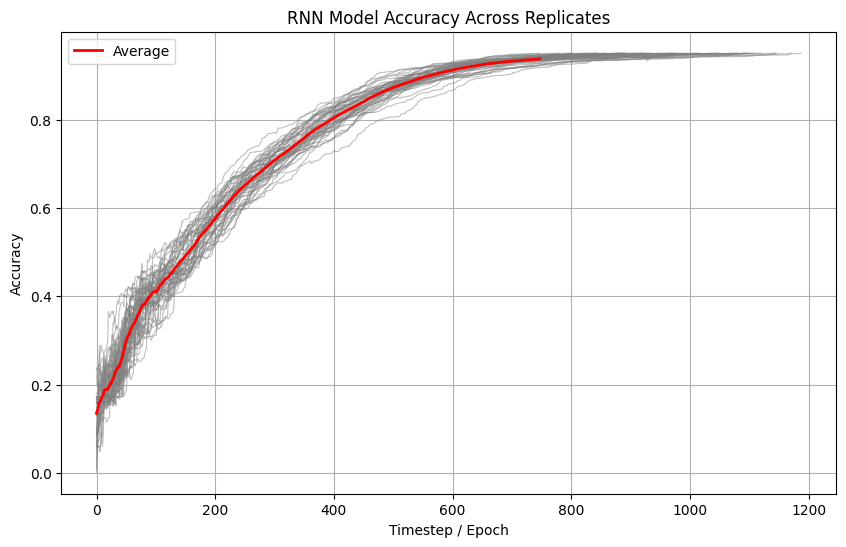

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


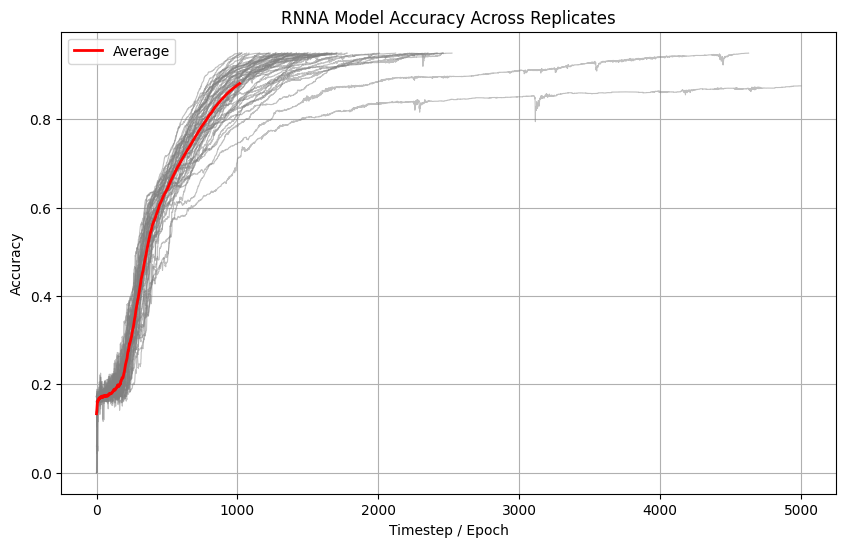

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


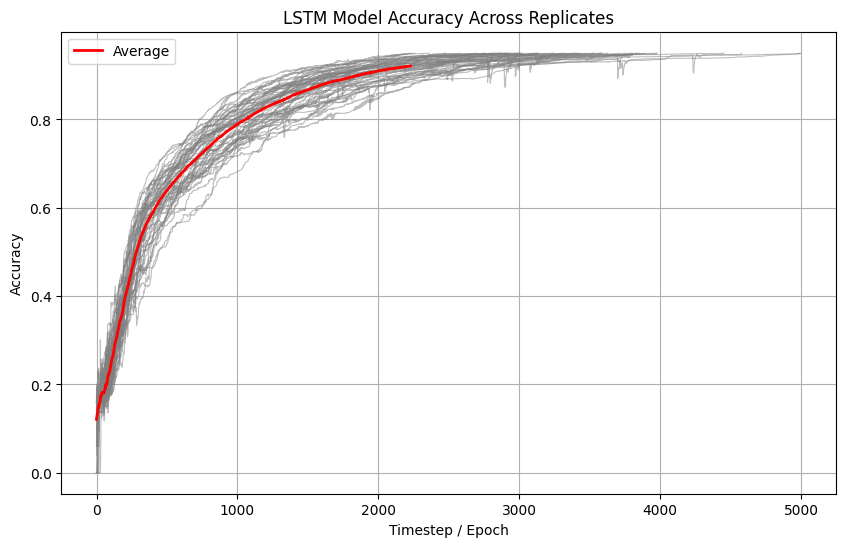

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


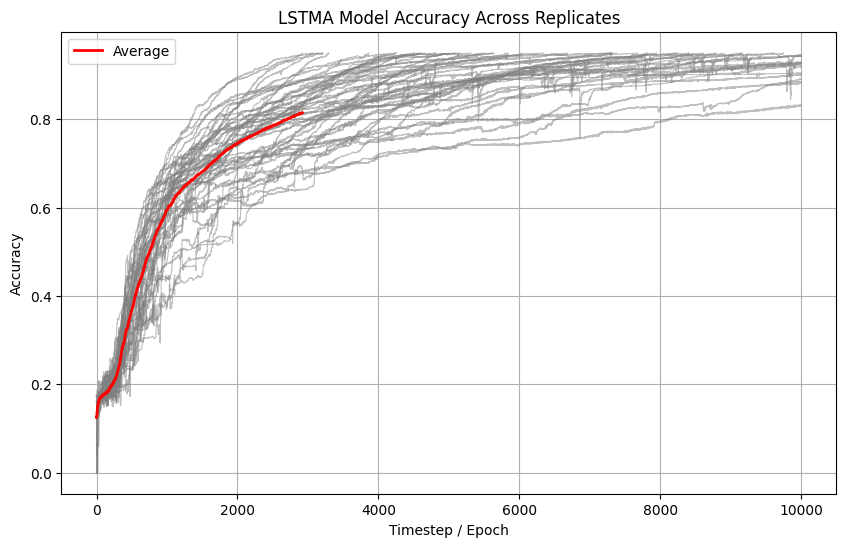

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


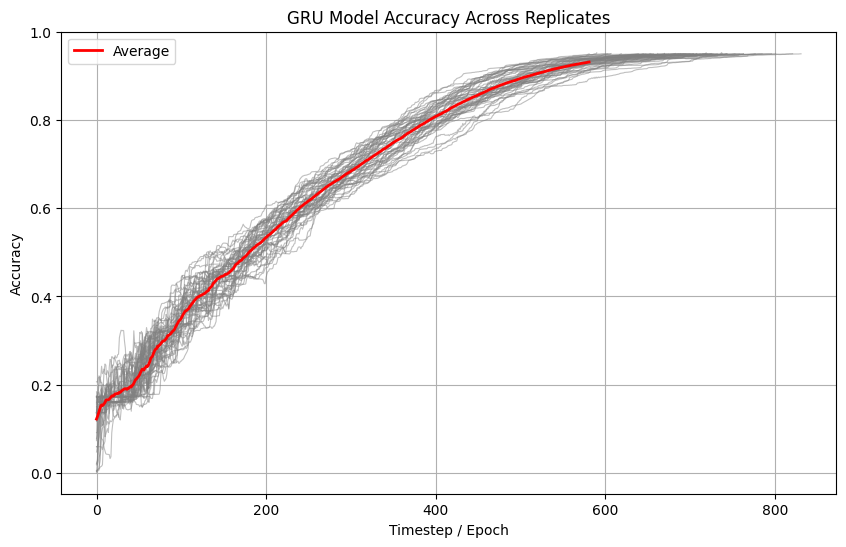

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


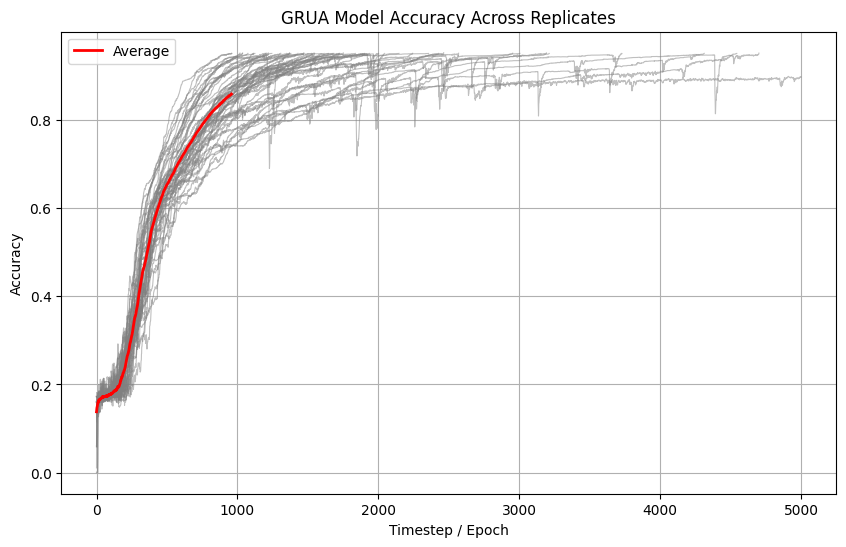

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_2133/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


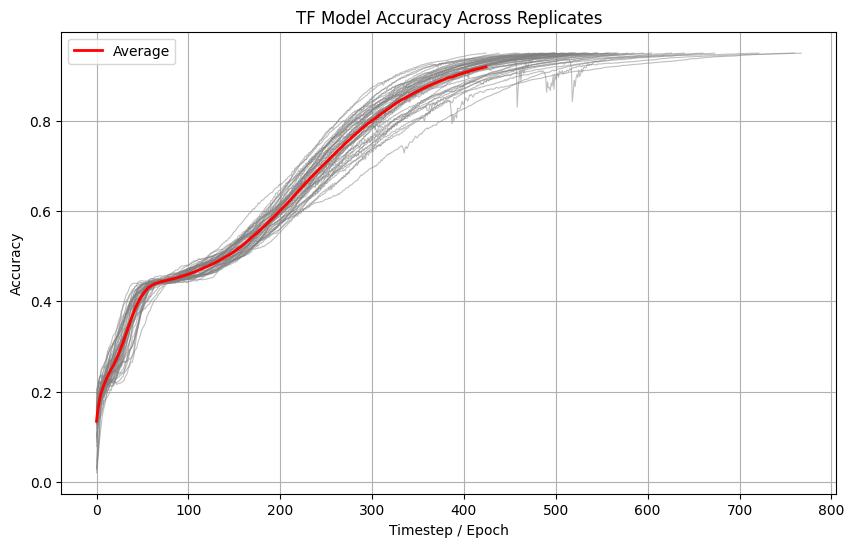

<Figure size 640x480 with 0 Axes>

In [22]:
#kinds = ["TF"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA", "TF"]
num_reps = 50
base_path = './dataAcc'  # Assuming the files are in the 'dataAcc' directory

# Plotting for each kind
for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            # Load the CSV file
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue

    # Calculating the average accuracy across all replicates at each timestep
    avg_data = np.mean(np.array(rep_data), axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))
    for data in rep_data:
        plt.plot(data, alpha=0.5, linewidth=0.8, color='gray', label='_nolegend_')
    plt.plot(avg_data, label="Average", linewidth=2, color='red')
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.tight_layout()


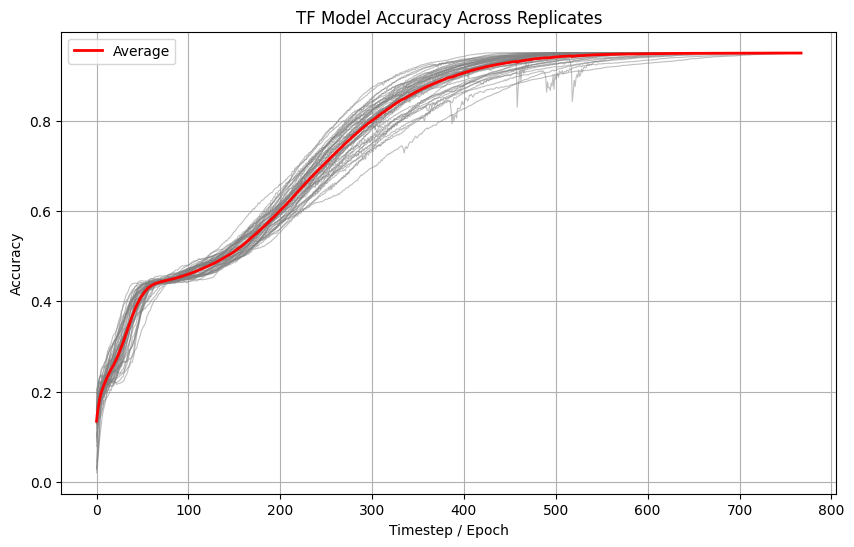

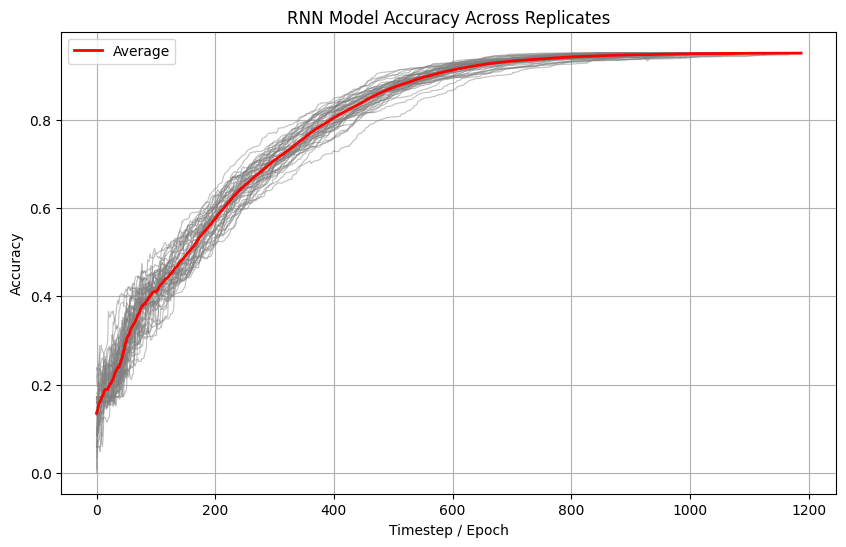

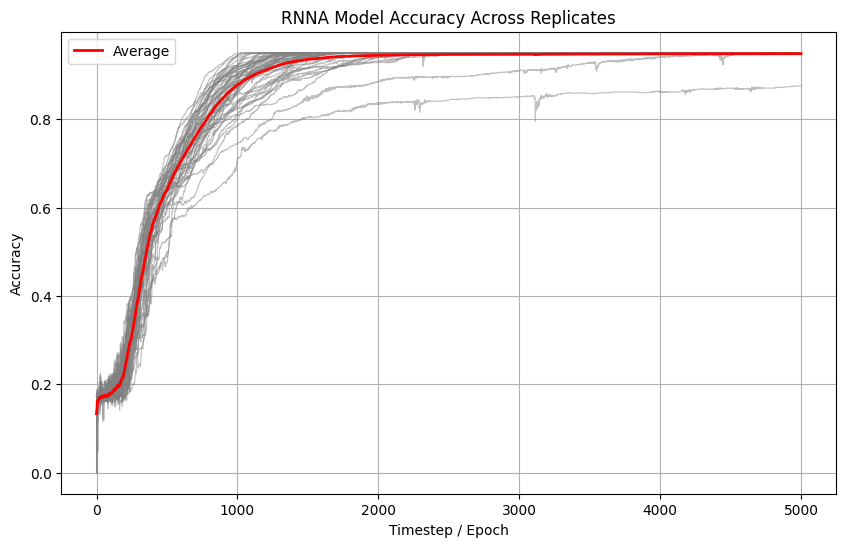

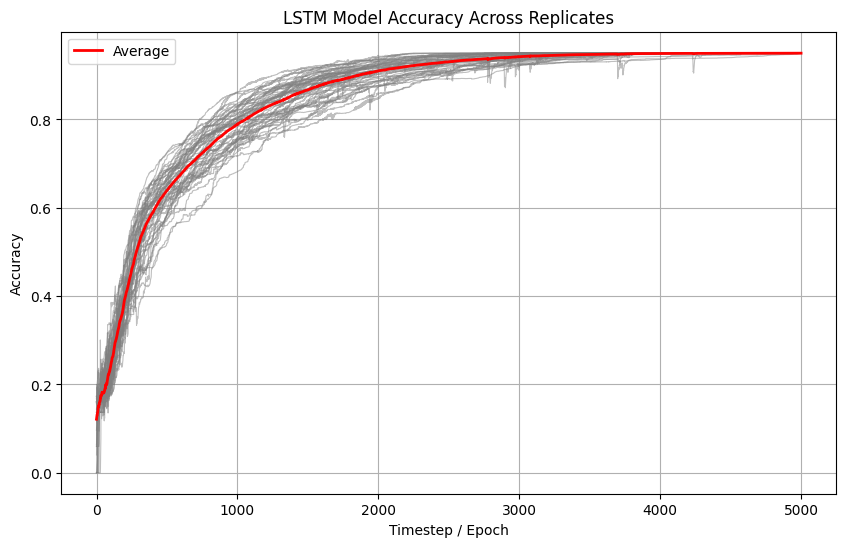

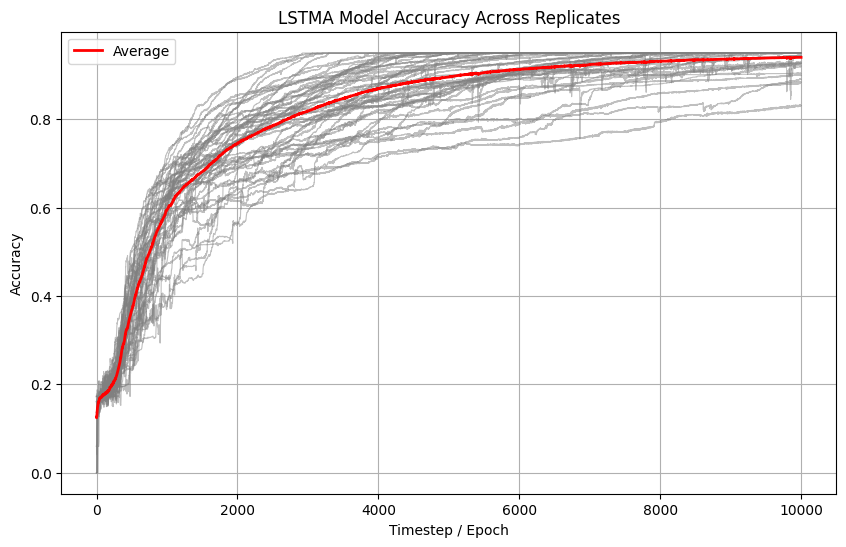

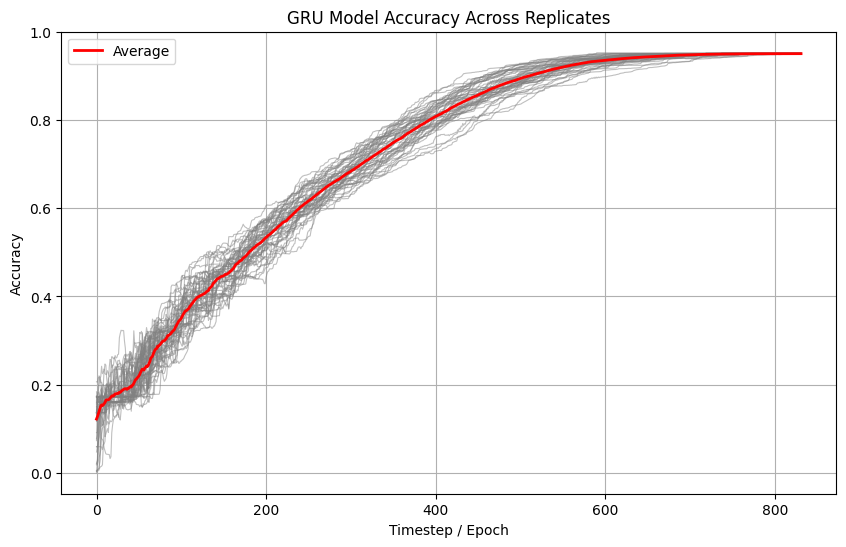

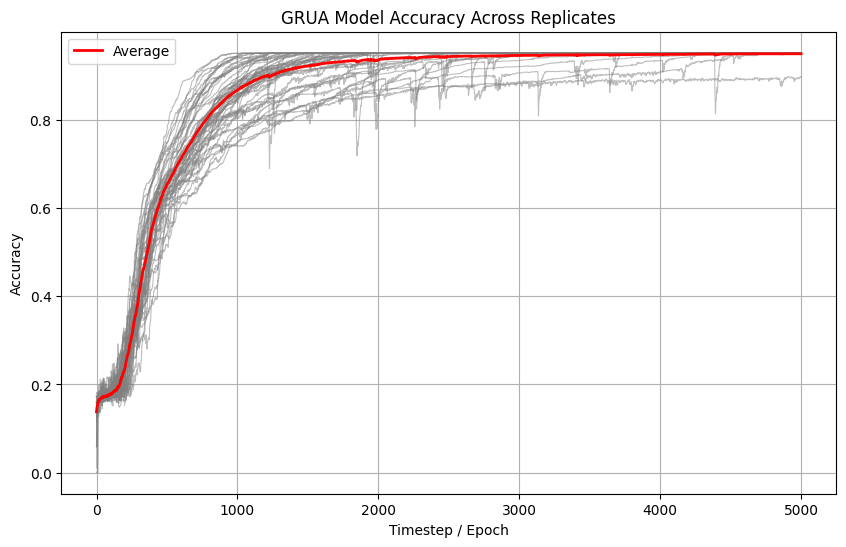

<Figure size 640x480 with 0 Axes>

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Updated base path to use the provided storage

# Initialize a dictionary to hold the padded data for plotting
padded_rep_data_dict = {}

for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    max_length = 0  # To find the maximum length of rows among all files
    
    # First pass: find the max length and collect data
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
            max_length = max(max_length, len(data))  # Update the max_length if current data is longer
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue
    
    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    # Second pass: pad data to max_length
    padded_rep_data = []
    for data in rep_data:
        last_value = data.iloc[-1]  # Get the last value to use for padding
        padded_data = np.pad(data, (0, max_length - len(data)), 'constant', constant_values=(last_value))
        padded_rep_data.append(padded_data)
    
    padded_rep_data_dict[kind] = padded_rep_data  # Store the padded data for plotting

# Now plotting for each kind with padded data
for kind, padded_rep_data in padded_rep_data_dict.items():
    # Calculating the average accuracy across all replicates at each timestep
    avg_data = np.mean(np.array(padded_rep_data), axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))
    for data in padded_rep_data:
        plt.plot(data, alpha=0.5, linewidth=0.8, color='gray', label='_nolegend_')
    plt.plot(avg_data, label="Average", linewidth=2, color='red')
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.tight_layout()


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Specify your data directory

# Identify the maximum length across all files
overall_max_length = 0
for kind in kinds:
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            overall_max_length = max(overall_max_length, len(data))
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

# Initialize dictionaries for storing padded data and average accuracy
padded_rep_data_dict = {}
average_accuracy_dict = {}

for kind in kinds:
    rep_data = []
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            # Use last value for padding or 0 if data is empty
            last_value = data.iloc[-1] if not data.empty else 0
            padded_data = np.pad(data, (0, overall_max_length - len(data)), 'constant', constant_values=(last_value))
            rep_data.append(padded_data)
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    padded_rep_data_dict[kind] = rep_data  # Store the padded data
    average_accuracy_dict[kind] = np.mean(np.array(rep_data), axis=0)  # Calculate and store the average accuracy



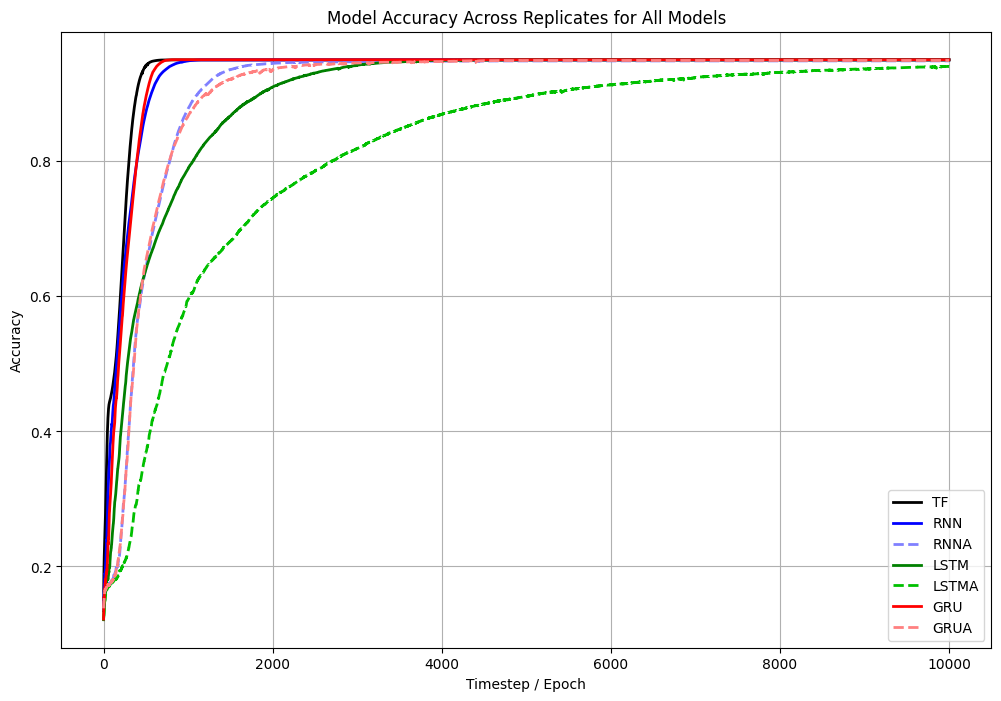

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'average_accuracy_dict' contains your data
kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]

# Manually select base colors for each model type
base_colors = {
    "TF": "black",
    "RNN": "blue",
    "LSTM": "green",
    "GRU": "red"
}

# Helper function to adjust color lightness
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color.
    :param color: A matplotlib color string, tuple, or list.
    :param amount: The amount to adjust the lightness (0.5 = same, <0.5 = darker, >0.5 = lighter).
    :return: Adjusted color.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Plotting the averages for all models/kinds in one plot with specific line styles and colors
plt.figure(figsize=(12, 8))

for kind in kinds:
    avg_data = average_accuracy_dict[kind]
    
    # Determine if this model is an augmented version and adjust color accordingly
    if kind in base_colors:  # Base model
        color = base_colors[kind]
        linestyle = '-'
    else:  # Augmented model, adjust the color to be lighter
        base_model = kind[:-1]  # Remove the "A" to get the base model
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    
    plt.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)

# Configuring the plot
plt.title("Model Accuracy Across Replicates for All Models")
plt.xlabel("Timestep / Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


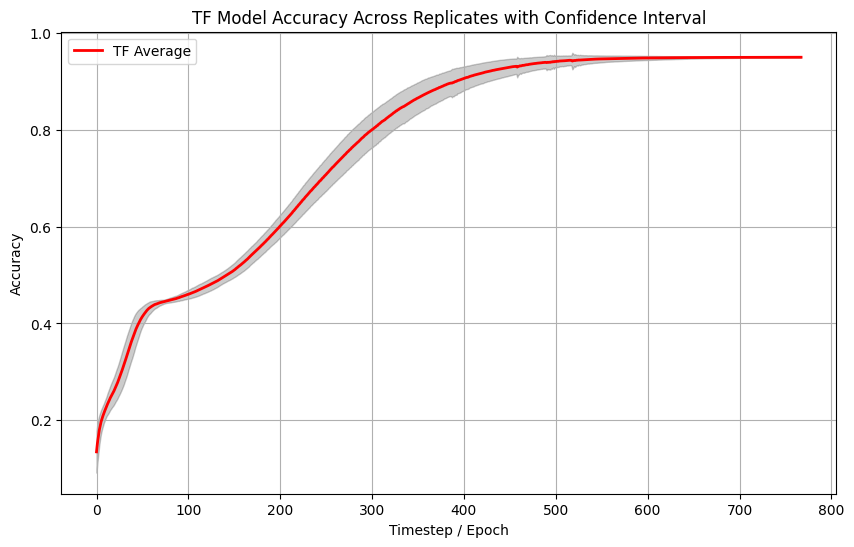

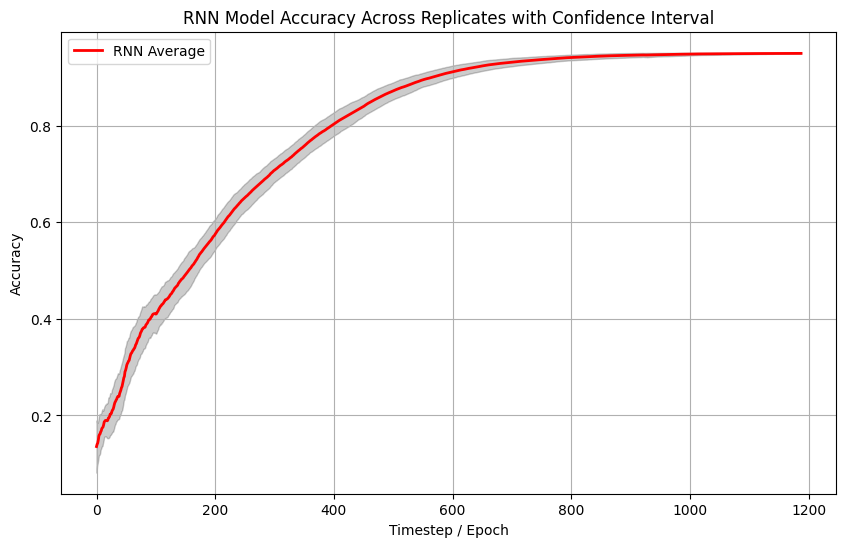

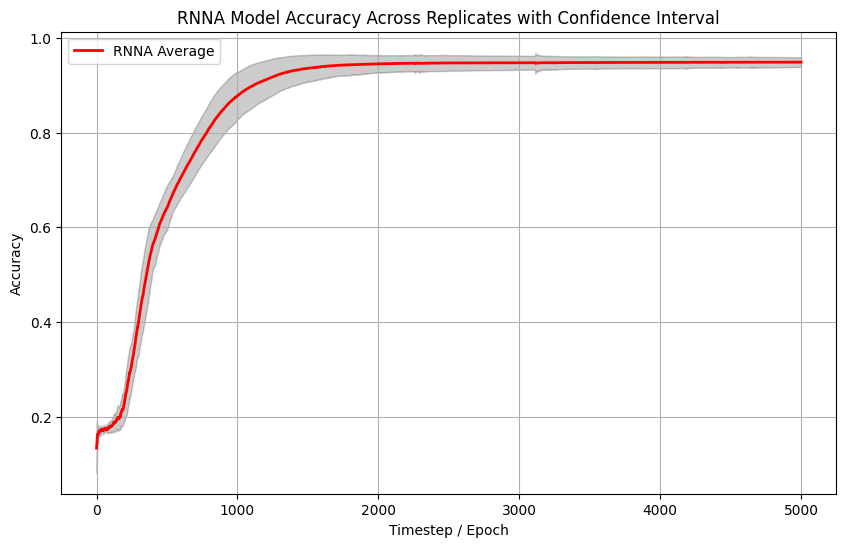

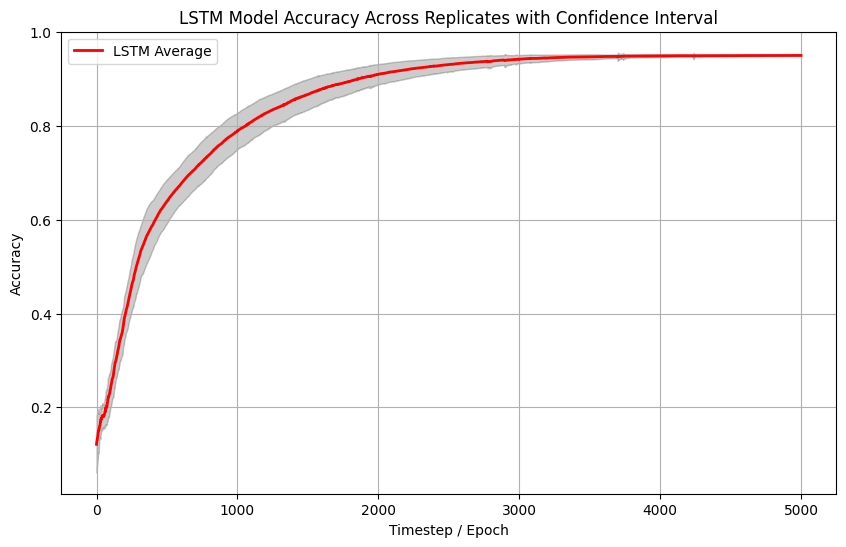

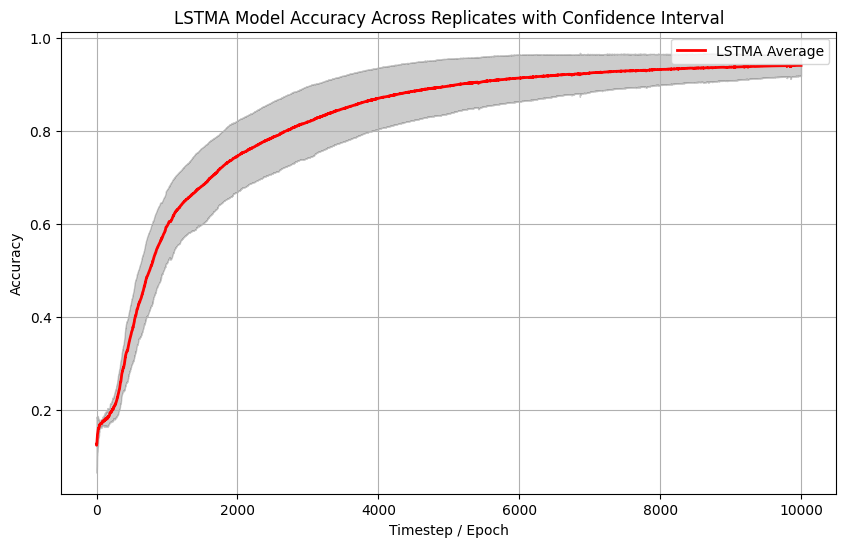

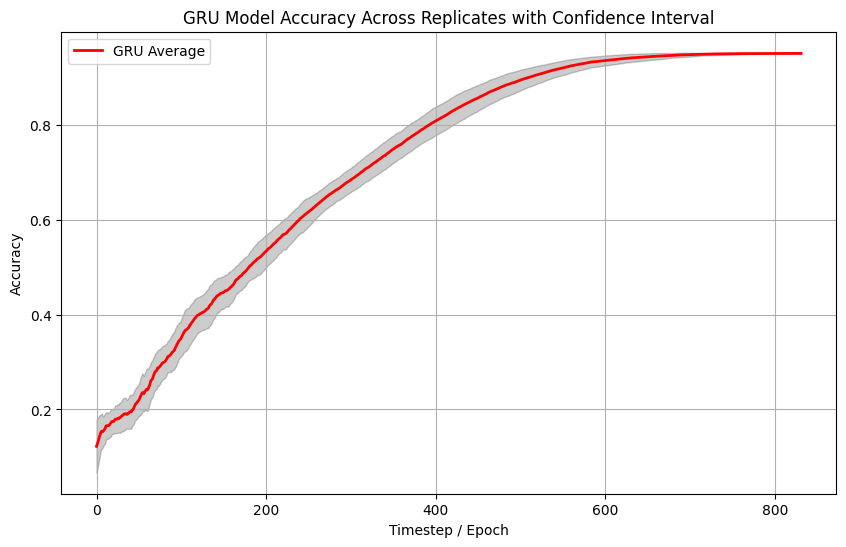

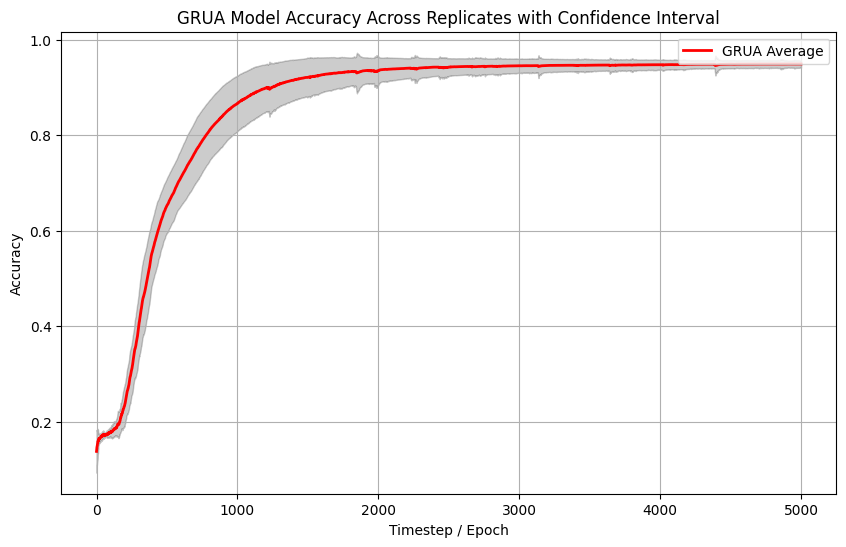

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the kinds of models and the number of replicates
kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Adjust this to your actual directory

# Initialize a dictionary to hold the padded data for plotting
padded_rep_data_dict = {}

for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    max_length = 0  # To find the maximum length of rows among all files
    
    # First pass: find the max length and collect data
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
            max_length = max(max_length, len(data))  # Update the max_length if current data is longer
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue
    
    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    # Second pass: pad data to max_length
    padded_rep_data = []
    for data in rep_data:
        last_value = data.iloc[-1]  # Get the last value to use for padding
        padded_data = np.pad(data, (0, max_length - len(data)), 'constant', constant_values=(last_value))
        padded_rep_data.append(padded_data)
    
    padded_rep_data_dict[kind] = padded_rep_data  # Store the padded data for plotting

# Plotting for each kind with padded data and confidence intervals
for kind, padded_rep_data in padded_rep_data_dict.items():
    # Convert to NumPy array for easier manipulation
    data_array = np.array(padded_rep_data)
    
    # Calculating the mean and standard deviation across all replicates at each timestep
    mean_data = np.mean(data_array, axis=0)
    std_data = np.std(data_array, axis=0)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_data, label=f"{kind} Average", linewidth=2, color='red')
    
    # Adding the confidence interval as a shaded area
    plt.fill_between(range(len(mean_data)), mean_data - std_data, mean_data + std_data, color='black', alpha=0.2)
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates with Confidence Interval")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


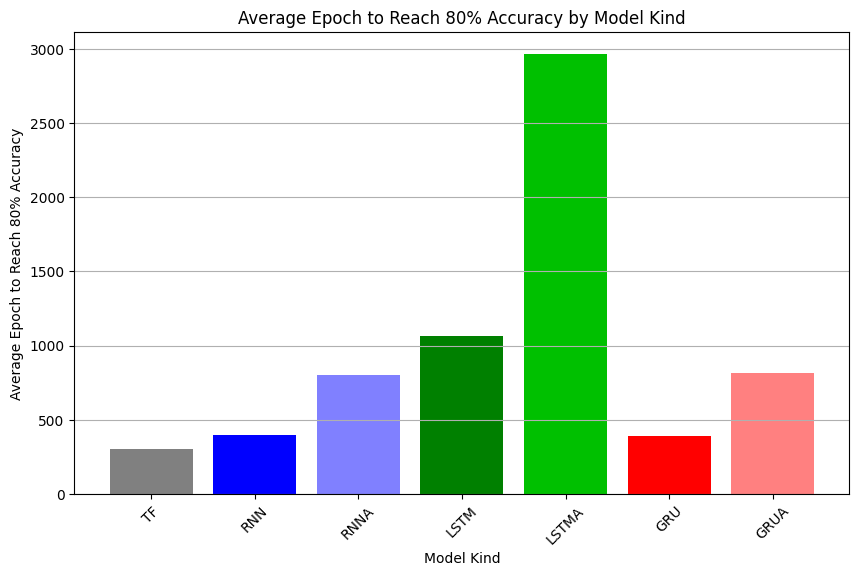

In [49]:
import matplotlib.pyplot as plt
import numpy as np


average_epochs_to_80 = {}

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        # Find the index (epoch) where accuracy reaches or exceeds 80%
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:  # If at least one epoch meets the criterion
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        # Calculate the average epoch across replicates for the current kind
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
    else:
        average_epochs_to_80[kind] = None  # No replicates reached 80% accuracy

# Assuming 'average_epochs_to_80' is your calculated dictionary
kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]

# Manually select base colors for each model type
base_colors = {
    "TF": "gray",
    "RNN": "blue",
    "LSTM": "green",
    "GRU": "red"
}

# Function to adjust color lightness (same as previously described)
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Assign colors to each kind, adjusting for augmented models
colors = []
for kind in kinds:
    if kind in base_colors:  # Base model
        colors.append(base_colors[kind])
    else:  # Augmented model, make the color lighter
        base_model = kind[:-1]  # Remove the "A" to get the base model
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

# Now to plot these averages as a bar plot
plt.figure(figsize=(10, 6))

plt.bar(kinds, averages, color=colors)
plt.xlabel('Model Kind')
plt.ylabel('Average Epoch to Reach 80% Accuracy')
plt.title('Average Epoch to Reach 80% Accuracy by Model Kind')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.grid(axis='y')

plt.show()


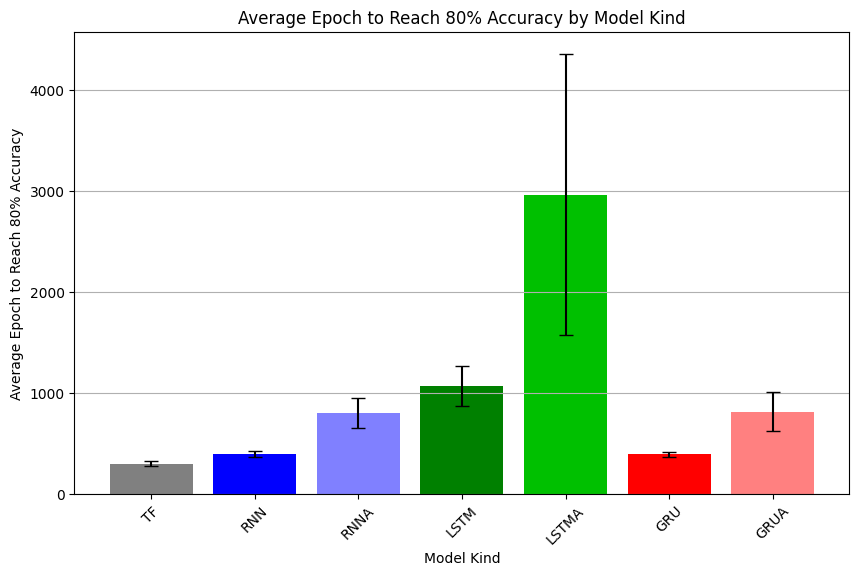

In [50]:
import matplotlib.pyplot as plt
import numpy as np

average_epochs_to_80 = {}
std_dev_epochs_to_80 = {}  # To store standard deviations

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
        std_dev_epochs_to_80[kind] = np.std(epochs_to_80)  # Calculate standard deviation
    else:
        average_epochs_to_80[kind] = None
        std_dev_epochs_to_80[kind] = None

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]
errors = [std_dev_epochs_to_80[kind] for kind in kinds]  # Errors for the plot

# The rest of your code for color settings remains unchanged

# Now, when plotting, include the 'yerr' parameter to add error bars
plt.figure(figsize=(10, 6))
plt.bar(kinds, averages, color=colors, yerr=errors, capsize=5)  # capsize adds horizontal lines at the tops
plt.xlabel('Model Kind')
plt.ylabel('Average Epoch to Reach 80% Accuracy')
plt.title('Average Epoch to Reach 80% Accuracy by Model Kind')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


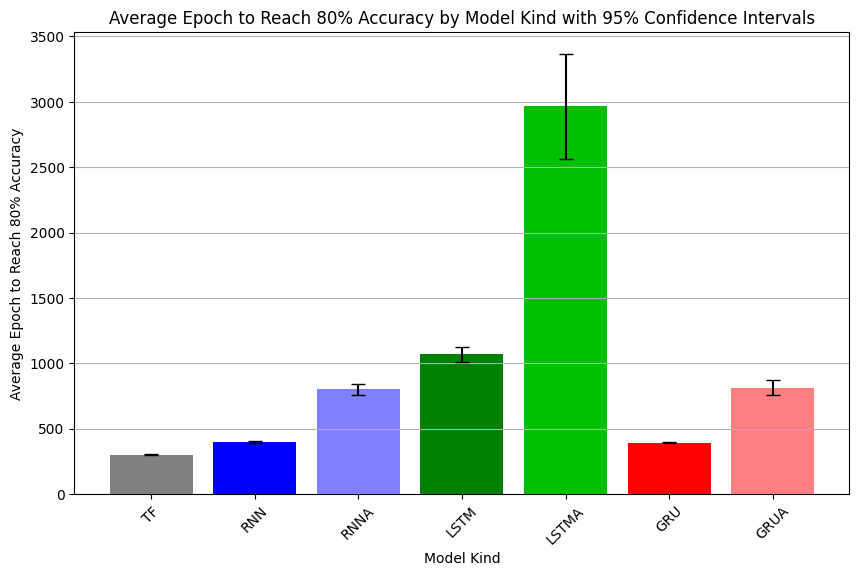

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming 'padded_rep_data_dict' is predefined and contains your data
# Example structure: {'ModelType': array_of_epochs_to_reach_80%_accuracy, ...}

average_epochs_to_80 = {}
conf_intervals = {}  # To store confidence intervals

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
        # Calculate the standard error of the mean (SEM)
        sem = stats.sem(epochs_to_80)
        # Determine the size of the sample
        n = len(epochs_to_80)
        # Get the t-critical value for 95% confidence
        t_critical = stats.t.ppf(0.975, n-1)  # two-tailed, and n-1 degrees of freedom
        # Calculate the margin of error
        margin_of_error = t_critical * sem
        # Store the margin of error (the "error" for plotting)
        conf_intervals[kind] = margin_of_error
    else:
        average_epochs_to_80[kind] = None
        conf_intervals[kind] = None

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]
errors = [conf_intervals[kind] if kind in conf_intervals else 0 for kind in kinds]  # Confidence interval margins for the plot

# Manually select base colors for each model type
base_colors = {
    "TF": "gray",
    "RNN": "blue",
    "LSTM": "green",
    "GRU": "red"
}

# Function to adjust color lightness
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Assign colors to each kind, adjusting for augmented models
colors = []
for kind in kinds:
    if kind in base_colors:  # Base model
        colors.append(base_colors[kind])
    else:  # Augmented model, make the color lighter
        base_model = kind[:-1]  # Remove the "A" to get the base model
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

# Plotting with confidence intervals
plt.figure(figsize=(10, 6))
plt.bar(kinds, averages, color=colors, yerr=errors, capsize=5)
plt.xlabel('Model Kind')
plt.ylabel('Average Epoch to Reach 80% Accuracy')
plt.title('Average Epoch to Reach 80% Accuracy by Model Kind with 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


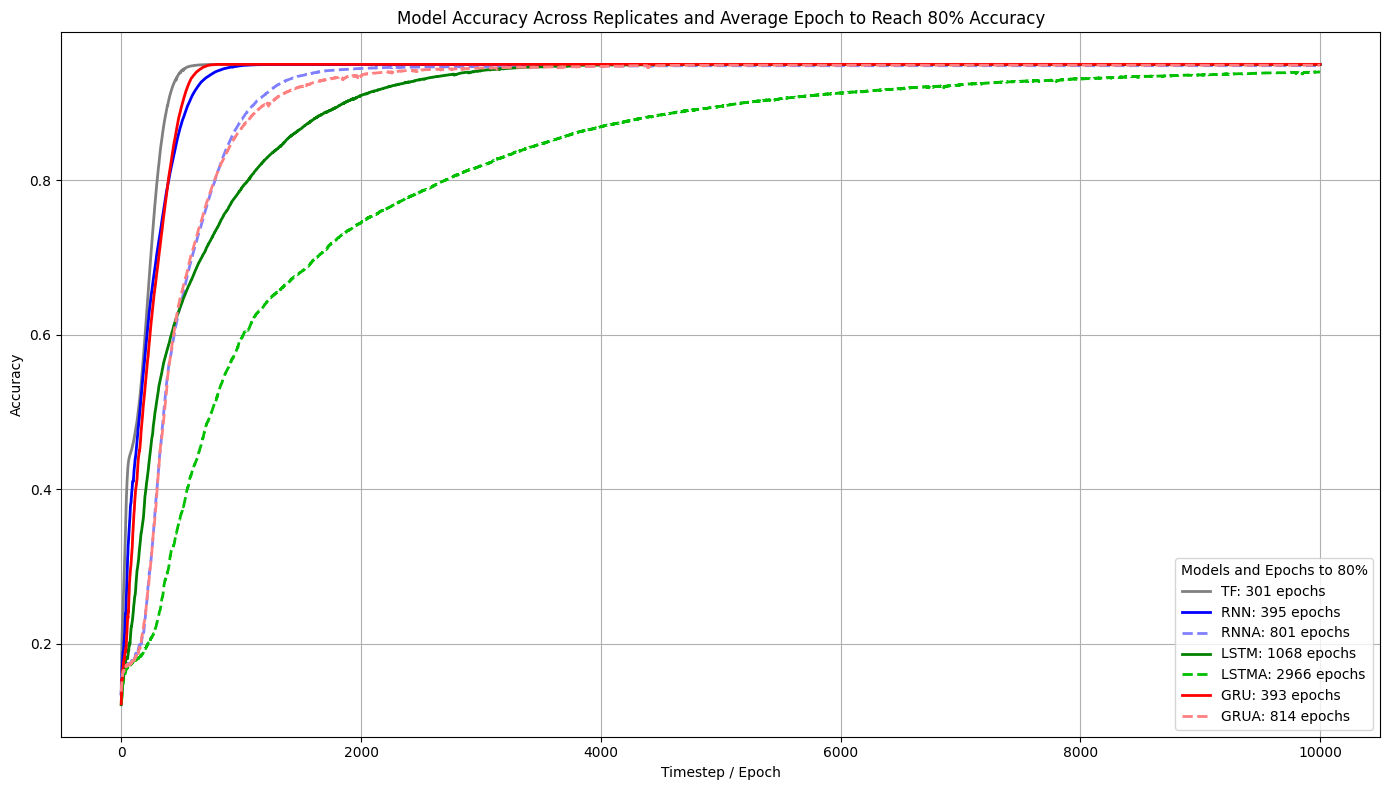

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Main plot for accuracy over time
fig, ax = plt.subplots(figsize=(14, 8))

# Track handles for custom legend entries
custom_legend_handles = []

# Plot accuracy for each model
for kind in kinds:
    avg_data = average_accuracy_dict[kind]
    if kind in base_colors:  # Base model
        color = base_colors[kind]
        linestyle = '-'
    else:  # Augmented model
        base_model = kind[:-1]  # Remove the "A" to find the base model
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    # Plot and add to legend handles
    line = ax.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)[0]
    custom_legend_handles.append(line)

# Modify each handle in the custom legend to include average epochs to reach 80% accuracy
for handle, kind in zip(custom_legend_handles, kinds):
    avg_epoch = average_epochs_to_80.get(kind, "N/A")
    handle.set_label(f"{kind}: {round(avg_epoch)} epochs")

ax.set_title("Model Accuracy Across Replicates and Average Epoch to Reach 80% Accuracy")
ax.set_xlabel("Timestep / Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True)

# Add custom legend to the plot, placing it in the bottom right corner
ax.legend(handles=custom_legend_handles, loc='lower right', title="Models and Epochs to 80%")

plt.tight_layout()
plt.show()


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_1312/2364384553.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


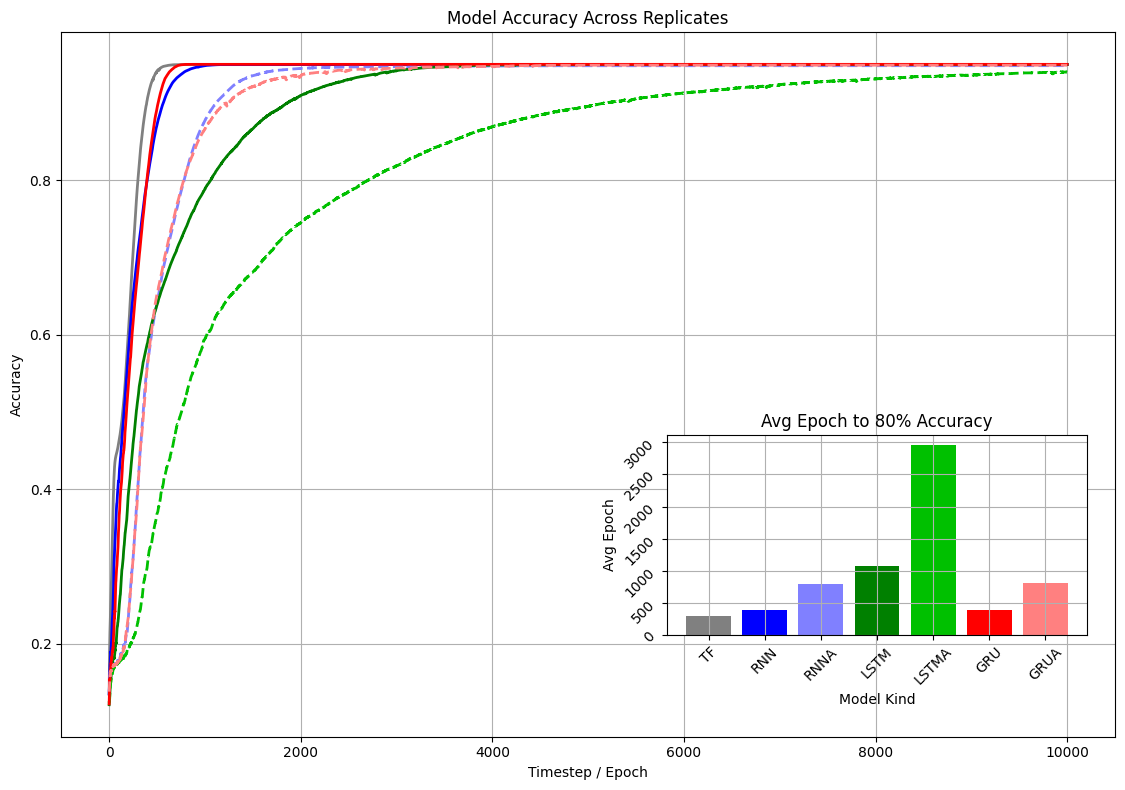

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Assuming 'average_epochs_to_80', 'average_accuracy_dict', and 'base_colors' are predefined

# Function to adjust color lightness
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Create the main plot (accuracy over time)
fig, ax = plt.subplots(figsize=(14, 8))
custom_legend_handles = []

for kind, avg_data in average_accuracy_dict.items():
    if kind in base_colors:  # Base model
        color = base_colors[kind]
        linestyle = '-'
    else:  # Augmented model
        base_model = kind[:-1]  # Remove the "A" to find the base model
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    line = ax.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)[0]
    custom_legend_handles.append(line)

ax.set_title("Model Accuracy Across Replicates")
ax.set_xlabel("Timestep / Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True)

# Position the legend above the inset plot on the bottom right
#legend = ax.legend(handles=custom_legend_handles, loc='lower right', bbox_to_anchor=(1, 0.1), title="Models")

# Insert the inset plot (bar plot for average epochs to reach 80% accuracy) in the bottom right corner
# Adjust these values to move the inset plot to the bottom right and possibly below the legend
inset_ax_position = [0.48, 0.2, 0.3, 0.25]  # [left, bottom, width, height]
inset_ax = fig.add_axes(inset_ax_position)

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]

colors = []
for kind in kinds:
    if kind in base_colors:
        colors.append(base_colors[kind])
    else:
        base_model = kind[:-1]
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

inset_ax.bar(kinds, averages, color=colors)
inset_ax.set_title('Avg Epoch to 80% Accuracy')
inset_ax.set_xlabel('Model Kind')
inset_ax.set_ylabel('Avg Epoch')
inset_ax.tick_params(labelrotation=45)
inset_ax.grid(True)

plt.tight_layout()
# Adjust figure layout to make room for the legend outside the main axes
plt.subplots_adjust(right=0.8)
plt.show()


# Generate M for all Models and calculations


In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA", "TF"]  # Assuming you have these types
nrOfSongs  = 4
source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
model_matrices = {}

num_reps = 50
# For each model, process the data and plot the resulting matrix
for kind in kinds:
    if kind == "TF":
        source,target,songs=getTrainingData(songStrings,nrOfSongs)

    for rep in range(num_reps):
        model_identifier = model_identifier = f'{kind}-{rep}'

        model = torch.load(f'./dataModelsSongs/{kind}_{rep}.model')
        model.eval()  # Set the model to evaluation mode if you're doing inference

        s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20, model_name = kind)
        M = removalIntoMatrix(s, 20, h)
        model_matrices[model_identifier] = M


In [27]:

with open('model_songs_matrices.pkl', 'wb') as file:
    pickle.dump(model_matrices, file)

In [53]:
with open('model_songs_matrices.pkl', 'rb') as file:
    model_matrices = pickle.load(file)

In [54]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

    Model Identifier                                             Matrix
0              RNN-0  [[0.7603615344483519, 0.8111313261922852, 0.81...
1              RNN-1  [[0.747260936946252, 0.4025095579701947, 0.811...
2              RNN-2  [[0.13395192824253677, 0.0, 0.6740993404019369...
3              RNN-3  [[0.010053438674871629, 0.7990524322571204, 0....
4              RNN-4  [[0.8112781244591325, 0.7919619786386782, 0.74...
..               ...                                                ...
345            TF-45  [[-0.017218012987574305, -0.015997424011526817...
346            TF-46  [[0.01587285397763072, -0.0014745161254241523,...
347            TF-47  [[0.002527419727010205, 0.045499330136966165, ...
348            TF-48  [[0.009051846171152178, -0.009138805251626358,...
349            TF-49  [[-0.0013659089140096725, 9.655284514753504e-0...

[350 rows x 2 columns]


In [55]:
results = []


for index, row in models_M.iterrows():
    model_identifier = row['Model Identifier']
    M = row['Matrix']
    kind, rep = model_identifier.split('-')                
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)

    threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
    threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

    binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
    binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
    binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
    binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)

    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

    degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

    min_values = np.min(binarized_combined_matrix, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this

    # Counting the number of 1's in each column
    ones_count = np.sum(binarized_combined_matrix, axis=0)
    # Calculating the overlap percentage for each column
    # Initialize the overlap percentage array
    overlap_percentage_per_column = np.zeros(ones_count.shape)
    # Setting the overlap percentage based on the number of 1's in each column
    overlap_percentage_per_column[ones_count == 2] = .5
    overlap_percentage_per_column[ones_count == 3] = .75
    overlap_percentage_per_column[ones_count == 4] = 1
    # Calculating the overall overlap percentage across all columns
    overall_overlap_percentage = (np.sum(overlap_percentage_per_column) / (ones_count.shape[0])) * 100

  
    
    metrics = {
        "Kind": kind,
        "Repetition": int(rep),
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans_song_1_treshold": round(threshold_song_1,4),
        "Kmeans_song_2_treshold": round(threshold_song_2,4),
        "Kmeans_song_3_treshold": round(threshold_song_3,4),
        "Kmeans_song_4_treshold": round(threshold_song_4,4),
        "Song_1_Nodes_exceeding_treshold": count_exceeding_song_1,
        "Song_2_Nodes_exceeding_treshold": count_exceeding_song_2,
        "Song_3_Nodes_exceeding_treshold": count_exceeding_song_3,
        "Song_4_Nodes_exceeding_treshold": count_exceeding_song_4,
        "Total_Nodes_exceeding_treshold": count_exceeding_song_1 + count_exceeding_song_2 + count_exceeding_song_3 + count_exceeding_song_4,
        "degree_2_overlapp": degree_2,
        "degree_3_overlapp": degree_3,
        "degree_4_overlapp": degree_4,
        "sum_of_degree_overlapp": degree_2 + degree_3 + degree_4,
        "Total_Overlapp_percentage" : overall_overlap_percentage,
        "overlapp_column1":overlap_percentage_per_column[0],
        "overlapp_column2":overlap_percentage_per_column[1],
        "overlapp_column3":overlap_percentage_per_column[2],
        "overlapp_column4":overlap_percentage_per_column[3],
        "overlapp_column5":overlap_percentage_per_column[4],
        "overlapp_column6":overlap_percentage_per_column[5],
        "overlapp_column7":overlap_percentage_per_column[6],
        "overlapp_column8":overlap_percentage_per_column[7],
        "overlapp_column9":overlap_percentage_per_column[8],
        "overlapp_column10":overlap_percentage_per_column[9],
        "overlapp_column11":overlap_percentage_per_column[10],
        "overlapp_column12":overlap_percentage_per_column[11],
        "overlapp_column13":overlap_percentage_per_column[12],
        "overlapp_column14":overlap_percentage_per_column[13],
        "overlapp_column15":overlap_percentage_per_column[14],
        "overlapp_column16":overlap_percentage_per_column[15],
        "overlapp_column17":overlap_percentage_per_column[16],
        "overlapp_column18":overlap_percentage_per_column[17],
        "overlapp_column19":overlap_percentage_per_column[18],
        "overlapp_column20":overlap_percentage_per_column[19],
        #"Biniarized Matrix": binarized_combined_matrix,
    }
    num_songs = 4
    # Assuming all songs have the same number of features/columns for simplicity
    num_columns = binarized_matrix_song_1.shape[0]  # Number of columns/features per song

    # Dictionary to store pairwise "11" overlaps for each song pair across all columns
    pair_11_overlaps = {}

    # Iterate through all song combinations
    for (i, j) in itertools.combinations(range(num_songs), 2):
        # Initialize a count for each song pair
        pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] = 0

        # For each column, check if both songs have a "1" in the same position
        for col in range(num_columns):
            if binarized_combined_matrix[i, col] == 1 and binarized_combined_matrix[j, col] == 1:
                # If both songs have "1" in the same column, increment the count
                pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] += 1

    # Update the metrics dictionary to include the "11" overlaps
    metrics.update(pair_11_overlaps)
    results.append(metrics)
    
df = pd.DataFrame(results)



In [56]:
df

Kind  Repetition  Sum of Absolute Values  Mean Value  Standard Deviation  \
0    RNN           0                 38.2479      0.4781              0.2960   
1    RNN           1                 39.0780      0.4885              0.3061   
2    RNN           2                 39.4933      0.4937              0.2961   
3    RNN           3                 38.0773      0.4760              0.3020   
4    RNN           4                 39.3687      0.4921              0.2991   
..   ...         ...                     ...         ...                 ...   
345   TF          45                 27.0409      0.3349              0.3041   
346   TF          46                 22.6778      0.2824              0.2637   
347   TF          47                 25.7061      0.3193              0.2912   
348   TF          48                 23.1031      0.2858              0.2745   
349   TF          49                 23.4838      0.2903              0.2722   

     Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0           0.8113         0.0000                  0.4262   
1           0.8113         0.0000                  0.4252   
2           0.8112        -0.0006                  0.3931   
3           0.8112         0.0000                  0.4171   
4           0.8113         0.0000                  0.4152   
..             ...            ...                     ...   
345         0.8112        -0.0290                  0.0329   
346         0.7616        -0.0130                  0.0267   
347         0.7854        -0.0238                  0.0217   
348         0.7681        -0.0179                  0.0068   
349         0.7681        -0.0372                  0.0248   

     Kmeans_song_2_treshold  Kmeans_song_3_treshold  ...  overlapp_column17  \
0                    0.4276                  0.3893  ...               0.00   
1                    0.4010                  0.3994  ...               0.50   
2                    0.4315                  0.4274  ...               0.75   
3                    0.4138                  0.3872  ...               1.00   
4                    0.4148                  0.3851  ...               1.00   
..                      ...                     ...  ...                ...   
345                  0.4377                  0.4057  ...               0.75   
346                  0.3194                  0.2959  ...               0.75   
347                  0.4030                  0.3713  ...               0.50   
348                  0.3495                  0.3309  ...               0.75   
349                  0.3765                  0.2970  ...               0.50   

     overlapp_column18  overlapp_column19  overlapp_column20  \
0                 0.50               0.00               1.00   
1                 0.50               0.00               0.75   
2                 0.00               0.50               1.00   
3                 0.50               0.75               0.50   
4                 0.50               0.50               0.50   
..                 ...                ...                ...   
345               0.00               1.00               0.50   
346               0.00               0.50               0.50   
347               0.75               0.50               0.50   
348               0.00               0.75               0.50   
349               0.00               0.00               0.50   

     song_1_song_2_11_overlap  song_1_song_3_11_overlap  \
0                           9                         9   
1                           9                         7   
2                          10                         6   
3                           9                         9   
4                          11                        10   
..                        ...                       ...   
345                         4                         4   
346                         3                         1   
347                         5                         5   
34

In [60]:
df.to_csv("songs_data.csv", index=False)

In [61]:
df = pd.read_csv("songs_data.csv")

In [62]:
df

Kind  Repetition  Sum of Absolute Values  Mean Value  Standard Deviation  \
0    RNN           0                 38.2479      0.4781              0.2960   
1    RNN           1                 39.0780      0.4885              0.3061   
2    RNN           2                 39.4933      0.4937              0.2961   
3    RNN           3                 38.0773      0.4760              0.3020   
4    RNN           4                 39.3687      0.4921              0.2991   
..   ...         ...                     ...         ...                 ...   
345   TF          45                 27.0409      0.3349              0.3041   
346   TF          46                 22.6778      0.2824              0.2637   
347   TF          47                 25.7061      0.3193              0.2912   
348   TF          48                 23.1031      0.2858              0.2745   
349   TF          49                 23.4838      0.2903              0.2722   

     Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0           0.8113         0.0000                  0.4262   
1           0.8113         0.0000                  0.4252   
2           0.8112        -0.0006                  0.3931   
3           0.8112         0.0000                  0.4171   
4           0.8113         0.0000                  0.4152   
..             ...            ...                     ...   
345         0.8112        -0.0290                  0.0329   
346         0.7616        -0.0130                  0.0267   
347         0.7854        -0.0238                  0.0217   
348         0.7681        -0.0179                  0.0068   
349         0.7681        -0.0372                  0.0248   

     Kmeans_song_2_treshold  Kmeans_song_3_treshold  ...  overlapp_column17  \
0                    0.4276                  0.3893  ...               0.00   
1                    0.4010                  0.3994  ...               0.50   
2                    0.4315                  0.4274  ...               0.75   
3                    0.4138                  0.3872  ...               1.00   
4                    0.4148                  0.3851  ...               1.00   
..                      ...                     ...  ...                ...   
345                  0.4377                  0.4057  ...               0.75   
346                  0.3194                  0.2959  ...               0.75   
347                  0.4030                  0.3713  ...               0.50   
348                  0.3495                  0.3309  ...               0.75   
349                  0.3765                  0.2970  ...               0.50   

     overlapp_column18  overlapp_column19  overlapp_column20  \
0                 0.50               0.00               1.00   
1                 0.50               0.00               0.75   
2                 0.00               0.50               1.00   
3                 0.50               0.75               0.50   
4                 0.50               0.50               0.50   
..                 ...                ...                ...   
345               0.00               1.00               0.50   
346               0.00               0.50               0.50   
347               0.75               0.50               0.50   
348               0.00               0.75               0.50   
349               0.00               0.00               0.50   

     song_1_song_2_11_overlap  song_1_song_3_11_overlap  \
0                           9                         9   
1                           9                         7   
2                          10                         6   
3                           9                         9   
4                          11                        10   
..                        ...                       ...   
345                         4                         4   
346                         3                         1   
347                         5                         5   
34

In [63]:

rnna_rows = df[df["Kind"] == "RNNA"]
rnna_rows

Kind  Repetition  Sum of Absolute Values  Mean Value  Standard Deviation  \
50  RNNA           0                 26.4653      0.3308              0.2572   
51  RNNA           1                 34.0052      0.4251              0.2809   
52  RNNA           2                 33.3349      0.4167              0.2796   
53  RNNA           3                 25.8643      0.3228              0.2624   
54  RNNA           4                 27.5011      0.3437              0.2628   
55  RNNA           5                 28.2557      0.3524              0.2787   
56  RNNA           6                 28.2058      0.3526              0.2773   
57  RNNA           7                 23.9706      0.2996              0.2616   
58  RNNA           8                 29.7861      0.3721              0.2662   
59  RNNA           9                 29.0912      0.3636              0.2681   
60  RNNA          10                 29.5083      0.3688              0.2941   
61  RNNA          11                 35.7449      0.4468              0.2950   
62  RNNA          12                 24.1895      0.3024              0.2524   
63  RNNA          13                 28.4662      0.3557              0.2722   
64  RNNA          14                 31.2084      0.3899              0.2807   
65  RNNA          15                 35.3401      0.4418              0.2895   
66  RNNA          16                 30.2183      0.3770              0.2746   
67  RNNA          17                 27.6688      0.3459              0.2734   
68  RNNA          18                 24.5732      0.3072              0.2524   
69  RNNA          19                 15.9959      0.1998              0.2179   
70  RNNA          20                 26.9955      0.3374              0.2636   
71  RNNA          21                 30.5494      0.3819              0.2798   
72  RNNA          22                 28.8743      0.3606              0.2698   
73  RNNA          23                 27.0852      0.3383              0.2644   
74  RNNA          24                 27.1158      0.3389              0.2738   
75  RNNA          25                 35.7175      0.4461              0.2855   
76  RNNA          26                 30.9829      0.3873              0.2684   
77  RNNA          27                 30.1273      0.3760              0.2752   
78  RNNA          28                 28.9494      0.3617              0.2742   
79  RNNA          29                 24.7667      0.3095              0.2465   
80  RNNA          30                 31.9169      0.3989              0.2727   
81  RNNA          31                 33.8991      0.4237              0.2695   
82  RNNA          32                 27.7453      0.3468              0.2764   
83  RNNA          33                 27.4451      0.3428              0.2676   
84  RNNA          34                 28.1429      0.3515              0.2680   
85  RNNA          35                 28.2866      0.3536              0.2728   
86  RNNA          36                 26.3184      0.3289              0.2613   
87  RNNA          37                 21.5904      0.2698              0.2484   
88  RNNA          38                 29.8879      0.3735              0.2700   
89  RNNA          39                 30.7692      0.3846              0.2679   
90  RNNA          40                 29.8049      0.3725              0.2607   
91  RNNA          41                 33.8012      0.4225              0.2739   
92  RNNA          42                 27.6209      0.3453              0.2691   
93  RNNA          43                 27.9654      0.3496              0.2545   
94  RNNA          44                 27.7042      0.3463              0.2752   
95  RNNA          45                 25.8251      0.3228              0.2546   
96  RNNA          46                 31.6676      0.3958              0.2793   
97  RNNA          47                 31.9612      0.3989              0.2820   
98  RNNA          48                 32.5080      0.4063              0.2840   
99  

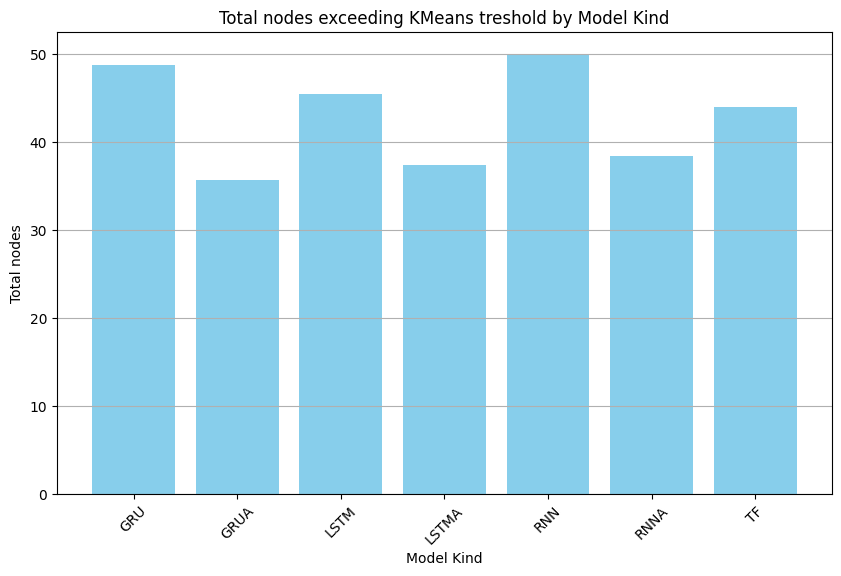

In [64]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the results

# Aggregate Total_Overlapp by Kind, calculating the mean for each
total_overlapp_by_kind = df.groupby('Kind')['Total_Nodes_exceeding_treshold'].mean().reset_index()

# Sort the DataFrame by Total_Overlapp for better visualization
#total_overlapp_by_kind = total_overlapp_by_kind.sort_values(by='Total_Nodes_exceeding_treshold', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(total_overlapp_by_kind['Kind'], total_overlapp_by_kind['Total_Nodes_exceeding_treshold'], color='skyblue')
plt.xlabel('Model Kind')
plt.ylabel('Total nodes')
plt.title('Total nodes exceeding KMeans treshold by Model Kind')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


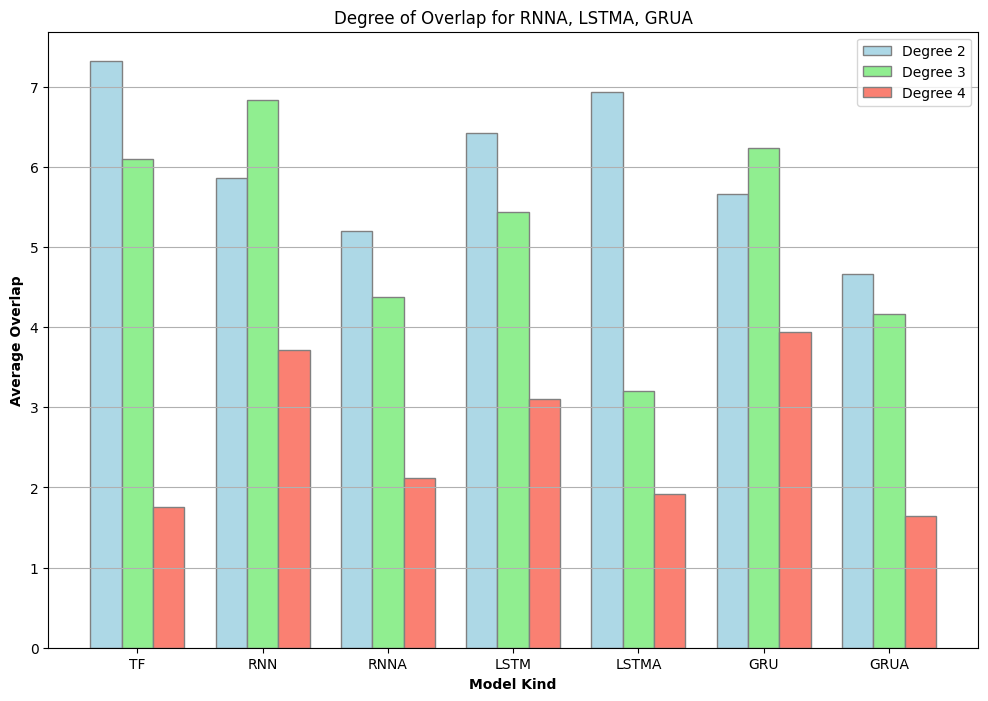

In [65]:
import numpy as np


degree_2_by_kind = df.groupby('Kind')['degree_2_overlapp'].mean().reset_index()
degree_3_by_kind = df.groupby('Kind')['degree_3_overlapp'].mean().reset_index()
degree_4_by_kind = df.groupby('Kind')['degree_4_overlapp'].mean().reset_index()

# Filter the DataFrame for the selected kinds
selected_kinds = ['TF','RNN', 'RNNA', 'LSTM', 'LSTMA', 'GRU', 'GRUA']
filtered_degree_2 = degree_2_by_kind[degree_2_by_kind['Kind'].isin(selected_kinds)]
filtered_degree_3 = degree_3_by_kind[degree_3_by_kind['Kind'].isin(selected_kinds)]
filtered_degree_4 = degree_4_by_kind[degree_4_by_kind['Kind'].isin(selected_kinds)]

# Ensure the order is consistent for plotting
filtered_degree_2 = filtered_degree_2.set_index('Kind').loc[selected_kinds].reset_index()
filtered_degree_3 = filtered_degree_3.set_index('Kind').loc[selected_kinds].reset_index()
filtered_degree_4 = filtered_degree_4.set_index('Kind').loc[selected_kinds].reset_index()

# Bar width
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(filtered_degree_2))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, filtered_degree_2['degree_2_overlapp'], color='lightblue', width=bar_width, edgecolor='grey', label='Degree 2')
plt.bar(r2, filtered_degree_3['degree_3_overlapp'], color='lightgreen', width=bar_width, edgecolor='grey', label='Degree 3')
plt.bar(r3, filtered_degree_4['degree_4_overlapp'], color='salmon', width=bar_width, edgecolor='grey', label='Degree 4')

# Add xticks on the middle of the group bars
plt.xlabel('Model Kind', fontweight='bold')
plt.ylabel('Average Overlap', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(filtered_degree_2))], filtered_degree_2['Kind'])

plt.title('Degree of Overlap for RNNA, LSTMA, GRUA')
plt.legend()
plt.grid(axis='y')
plt.show()


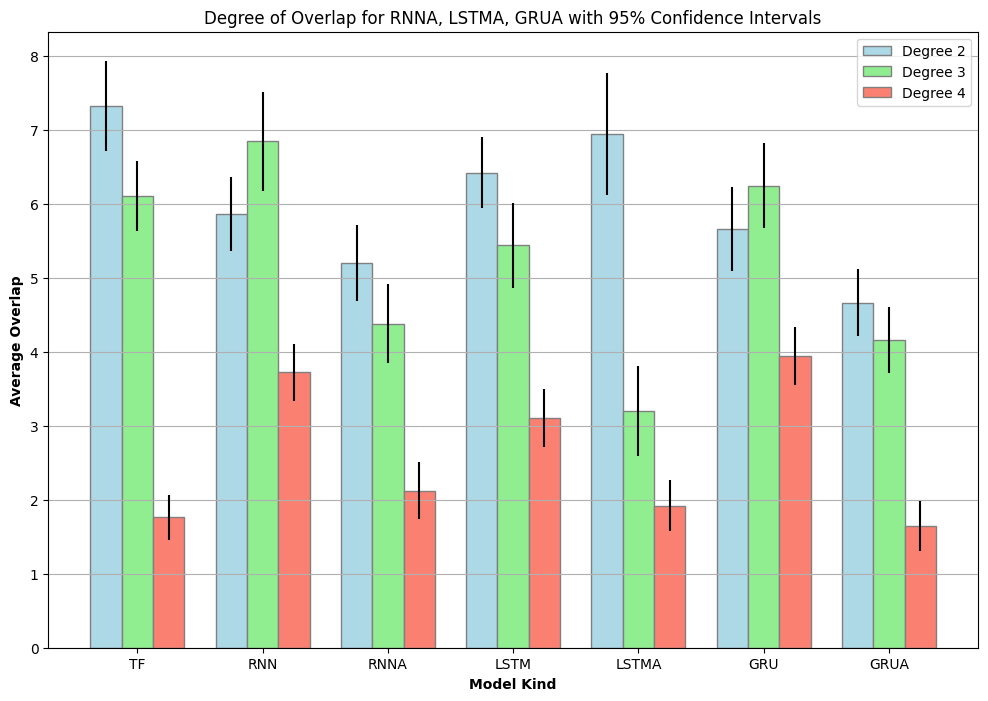

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Example of calculating mean and SEM for 'degree_2_overlapp'. Repeat for degree 3 and 4.
degree_2_stats = df[df['Kind'].isin(selected_kinds)].groupby('Kind')['degree_2_overlapp'].agg(['mean', 'sem', 'count']).reset_index()
degree_3_stats = df[df['Kind'].isin(selected_kinds)].groupby('Kind')['degree_3_overlapp'].agg(['mean', 'sem', 'count']).reset_index()
degree_4_stats = df[df['Kind'].isin(selected_kinds)].groupby('Kind')['degree_4_overlapp'].agg(['mean', 'sem', 'count']).reset_index()

# Calculate the 95% CI for each group and degree. This assumes a large sample size for simplicity. Adjust using t-distribution for smaller samples.
degree_2_stats['ci95'] = degree_2_stats['sem'] * stats.t.ppf((1 + 0.95) / 2., degree_2_stats['count']-1)
degree_3_stats['ci95'] = degree_3_stats['sem'] * stats.t.ppf((1 + 0.95) / 2., degree_3_stats['count']-1)
degree_4_stats['ci95'] = degree_4_stats['sem'] * stats.t.ppf((1 + 0.95) / 2., degree_4_stats['count']-1)

# Ensure the order is consistent for plotting
degree_2_stats = degree_2_stats.set_index('Kind').loc[selected_kinds].reset_index()
degree_3_stats = degree_3_stats.set_index('Kind').loc[selected_kinds].reset_index()
degree_4_stats = degree_4_stats.set_index('Kind').loc[selected_kinds].reset_index()

# Bar width
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(degree_2_stats))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, degree_2_stats['mean'], yerr=degree_2_stats['ci95'], color='lightblue', width=bar_width, edgecolor='grey', label='Degree 2')
plt.bar(r2, degree_3_stats['mean'], yerr=degree_3_stats['ci95'], color='lightgreen', width=bar_width, edgecolor='grey', label='Degree 3')
plt.bar(r3, degree_4_stats['mean'], yerr=degree_4_stats['ci95'], color='salmon', width=bar_width, edgecolor='grey', label='Degree 4')

# Add xticks on the middle of the group bars
plt.xlabel('Model Kind', fontweight='bold')
plt.ylabel('Average Overlap', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(degree_2_stats))], degree_2_stats['Kind'])

plt.title('Degree of Overlap for RNNA, LSTMA, GRUA with 95% Confidence Intervals')
plt.legend()
plt.grid(axis='y')
plt.show()


In [69]:
from scipy.stats import mannwhitneyu

# Define the pairs of models to compare and the degrees of overlap to test
model_pairs = [('RNN', 'RNNA'), ('LSTM', 'LSTMA'), ('GRU', 'GRUA')]
degrees_of_overlap = [2, 3, 4]

# Define the significance level
alpha = 0.05

# Loop over each degree of overlap
for degree in degrees_of_overlap:
    print(f'\nComparing Degree {degree} Overlap:')
    # Loop over each pair of models
    for model_1, model_2 in model_pairs:
        # Extract data for the two models being compared
        data_1 = df[(df['Kind'] == model_1)][f'degree_{degree}_overlapp']
        data_2 = df[(df['Kind'] == model_2)][f'degree_{degree}_overlapp']
        
        # Perform the Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(data_1, data_2, alternative='two-sided')
        
        # Determine if the result is significant
        if p_value < alpha:
            print(f'{model_1} vs {model_2}: Significant Difference (P-Value={p_value:.12f})')
        else:
            print(f'{model_1} vs {model_2}: No Significant Difference (P-Value={p_value:.12f})')


Comparing Degree 2 Overlap:
RNN vs RNNA: No Significant Difference (P-Value=0.068025587875)
LSTM vs LSTMA: No Significant Difference (P-Value=0.265816232511)
GRU vs GRUA: Significant Difference (P-Value=0.011189008139)

Comparing Degree 3 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000092478)
LSTM vs LSTMA: Significant Difference (P-Value=0.000001310991)
GRU vs GRUA: Significant Difference (P-Value=0.000000419835)

Comparing Degree 4 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000082944)
LSTM vs LSTMA: Significant Difference (P-Value=0.000018604733)
GRU vs GRUA: Significant Difference (P-Value=0.000000000011)


In [70]:
model_pairs = [('RNN', 'RNNA'), ('LSTM', 'LSTMA'), ('GRU', 'GRUA')]
degrees_of_overlap = [2, 3, 4]

# Define the significance level and initialize results dictionary
alpha = 0.05
significance_results = {}

# Loop over each degree of overlap
for degree in degrees_of_overlap:
    print(f'\nComparing Degree {degree} Overlap:')
    # Loop over each pair of models
    for model_1, model_2 in model_pairs:
        # Extract data for the two models being compared
        data_1 = df[(df['Kind'] == model_1)][f'degree_{degree}_overlapp']
        data_2 = df[(df['Kind'] == model_2)][f'degree_{degree}_overlapp']
        
        # Perform the Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(data_1, data_2, alternative='two-sided')
        
        # Determine if the result is significant and store the result
        significance_results[(model_1, model_2, degree)] = p_value < alpha
        if p_value < alpha:
            print(f'{model_1} vs {model_2}: Significant Difference (P-Value={p_value:.12f})')
        else:
            print(f'{model_1} vs {model_2}: No Significant Difference (P-Value={p_value:.12f})')


Comparing Degree 2 Overlap:
RNN vs RNNA: No Significant Difference (P-Value=0.068025587875)
LSTM vs LSTMA: No Significant Difference (P-Value=0.265816232511)
GRU vs GRUA: Significant Difference (P-Value=0.011189008139)

Comparing Degree 3 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000092478)
LSTM vs LSTMA: Significant Difference (P-Value=0.000001310991)
GRU vs GRUA: Significant Difference (P-Value=0.000000419835)

Comparing Degree 4 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000082944)
LSTM vs LSTMA: Significant Difference (P-Value=0.000018604733)
GRU vs GRUA: Significant Difference (P-Value=0.000000000011)


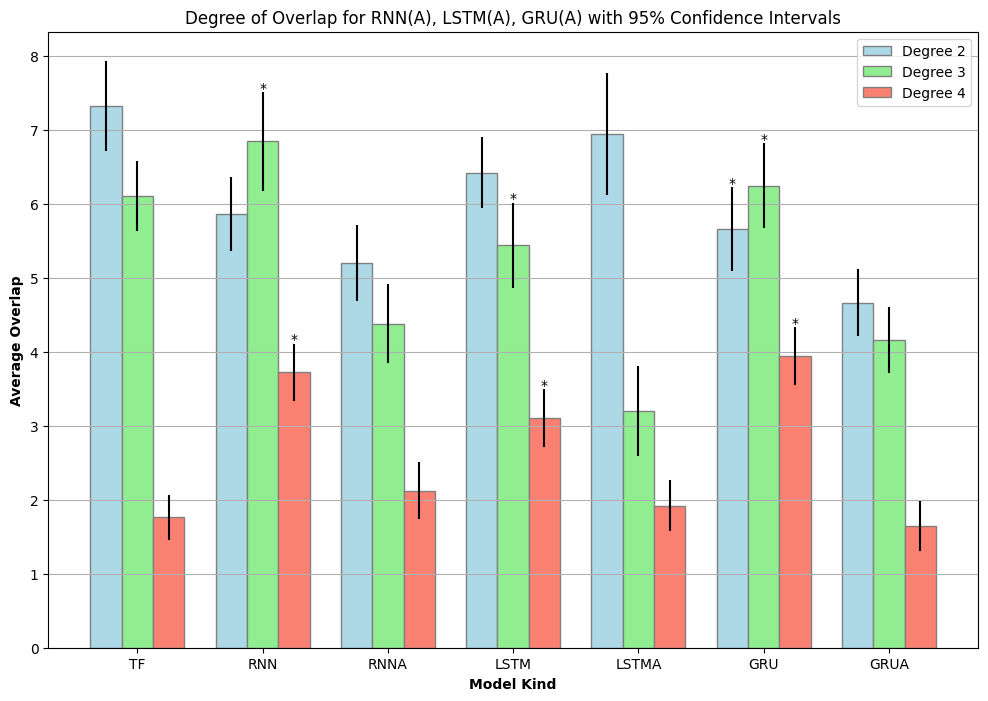

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming the setup of your data and significance_results as before

plt.figure(figsize=(12, 8))
bar_width = 0.25

r1 = np.arange(len(degree_2_stats))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width * 2 for x in r1]

bars1 = plt.bar(r1, degree_2_stats['mean'], yerr=degree_2_stats['ci95'], color='lightblue', width=bar_width, edgecolor='grey', label='Degree 2')
bars2 = plt.bar(r2, degree_3_stats['mean'], yerr=degree_3_stats['ci95'], color='lightgreen', width=bar_width, edgecolor='grey', label='Degree 3')
bars3 = plt.bar(r3, degree_4_stats['mean'], yerr=degree_4_stats['ci95'], color='salmon', width=bar_width, edgecolor='grey', label='Degree 4')

plt.xlabel('Model Kind', fontweight='bold')
plt.ylabel('Average Overlap', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(degree_2_stats))], degree_2_stats['Kind'])

# Marking significant differences
for idx, kind in enumerate(degree_2_stats['Kind']):
    for degree_idx, (degree, bars) in enumerate(zip(degrees_of_overlap, [bars1, bars2, bars3])):
        if significance_results.get((kind, f'{kind}A', degree), False):
            bar = bars[idx]
            ci = degree_2_stats['ci95'][idx] if degree == 2 else (degree_3_stats['ci95'][idx] if degree == 3 else degree_4_stats['ci95'][idx])
            height = bar.get_height() + ci
            plt.text(bar.get_x() + bar.get_width() / 2.0, height, '*', ha='center')

plt.title('Degree of Overlap for RNN(A), LSTM(A), GRU(A) with 95% Confidence Intervals')
plt.legend()
plt.grid(axis='y')
plt.show()


In [72]:
overlapp_columns = [f"overlapp_column{i}" for i in range(1, 21)]

# Extracting just the overlap columns (and 'Kind' if needed) to a new DataFrame


In [73]:
# Adjusting the selection to include only 'Kind' if 'Repetition' is not present
selected_columns = ['Kind','Repetition'] + overlapp_columns

# Extracting the selected columns to a new DataFrame
new_df_with_kind = df[selected_columns].copy()

new_df_with_kind.head() 

Kind  Repetition  overlapp_column1  overlapp_column2  overlapp_column3  \
0  RNN           0              0.00              0.75              1.00   
1  RNN           1              1.00              0.50              0.00   
2  RNN           2              0.50              0.50              0.50   
3  RNN           3              0.00              0.75              0.75   
4  RNN           4              0.75              0.75              1.00   

   overlapp_column4  overlapp_column5  overlapp_column6  overlapp_column7  \
0              0.75              0.00              1.00               1.0   
1              0.75              0.50              0.75               0.5   
2              0.75              0.75              1.00               0.5   
3              0.75              0.50              0.50               1.0   
4              0.00              0.50              0.50               1.0   

   overlapp_column8  ...  overlapp_column11  overlapp_column12  \
0              1.00  ...               0.00               0.75   
1              0.75  ...               0.50               0.50   
2              0.00  ...               1.00               0.50   
3              0.75  ...               0.00               0.50   
4              0.50  ...               0.75               0.50   

   overlapp_column13  overlapp_column14  overlapp_column15  overlapp_column16  \
0               0.50               0.50               0.75               0.50   
1               1.00               0.75               0.75               0.50   
2               0.75               0.50               0.50               0.75   
3               0.00               1.00               1.00               0.50   
4               0.00               1.00               0.75               1.00   

   overlapp_column17  overlapp_column18  overlapp_column19  overlapp_column20  
0               0.00                0.5               0.00               1.00  
1               0.50                0.5               0.00               0.75  
2               0.75                0.0               0.50               1.00  
3               1.00                0.5               0.75               0.50  
4               1.00                0.5               0.50               0.50  

[5 rows x 22 columns]

In [74]:

overlapp_columns = [f"overlapp_column{i}" for i in range(1, 21)]
# Assuming 'Kind' is a column in 'df' and each 'overlapp_columnX' represents a feature to be aggregated
grouped_overlapp_means = {column: df.groupby('Kind')[column].mean() for column in overlapp_columns}

# Assuming we want to compile these into a single DataFrame for visualization or further analysis
overlapp_mean_df = pd.DataFrame(grouped_overlapp_means)
overlapp_mean_df.reset_index(inplace=True)


In [75]:
overlapp_mean_df

Kind  overlapp_column1  overlapp_column2  overlapp_column3  \
0    GRU             0.535             0.620             0.530   
1   GRUA             0.475             0.260             0.305   
2   LSTM             0.550             0.520             0.560   
3  LSTMA             0.320             0.290             0.335   
4    RNN             0.555             0.600             0.605   
5   RNNA             0.375             0.425             0.395   
6     TF             0.490             0.485             0.460   

   overlapp_column4  overlapp_column5  overlapp_column6  overlapp_column7  \
0             0.490             0.560             0.545             0.590   
1             0.330             0.360             0.375             0.340   
2             0.545             0.345             0.480             0.535   
3             0.300             0.400             0.380             0.345   
4             0.550             0.620             0.700             0.570   
5             0.415             0.400             0.425             0.405   
6             0.480             0.480             0.515             0.525   

   overlapp_column8  overlapp_column9  ...  overlapp_column11  \
0             0.485             0.575  ...              0.620   
1             0.390             0.305  ...              0.355   
2             0.495             0.550  ...              0.550   
3             0.315             0.385  ...              0.425   
4             0.625             0.560  ...              0.590   
5             0.360             0.390  ...              0.465   
6             0.375             0.515  ...              0.515   

   overlapp_column12  overlapp_column13  overlapp_column14  overlapp_column15  \
0              0.595              0.620              0.595              0.585   
1              0.490              0.260              0.305              0.440   
2              0.545              0.600              0.530              0.450   
3              0.450              0.420              0.435              0.415   
4              0.605              0.625              0.535              0.560   
5              0.395              0.355              0.415              0.385   
6              0.615              0.515              0.480              0.550   

   overlapp_column16  overlapp_column17  overlapp_column18  overlapp_column19  \
0              0.615              0.600              0.550              0.530   
1              0.280              0.405              0.340              0.405   
2              0.460              0.545              0.615              0.560   
3              0.410              0.505              0.480              0.475   
4              0.550              0.620              0.605              0.540   
5              0.315              0.360              0.450              0.415   
6              0.475              0.540              0.505              0.555   

   overlapp_column20  
0              0.625  
1              0.315  
2              0.505  
3              0.425  
4              0.535  
5              0.500  
6              0.475  

[7 rows x 21 columns]

In [76]:
L = len(df['Song_1_Nodes_exceeding_treshold'])
X  = np.random.normal(0,0.2,(L))
Y  = np.random.normal(0,0.2,(L))


(-1.0, 21.0)

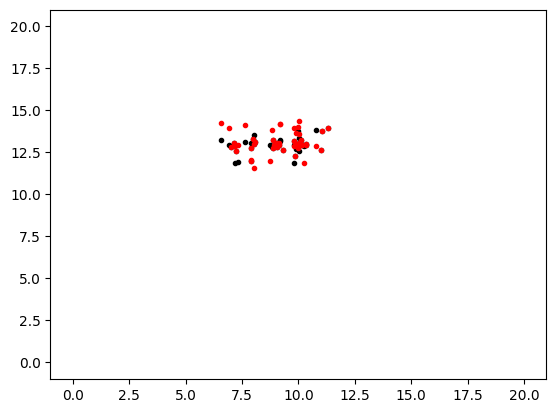

In [77]:
who = df['Kind'] == 'RNN'
plot(df['song_1_song_2_11_overlap'][who] + X[who] , df['Song_1_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_1_song_2_11_overlap'][who] + X[who] , df['Song_2_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

(-1.0, 21.0)

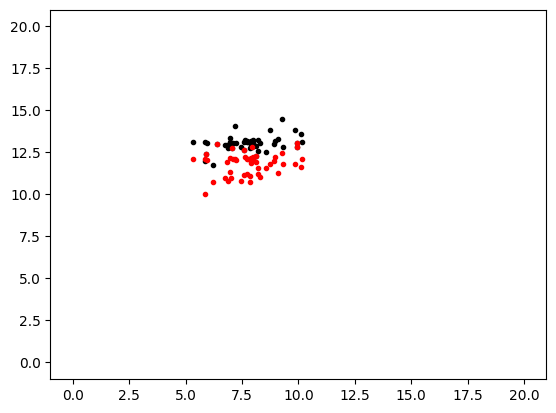

In [35]:
who = df['Kind'] == 'RNN'
plot(df['song_1_song_3_11_overlap'][who] + X[who] , df['Song_1_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_1_song_3_11_overlap'][who] + X[who] , df['Song_3_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

(-1.0, 21.0)

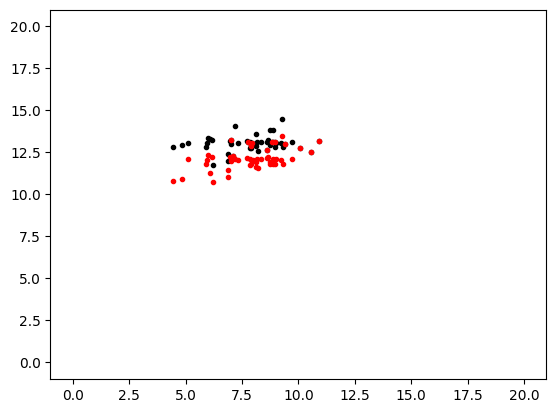

In [36]:
who = df['Kind'] == 'RNN'
plot(df['song_1_song_4_11_overlap'][who] + X[who] , df['Song_1_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_1_song_4_11_overlap'][who] + X[who] , df['Song_4_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

(-1.0, 21.0)

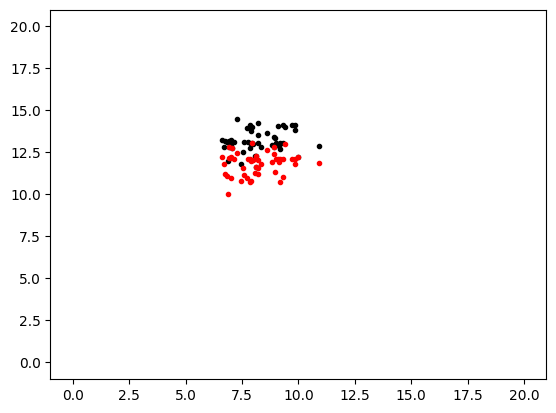

In [37]:
who = df['Kind'] == 'RNN'
plot(df['song_2_song_3_11_overlap'][who] + X[who] , df['Song_2_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_2_song_3_11_overlap'][who] + X[who] , df['Song_3_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

(-1.0, 21.0)

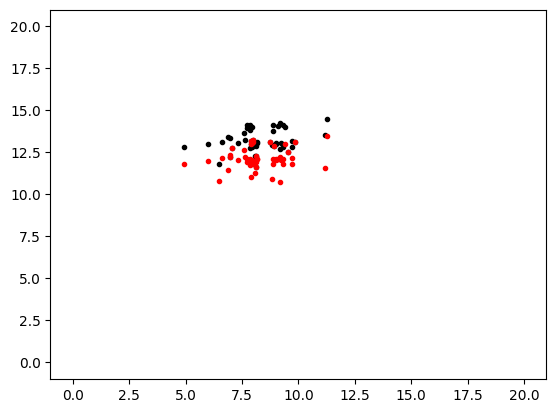

In [38]:
who = df['Kind'] == 'RNN'
plot(df['song_2_song_4_11_overlap'][who] + X[who] , df['Song_2_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_2_song_4_11_overlap'][who] + X[who] , df['Song_4_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

(-1.0, 21.0)

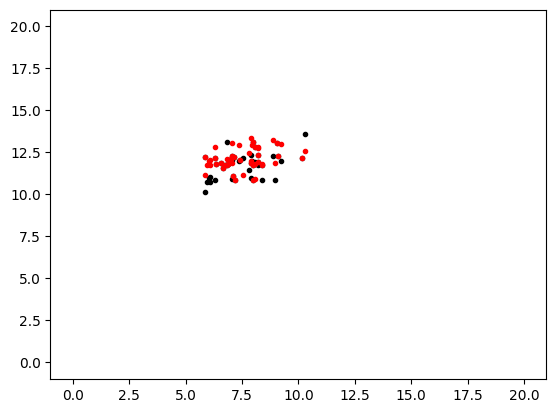

In [147]:
who = df['Kind'] == 'RNN'
plot(df['song_3_song_4_11_overlap'][who] + X[who] , df['Song_3_Nodes_exceeding_treshold'][who] + Y[who] , '.k')
plot(df['song_3_song_4_11_overlap'][who] + X[who] , df['Song_4_Nodes_exceeding_treshold'][who] + Y[who] , '.r')
xlim(-1,21)
ylim(-1,21)

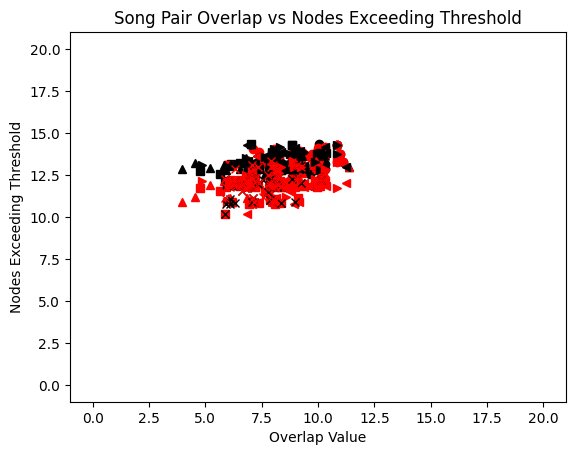

In [150]:
# Filtering to RNN kinds only
who = df['Kind'] == 'RNN'

# Define markers for each pair for clarity
markers = ['o', 's', '^', '<', '>', 'x']  # Example markers

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Plot each pair
for i, (overlap, song1, song2) in enumerate(pairs):
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], marker=markers[i], linestyle='None', color='k', label=f'{song1} vs {song2}, Overlap')
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], marker=markers[i], linestyle='None', color='r', label=f'{song2} vs {song1}, Overlap')

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Adding legend
# Note: With many plots, the legend might become crowded. Consider using a legend for only a subset or adjusting the legend placement.
#plt.legend()

# Display the combined plot
plt.show()

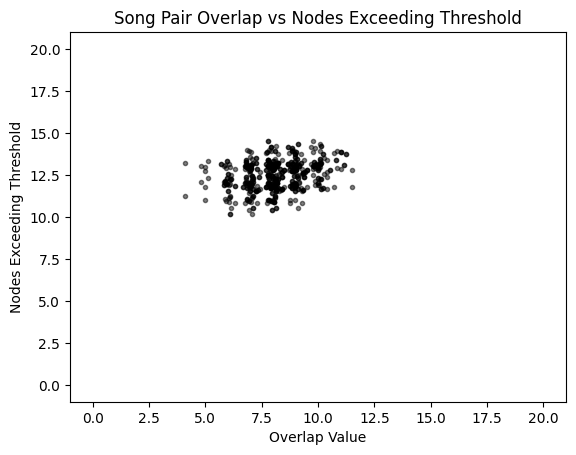

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'RNN'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


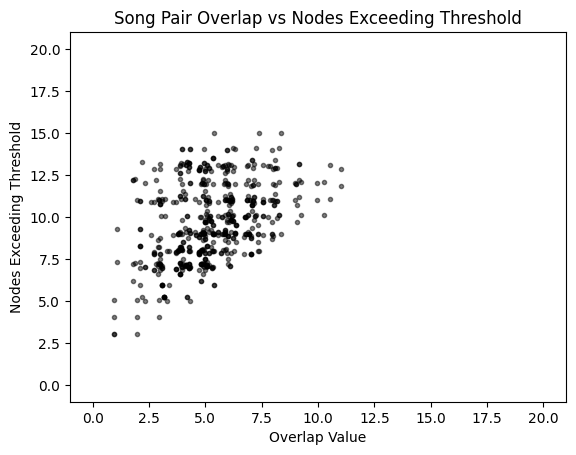

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'RNNA'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


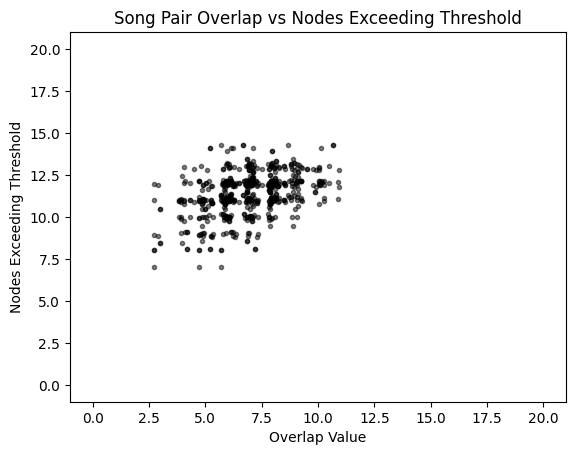

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'LSTM'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


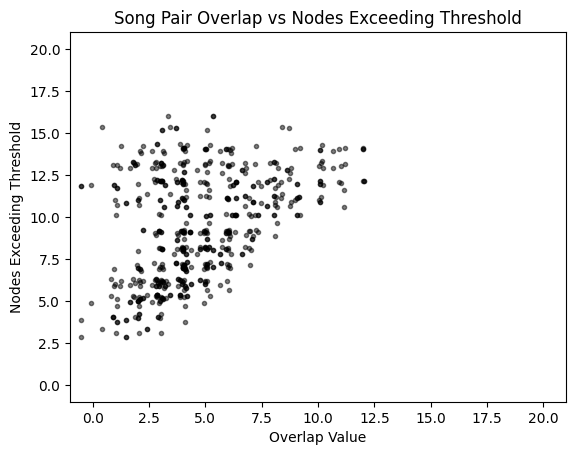

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'LSTMA'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


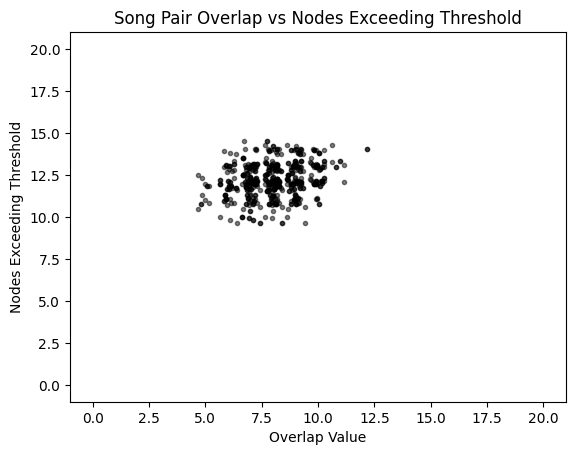

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'GRU'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


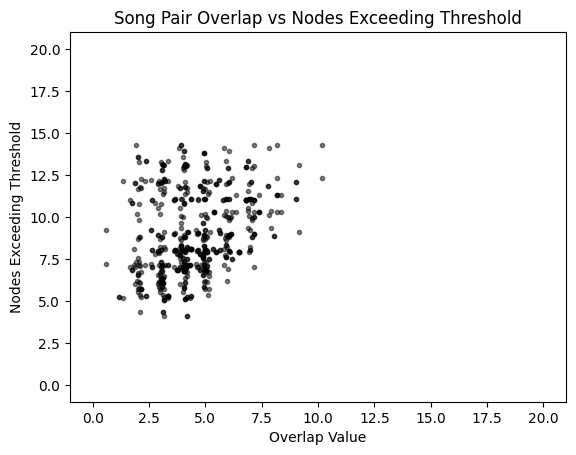

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'GRUA'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


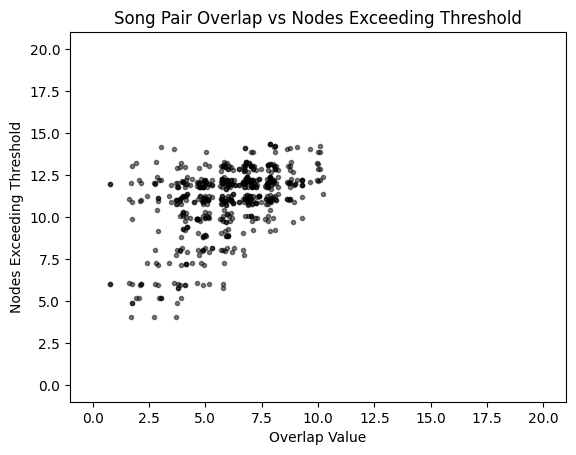

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is already defined.
# Assuming X and Y are already defined and generated.

# Filtering to RNN kinds only
who = df['Kind'] == 'TF'

# Define plot commands for each pair
pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Using a single color and marker type for all plots
for overlap, song1, song2 in pairs:
    plt.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
    plt.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)

# Setting plot limits and labels
plt.xlim(-1, 21)
plt.ylim(-1, 21)
plt.xlabel('Overlap Value')
plt.ylabel('Nodes Exceeding Threshold')
plt.title('Song Pair Overlap vs Nodes Exceeding Threshold')

# Display the combined plot
plt.show()


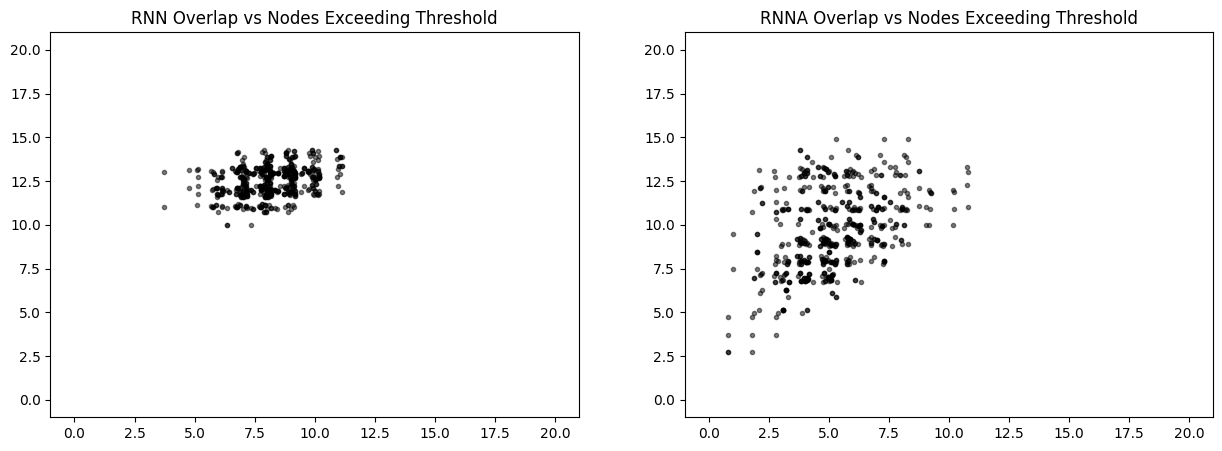

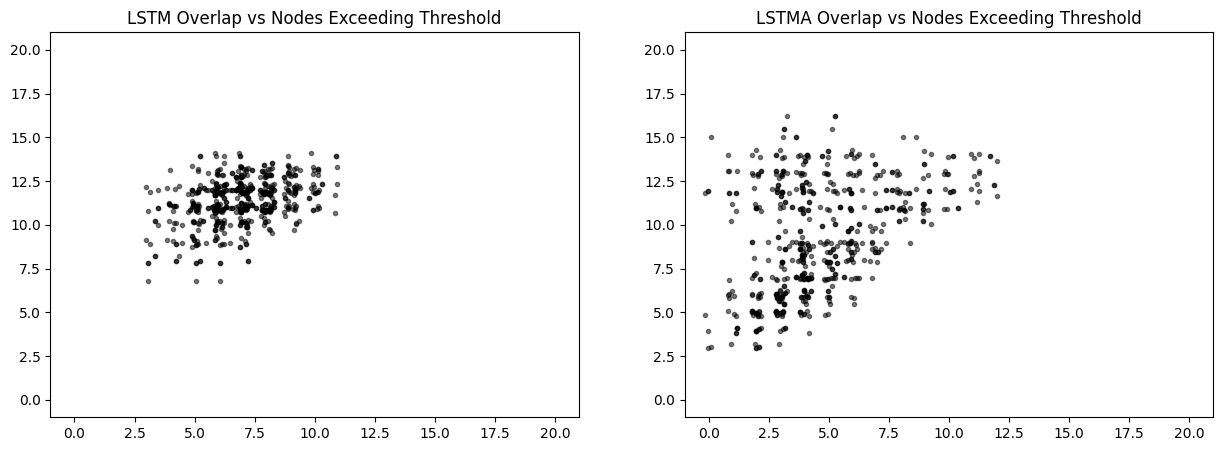

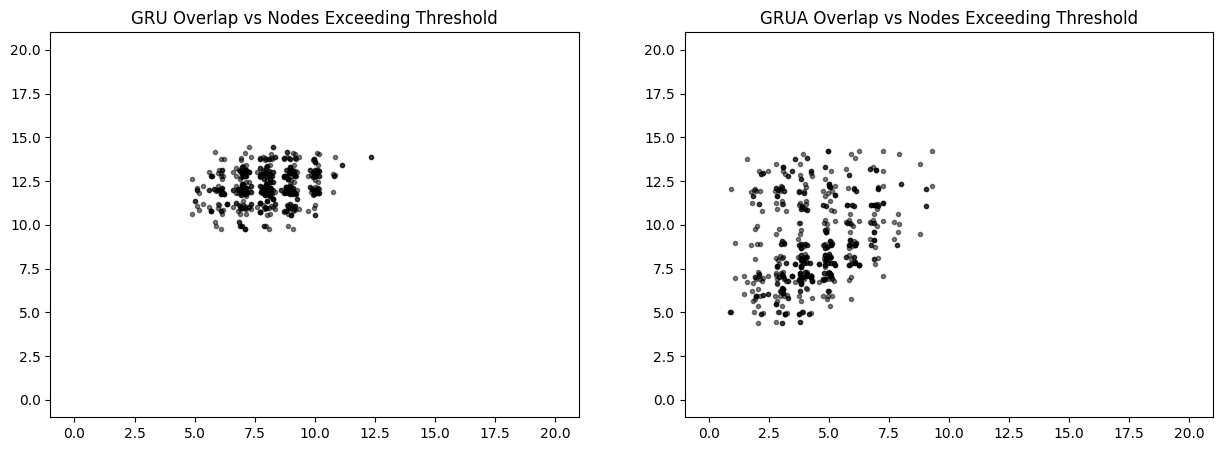

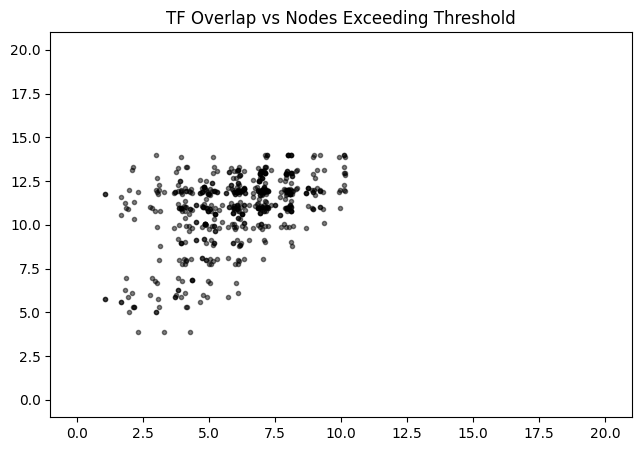

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df', 'X', and 'Y' are already defined.
# Define the types of neural networks and their respective advanced versions
nn_types = [
    ('RNN', 'RNNA'),
    ('LSTM', 'LSTMA'),
    ('GRU', 'GRUA'),
    ('TF', None)  # TF does not have an advanced version in this list
]

pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

for nn_type, nn_advanced in nn_types:
    if nn_advanced:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        axs = [ax]  # Wrap the single ax in a list for consistent handling below

    # Plot for regular type
    who = df['Kind'] == nn_type
    ax = axs[0]
    for overlap, song1, song2 in pairs:
        ax.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
        ax.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)
    ax.set_xlim(-1, 21)
    ax.set_ylim(-1, 21)
    ax.set_title(f'{nn_type} Overlap vs Nodes Exceeding Threshold')

    # Plot for advanced type if applicable
    if nn_advanced:
        who = df['Kind'] == nn_advanced
        ax = axs[1]
        for overlap, song1, song2 in pairs:
            ax.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
            ax.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)
        ax.set_xlim(-1, 21)
        ax.set_ylim(-1, 21)
        ax.set_title(f'{nn_advanced} Overlap vs Nodes Exceeding Threshold')

    plt.show()


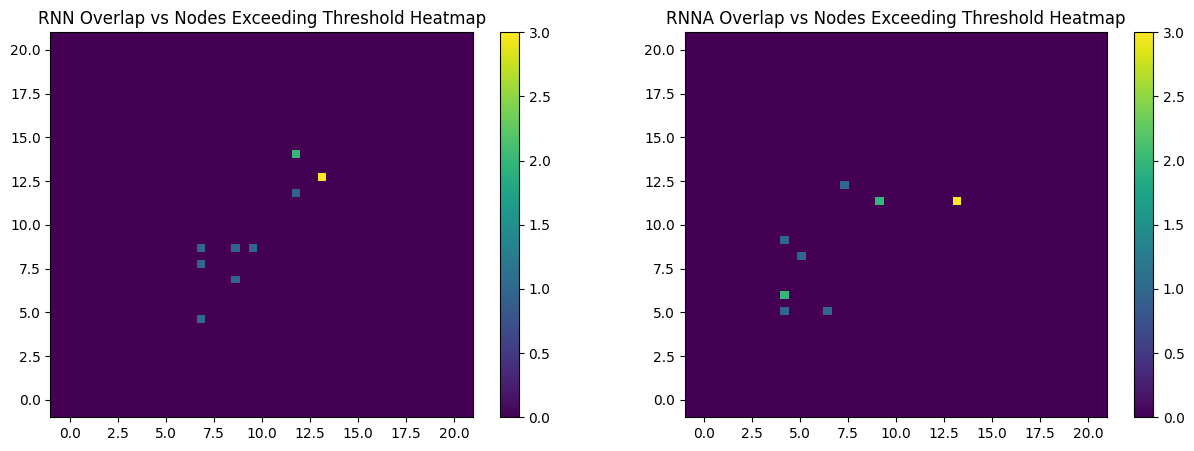

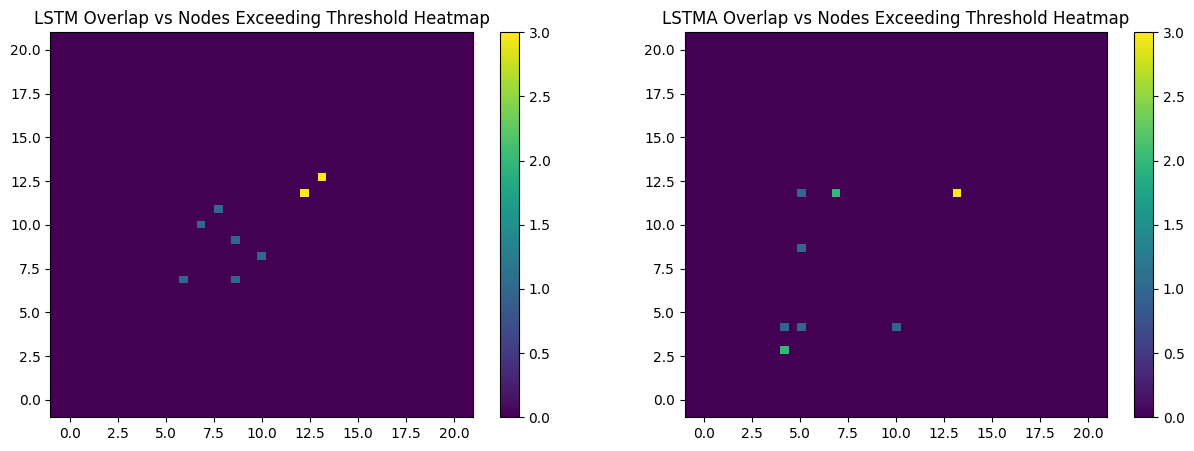

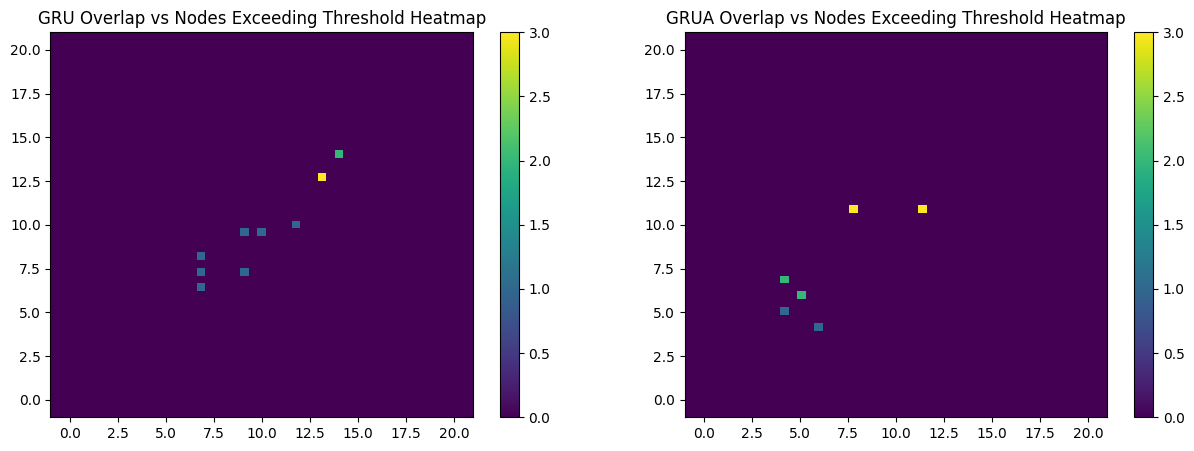

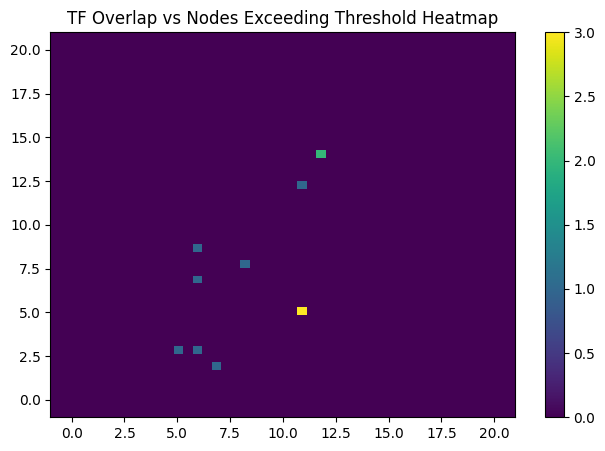

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the types of neural networks and their respective advanced versions
nn_types = [
    ('RNN', 'RNNA'),
    ('LSTM', 'LSTMA'),
    ('GRU', 'GRUA'),
    ('TF', None)  # TF does not have an advanced version in this list
]

pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Define bins and range for the histogram
bins = [np.linspace(-1, 21, 50), np.linspace(-1, 21, 50)]  # Adjust bin size and ranges according to data

for nn_type, nn_advanced in nn_types:
    if nn_advanced:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        axs = [ax]  # Wrap the single ax in a list for consistent handling below

    # Plot heatmap for regular type
    who = df['Kind'] == nn_type
    ax = axs[0]
    points = np.vstack([(df[overlap][who] + X[who]).values for overlap, _, _ in pairs] +
                       [(df[song][who] + Y[who]).values for _, song, _ in pairs])
    H, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=bins)
    heatmap = ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
    ax.set_title(f'{nn_type} Overlap vs Nodes Exceeding Threshold Heatmap')
    fig.colorbar(heatmap, ax=ax)  # Add a colorbar to the axes.

    # Plot heatmap for advanced type if applicable
    if nn_advanced:
        who = df['Kind'] == nn_advanced
        ax = axs[1]
        points = np.vstack([(df[overlap][who] + X[who]).values for overlap, _, _ in pairs] +
                           [(df[song][who] + Y[who]).values for _, song, _ in pairs])
        H, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=bins)
        heatmap = ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
        ax.set_title(f'{nn_advanced} Overlap vs Nodes Exceeding Threshold Heatmap')
        fig.colorbar(heatmap, ax=ax)  # Add a colorbar to this axes as well.

    plt.show()


# Adding Noise


In [69]:
def shuffle_notes(song_string, percentage):
    song_list = list(song_string)
    num_to_shuffle = int(len(song_list) * (percentage / 100))
    indices_to_shuffle = random.sample(range(len(song_list)), num_to_shuffle)

    shuffled_indices = indices_to_shuffle.copy()
    random.shuffle(shuffled_indices)

    for original, shuffled in zip(indices_to_shuffle, shuffled_indices):
        song_list[original] = song_string[shuffled]

    return ''.join(song_list)



In [70]:
def evaluate_model_with_noise(model, songStrings, number_of_Songs, noise_levels):
    results = {"noise_level": [], "accuracy": []}

    for noise_level in noise_levels:
        noisy_songStrings = np.array([shuffle_notes(song, noise_level) for song in songStrings])
        I, _, O_indices, _ = generateIOData(number_of_Songs, noisy_songStrings)
        
        inputs = torch.tensor(I, dtype=torch.float)
        targets = torch.tensor(O_indices, dtype=torch.long).view(-1)

        model.eval()
        
        with torch.no_grad():
            outputs = model(inputs)
            output_flat = outputs.view(-1, outputs.shape[-1])
            _, predicted_indices = torch.max(output_flat, 1)
            correct_predictions = (predicted_indices == targets).sum().item()
            total_accuracy = correct_predictions / targets.numel()
            
            print(f"Noise Level: {noise_level}%, Accuracy: {total_accuracy:.4f}")
            
            results["noise_level"].append(noise_level)
            results["accuracy"].append(total_accuracy)

    return results


Evaluating models of type: RNN
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501


Noise Level: 3%, Accuracy: 0.9501
Noise Level: 4%, Accuracy: 0.9501
Noise Level: 5%, Accuracy: 0.9061
Noise Level: 6%, Accuracy: 0.8535
Noise Level: 7%, Accuracy: 0.8921
Noise Level: 8%, Accuracy: 0.8089
Noise Level: 9%, Accuracy: 0.7443
Noise Level: 10%, Accuracy: 0.7927
Noise Level: 11%, Accuracy: 0.8145
Noise Level: 12%, Accuracy: 0.6821
Noise Level: 13%, Accuracy: 0.6716
Noise Level: 14%, Accuracy: 0.6915
Noise Level: 15%, Accuracy: 0.6597
Noise Level: 16%, Accuracy: 0.6598
Noise Level: 17%, Accuracy: 0.5986
Noise Level: 18%, Accuracy: 0.6250
Noise Level: 19%, Accuracy: 0.6012
Noise Level: 20%, Accuracy: 0.4803
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501
Noise Level: 3%, Accuracy: 0.9501
Noise Level: 4%, Accuracy: 0.9501
Noise Level: 5%, Accuracy: 0.8756
Noise Level: 6%, Accuracy: 0.8616
Noise Level: 7%, Accuracy: 0.9501
Noise Level: 8%, Accuracy: 0.9132
Noise Level: 9%, Accuracy: 0.8767
Noise Level: 10%, Accuracy: 0.7687
No

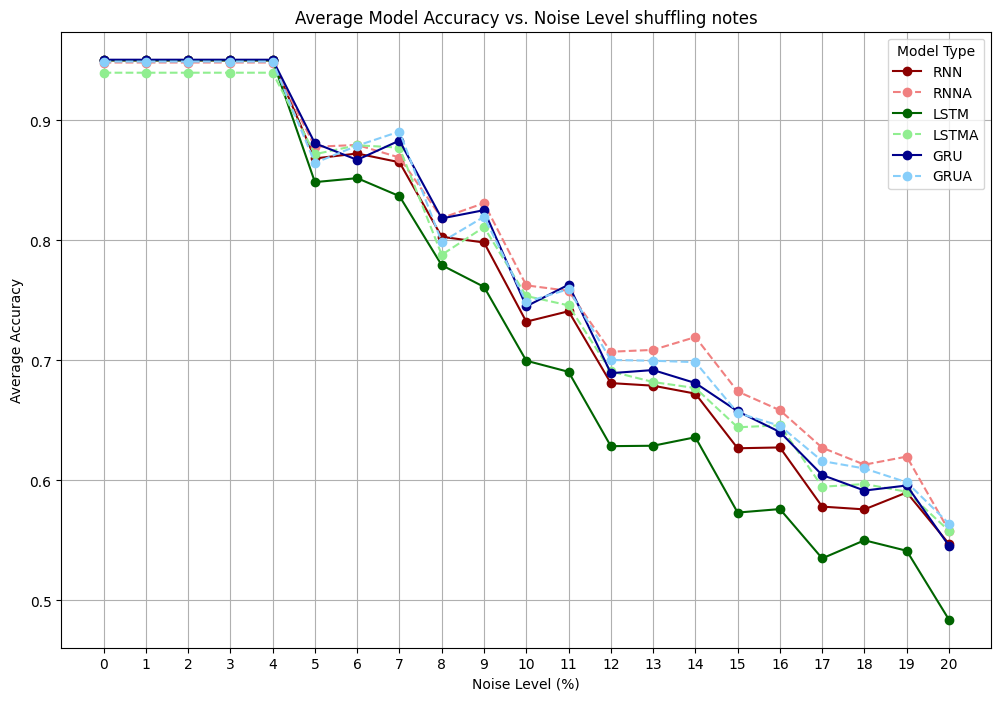

In [73]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming the evaluate_model_with_noise function is defined as before

# Model kinds and settings
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
noise_levels = list(range(21))  # 0% to 10% noise

# Initialize a dictionary to store the cumulative accuracies for averaging
cumulative_results = {kind: np.zeros(len(noise_levels)) for kind in kinds}

# Iterate over each model kind and repetition
for kind in kinds:
    print(f"Evaluating models of type: {kind}")
    for rep in range(num_reps):
        model_path = f'./dataModelsSongs/{kind}_{rep}.model'
        model = torch.load(model_path)
        model.eval()  # Ensure the model is in evaluation mode
        temp_results = evaluate_model_with_noise(model, songStrings, 4, noise_levels)
        
        # Accumulate accuracies for later averaging
        cumulative_results[kind] += np.array(temp_results['accuracy'])
    
    # Calculate the average by dividing by the number of repetitions
    cumulative_results[kind] /= num_reps


plot_styles = {
    "RNN": {"color": "darkred", "linestyle": "-"},
    "RNNA": {"color": "lightcoral", "linestyle": "--"},
    "LSTM": {"color": "darkgreen", "linestyle": "-"},
    "LSTMA": {"color": "lightgreen", "linestyle": "--"},
    "GRU": {"color": "darkblue", "linestyle": "-"},
    "GRUA": {"color": "lightskyblue", "linestyle": "--"}
}

# Plotting the results with specified colors and line styles
plt.figure(figsize=(12, 8))
for kind, accuracies in cumulative_results.items():
    plt.plot(noise_levels, accuracies, marker='o', label=kind, **plot_styles[kind])

plt.title('Average Model Accuracy vs. Noise Level shuffling notes')
plt.xlabel('Noise Level (%)')
plt.ylabel('Average Accuracy')
plt.legend(title='Model Type')
plt.xticks(noise_levels)    
plt.grid(True)
plt.show()


Evaluating models of type: TF
Noise Level: 0%, Accuracy: 0.7573


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_3277/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_3277/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Noise Level: 1%, Accuracy: 0.7573
Noise Level: 2%, Accuracy: 0.7573
Noise Level: 3%, Accuracy: 0.7573
Noise Level: 4%, Accuracy: 0.7573
Noise Level: 5%, Accuracy: 0.6488
Noise Level: 6%, Accuracy: 0.6993
Noise Level: 7%, Accuracy: 0.6961
Noise Level: 8%, Accuracy: 0.6410
Noise Level: 9%, Accuracy: 0.5909
Noise Level: 10%, Accuracy: 0.5735
Noise Level: 11%, Accuracy: 0.6494
Noise Level: 12%, Accuracy: 0.5412
Noise Level: 13%, Accuracy: 0.5800
Noise Level: 14%, Accuracy: 0.6530
Noise Level: 15%, Accuracy: 0.4078
Noise Level: 16%, Accuracy: 0.4572
Noise Level: 17%, Accuracy: 0.4392
Noise Level: 18%, Accuracy: 0.4149
Noise Level: 19%, Accuracy: 0.4627
Noise Level: 20%, Accuracy: 0.5118
Noise Level: 0%, Accuracy: 0.7305
Noise Level: 1%, Accuracy: 0.7305
Noise Level: 2%, Accuracy: 0.7305
Noise Level: 3%, Accuracy: 0.7305
Noise Level: 4%, Accuracy: 0.7305
Noise Level: 5%, Accuracy: 0.7320
Noise Level: 6%, Accuracy: 0.5868
Noise Level: 7%, Accuracy: 0.6781
Noise Level: 8%, Accuracy: 0.5591
Noi

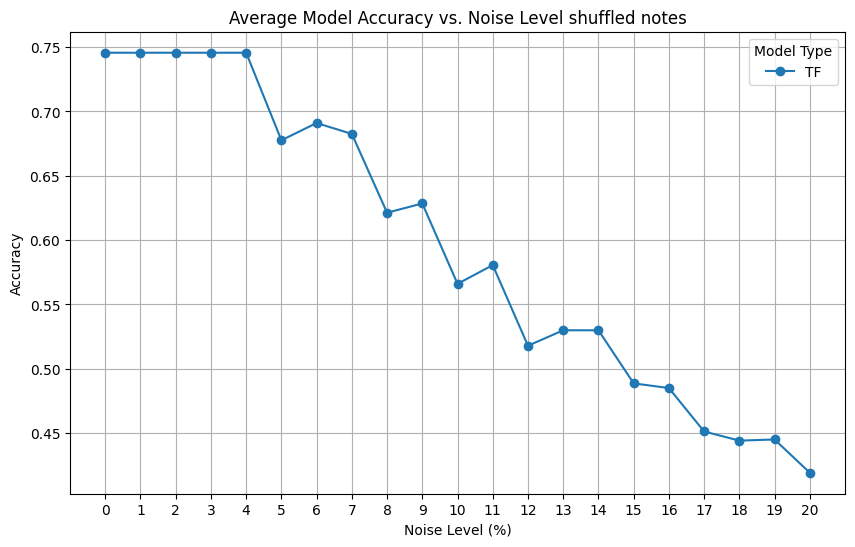

In [74]:
kinds = ["TF"]
num_reps = 50
noise_levels = list(range(21))  # 0% to 10% noise

# Initialize a dictionary to store the cumulative accuracies for averaging
cumulative_results = {kind: np.zeros(len(noise_levels)) for kind in kinds}

# Function to shuffle notes in song strings based on a specified noise level
def shuffle_notes(song_string, percentage):
    song_list = list(song_string)
    num_notes_to_shuffle = int(len(song_list) * percentage / 100)
    indices_to_shuffle = np.random.choice(range(len(song_list)), size=num_notes_to_shuffle, replace=False)

    np.random.shuffle(indices_to_shuffle)

    shuffled_song = np.array(song_list)
    shuffled_song[indices_to_shuffle] = shuffled_song[indices_to_shuffle][np.random.permutation(num_notes_to_shuffle)]

    return ''.join(shuffled_song.tolist())

# Evaluate model performance with varying noise levels
def evaluate_with_noise(model, songStrings, nrOfSongs, noise_levels):
    results = []

    for noise_level in noise_levels:
        # Apply noise to each song string
        noisy_songStrings = np.array([shuffle_notes(song, noise_level) for song in songStrings])
        
        # Generate data with noisy song strings
        source, target, _ = getTrainingData(noisy_songStrings, nrOfSongs)
        source = torch.tensor(source, dtype=torch.long)
        target = torch.tensor(target, dtype=torch.long)
        # Evaluate the model's accuracy on this noisy data
        accuracy = test(model, source, target)
        results.append(accuracy)
        
        print(f"Noise Level: {noise_level}%, Accuracy: {accuracy:.4f}")

    return results

# Main evaluation loop for Transformer models
for kind in kinds:
    print(f"Evaluating models of type: {kind}")
    for rep in range(num_reps):
        model_path = f'./dataModelsSongs/{kind}_{rep}.model'
        model = torch.load(model_path)
        model.eval()  # Ensure the model is in evaluation mode

        # Evaluate this model across all noise levels
        accuracy_results = evaluate_with_noise(model, songStrings, 4, noise_levels)
        
        # Accumulate the results
        cumulative_results[kind] += np.array(accuracy_results)
    
    # Average the results over all repetitions
    cumulative_results[kind] /= num_reps

# Plotting the results for each model kind
plt.figure(figsize=(10, 6))
for kind, accuracies in cumulative_results.items():
    plt.plot(noise_levels, accuracies, marker='o', linestyle='-', label=kind)

plt.title('Average Model Accuracy vs. Noise Level shuffled notes')
plt.xlabel('Noise Level (%)')
plt.ylabel('Accuracy')
plt.legend(title='Model Type')
plt.grid(True)
plt.xticks(noise_levels)
plt.show()

In [75]:
def flip_adjacent_notes(song_string, percentage):
    song_list = list(song_string)
    length = len(song_list)
    num_to_flip = int(length * (percentage / 100))
    
    # Generate unique indices to flip. Ensure the selected index has a neighbor.
    indices_to_flip = random.sample(range(length - 1), num_to_flip)  # -1 ensures a neighbor exists

    for index in indices_to_flip:
        # Swap the note at the current index with its next neighbor
        song_list[index], song_list[index + 1] = song_list[index + 1], song_list[index]

    return ''.join(song_list)

In [76]:
def evaluate_model_with_noise(model, songStrings, number_of_Songs, noise_levels):
    results = {"noise_level": [], "accuracy": []}

    for noise_level in noise_levels:
        noisy_songStrings = np.array([flip_adjacent_notes(song, noise_level) for song in songStrings])
        I, _, O_indices, _ = generateIOData(number_of_Songs, noisy_songStrings)
        
        inputs = torch.tensor(I, dtype=torch.float)
        targets = torch.tensor(O_indices, dtype=torch.long).view(-1)

        model.eval()
        
        with torch.no_grad():
            outputs = model(inputs)
            output_flat = outputs.view(-1, outputs.shape[-1])
            _, predicted_indices = torch.max(output_flat, 1)
            correct_predictions = (predicted_indices == targets).sum().item()
            total_accuracy = correct_predictions / targets.numel()
            
            print(f"Noise Level: {noise_level}%, Accuracy: {total_accuracy:.4f}")
            
            results["noise_level"].append(noise_level)
            results["accuracy"].append(total_accuracy)

    return results


Evaluating models of type: RNN
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501
Noise Level: 3%, Accuracy: 0.8050
Noise Level: 4%, Accuracy: 0.8256
Noise Level: 5%, Accuracy: 0.7491
Noise Level: 6%, Accuracy: 0.7211
Noise Level: 7%, Accuracy: 0.7169
Noise Level: 8%, Accuracy: 0.6201
Noise Level: 9%, Accuracy: 0.6269
Noise Level: 10%, Accuracy: 0.6202
Noise Level: 11%, Accuracy: 0.5961
Noise Level: 12%, Accuracy: 0.5465
Noise Level: 13%, Accuracy: 0.5483
Noise Level: 14%, Accuracy: 0.5475
Noise Level: 15%, Accuracy: 0.4318
Noise Level: 16%, Accuracy: 0.4887
Noise Level: 17%, Accuracy: 0.4123
Noise Level: 18%, Accuracy: 0.4707
Noise Level: 19%, Accuracy: 0.4183
Noise Level: 20%, Accuracy: 0.4685
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501
Noise Level: 3%, Accuracy: 0.8272
Noise Level: 4%, Accuracy: 0.8907
Noise Level: 5%, Accuracy: 0.7381
Noise Level: 6%, Accuracy: 0.7214
Noise 

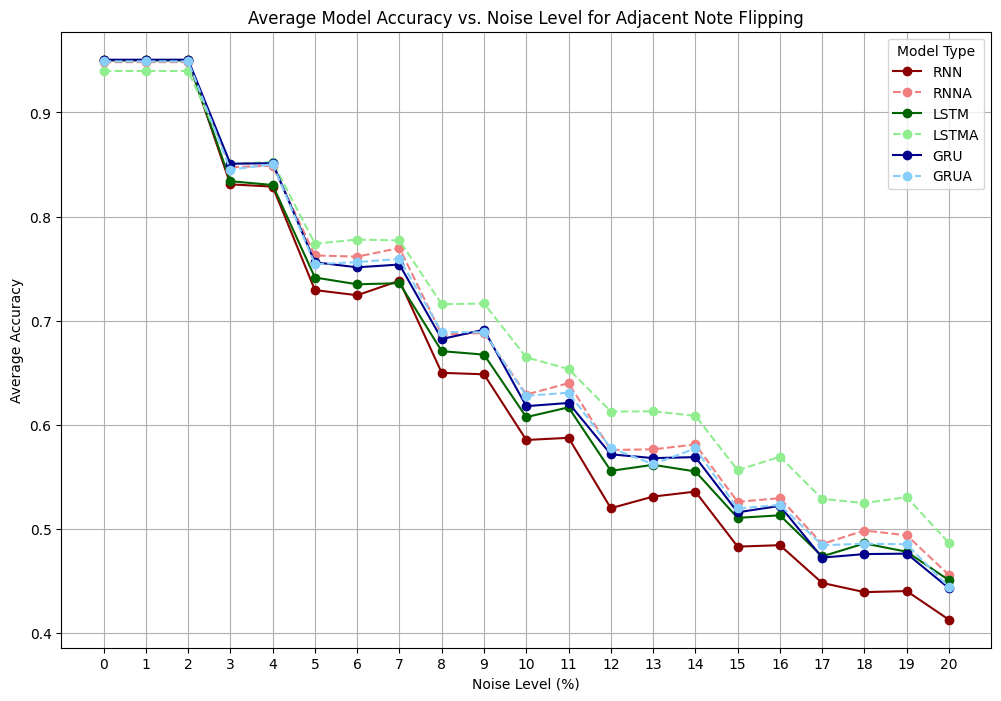

In [77]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming the evaluate_model_with_noise function is defined as before

# Model kinds and settings
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
noise_levels = list(range(21))  # 0% to 10% noise

# Initialize a dictionary to store the cumulative accuracies for averaging
cumulative_results = {kind: np.zeros(len(noise_levels)) for kind in kinds}

# Iterate over each model kind and repetition
for kind in kinds:
    print(f"Evaluating models of type: {kind}")
    for rep in range(num_reps):
        model_path = f'./dataModelsSongs/{kind}_{rep}.model'
        model = torch.load(model_path)
        model.eval()  # Ensure the model is in evaluation mode
        temp_results = evaluate_model_with_noise(model, songStrings, 4, noise_levels)
        
        # Accumulate accuracies for later averaging
        cumulative_results[kind] += np.array(temp_results['accuracy'])
    
    # Calculate the average by dividing by the number of repetitions
    cumulative_results[kind] /= num_reps


plot_styles = {
    "RNN": {"color": "darkred", "linestyle": "-"},
    "RNNA": {"color": "lightcoral", "linestyle": "--"},
    "LSTM": {"color": "darkgreen", "linestyle": "-"},
    "LSTMA": {"color": "lightgreen", "linestyle": "--"},
    "GRU": {"color": "darkblue", "linestyle": "-"},
    "GRUA": {"color": "lightskyblue", "linestyle": "--"}
}

# Plotting the results with specified colors and line styles
plt.figure(figsize=(12, 8))
for kind, accuracies in cumulative_results.items():
    plt.plot(noise_levels, accuracies, marker='o', label=kind, **plot_styles[kind])

plt.title('Average Model Accuracy vs. Noise Level for Adjacent Note Flipping')
plt.xlabel('Noise Level (%)')
plt.ylabel('Average Accuracy')
plt.legend(title='Model Type')
plt.xticks(noise_levels)    
plt.grid(True)
plt.show()


Evaluating models of type: TF
Noise Level: 0%, Accuracy: 0.7573
Noise Level: 1%, Accuracy: 0.7573
Noise Level: 2%, Accuracy: 0.7573
Noise Level: 3%, Accuracy: 0.6974
Noise Level: 4%, Accuracy: 0.6912
Noise Level: 5%, Accuracy: 0.6667
Noise Level: 6%, Accuracy: 0.6581
Noise Level: 7%, Accuracy: 0.6314
Noise Level: 8%, Accuracy: 0.6209
Noise Level: 9%, Accuracy: 0.6156
Noise Level: 10%, Accuracy: 0.5553
Noise Level: 11%, Accuracy: 0.5714
Noise Level: 12%, Accuracy: 0.5755
Noise Level: 13%, Accuracy: 0.5254
Noise Level: 14%, Accuracy: 0.5314
Noise Level: 15%, Accuracy: 0.5433
Noise Level: 16%, Accuracy: 0.5388
Noise Level: 17%, Accuracy: 0.4501
Noise Level: 18%, Accuracy: 0.4582
Noise Level: 19%, Accuracy: 0.5167
Noise Level: 20%, Accuracy: 0.4241
Noise Level: 0%, Accuracy: 0.7305
Noise Level: 1%, Accuracy: 0.7305
Noise Level: 2%, Accuracy: 0.7305
Noise Level: 3%, Accuracy: 0.6757
Noise Level: 4%, Accuracy: 0.6826
Noise Level: 5%, Accuracy: 0.6222
Noise Level: 6%, Accuracy: 0.6555
Noise L

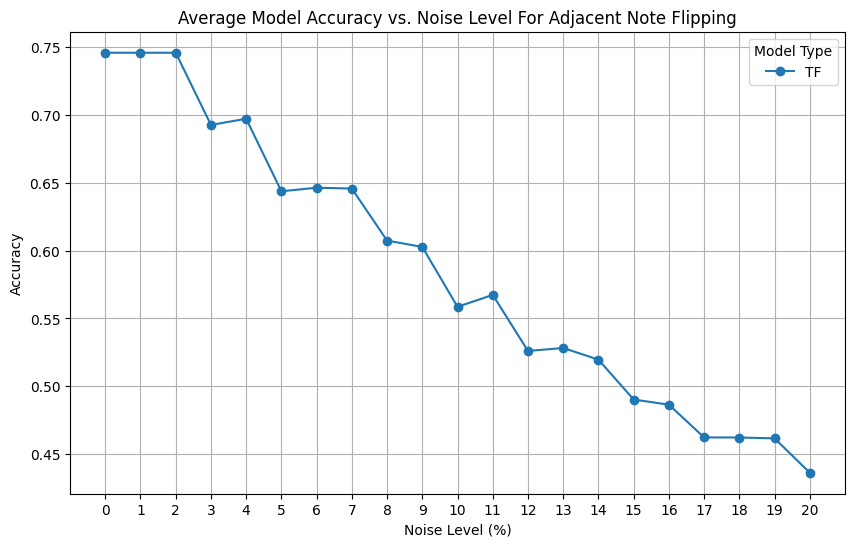

In [78]:
kinds = ["TF"]
num_reps = 50
noise_levels = list(range(21))  # 0% to 10% noise

# Initialize a dictionary to store the cumulative accuracies for averaging
cumulative_results = {kind: np.zeros(len(noise_levels)) for kind in kinds}

# Evaluate model performance with varying noise levels
def evaluate_with_noise(model, songStrings, nrOfSongs, noise_levels):
    results = []

    for noise_level in noise_levels:
        # Apply noise to each song string
        noisy_songStrings = np.array([flip_adjacent_notes(song, noise_level) for song in songStrings])
        
        # Generate data with noisy song strings
        source, target, _ = getTrainingData(noisy_songStrings, nrOfSongs)
        
        # Evaluate the model's accuracy on this noisy data
        accuracy = test(model, source, target)
        results.append(accuracy)
        
        print(f"Noise Level: {noise_level}%, Accuracy: {accuracy:.4f}")

    return results

# Main evaluation loop for Transformer models
for kind in kinds:
    print(f"Evaluating models of type: {kind}")
    for rep in range(num_reps):
        model_path = f'./dataModelsSongs/{kind}_{rep}.model'
        model = torch.load(model_path)
        model.eval()  # Ensure the model is in evaluation mode

        # Evaluate this model across all noise levels
        accuracy_results = evaluate_with_noise(model, songStrings, 4, noise_levels)
        
        # Accumulate the results
        cumulative_results[kind] += np.array(accuracy_results)
    
    # Average the results over all repetitions
    cumulative_results[kind] /= num_reps

# Plotting the results for each model kind
plt.figure(figsize=(10, 6))
for kind, accuracies in cumulative_results.items():
    plt.plot(noise_levels, accuracies, marker='o', linestyle='-', label=kind)

plt.title('Average Model Accuracy vs. Noise Level For Adjacent Note Flipping')
plt.xlabel('Noise Level (%)')
plt.ylabel('Accuracy')
plt.legend(title='Model Type')
plt.grid(True)
plt.xticks(noise_levels)
plt.show()

In [13]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'./dataModelsSongs/TF_22.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.7457897793263647

# Catastrophic Forgetting


In [83]:
def read_csv(model_name, iteration):
    # Construct the file path based on the model name and iteration
    file_name = f"acc_{model_name}_{iteration}.csv"
    file_path = os.path.join('dataCF', file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load and return the data if the file exists
        return pd.read_csv(file_path)
    else:
        # Return None or an empty DataFrame if the file does not exist
        return pd.DataFrame()

In [85]:
def myEval(S):
    S=S[1:-1]
    W=[]
    for s in S.split(","):
        W.append(float(s))
    return W


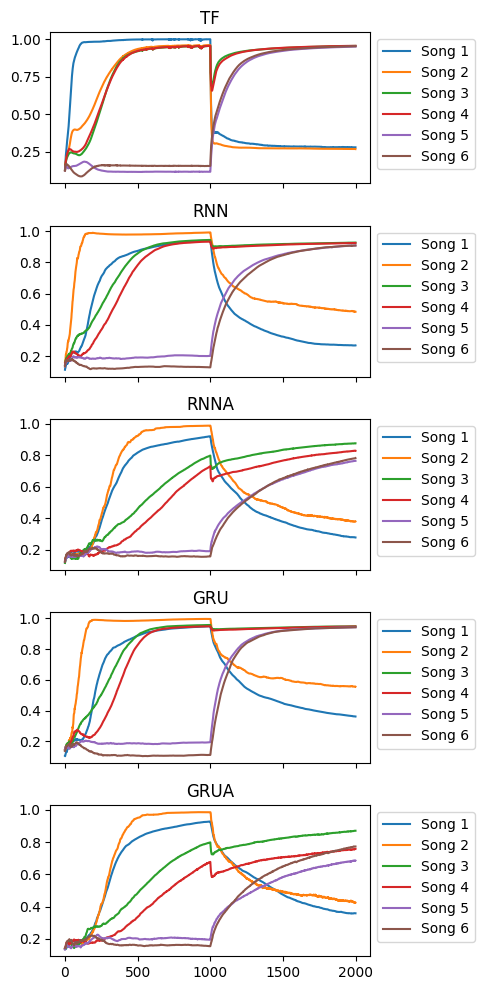

In [86]:

modelNames=["TF","RNN","RNNA","GRU","GRUA"]

# We'll use the plt.subplots function to create a figure and a set of subplots
fig, axs = plt.subplots(len(modelNames), 1, figsize=[5, 10], sharex=True)

for m, mn in enumerate(modelNames):
    # Initialize matrices to hold the data for the current model
    M = [[] for _ in range(6)]  # Six lists for six songs
    
    # Process files for each model, assuming a range of 50 iterations (demonstrated for GRU)
    for n in range(50):  # We would loop over available files/iterations
        data = read_csv(mn, n)
        if not data.empty:
            Ws = [[] for _ in range(6)]  # Temporary storage for the current file's data

            # Iterate over the 'acc' column, parsing each row's data
            for i in range(len(data)):
                W = myEval(data["acc"][i])
                for j in range(6):
                    Ws[j].append(W[j])

            # Convert lists to numpy arrays for easier manipulation
            Ws = np.array(Ws)

            # Aggregate the data
            for j in range(6):
                M[j].append(Ws[j])  # Append the data for each song

    # Convert M to a numpy array for further processing (like mean calculation)
    M = np.array(M)

    # Plotting the mean accuracy for each song in the current model
    for j in range(6):
        if M.shape[1] > 0:
            mean_accuracy = np.mean(M[j], axis=0)
            axs[m].plot(mean_accuracy, label=f"Song {j+1}")

    axs[m].set_title(mn)
    # Move the legend outside the plot area on the right side
    axs[m].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust this value based on your figure's needs
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tens

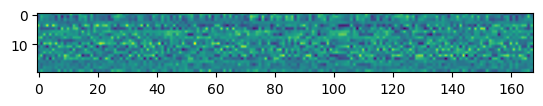

In [89]:
# Assuming the TransformerModel class and other model classes have been defined correctly
ntokens = 8  # Assuming 8 unique tokens (notes)
emsize = 20  # Embedding dimension
nhead = 4  # Number of heads in the nn.MultiheadAttention
d_hid = 20  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.00  # Dropout probability

models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "GRU": GRU(),
    "GRUA": GRUA(),
    "TF": TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
}

nrOfSongs = 4
source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
model_matrices = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_reps = 50
epochs = [1000, 2000]
kinds = models.keys()  # Assuming you meant to iterate over the keys of the models dictionary

for epoch in epochs:
    if epoch == 1000:
        source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
    else:
        source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings[2:])

    for kind in kinds:
        if kind == "TF":
            if epoch == 1000:
                source, target, songs = getTrainingData(songStrings, nrOfSongs)
            else:
                source, target, songs = getTrainingData(songStrings[2:], nrOfSongs)
        for rep in range(num_reps):
            model_identifier = f'{kind}-{epoch}-{rep}'

            # Adjusted code to handle state dictionary loading
            state_dict = torch.load(f'./dataCF/{kind}_{epoch}_{rep}.model')
            
            # Ensure the model is re-instantiated for each kind and correctly configured for TF
            if kind == "TF":
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
            elif kind == "RNN":
                model = RNN()
            elif kind == "RNNA":
                model = RNNA()
            elif kind == "GRU":
                model = GRU()
            elif kind == "GRUA":
                model = GRUA()

            model.to(device)  # Move the model to the appropriate device

            model.load_state_dict(state_dict)
            model.eval()  # Set the model to evaluation mode

            s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20, model_name=kind)
            M = removalIntoMatrix(s, 20, h)
            model_matrices[model_identifier] = M

In [67]:

with open('model_songs_matrices_CF.pkl', 'wb') as file:
    pickle.dump(model_matrices, file)

In [113]:
with open('model_songs_matrices_CF.pkl', 'rb') as file:
    model_matrices = pickle.load(file)

In [114]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

    Model Identifier                                             Matrix
0         RNN-1000-0  [[0.32601592850992045, 0.7675683658157793, 0.1...
1         RNN-1000-1  [[0.737318214048388, 0.16236003082120742, 0.74...
2         RNN-1000-2  [[0.006340537900773491, 0.811243670560267, 0.3...
3         RNN-1000-3  [[0.7671822764019014, 0.6983263448871968, 0.0,...
4         RNN-1000-4  [[0.7279616360696384, 0.811141210182952, 0.458...
..               ...                                                ...
495       TF-2000-45  [[-0.05186932196084282, 0.14624387572899078, 0...
496       TF-2000-46  [[0.05150061161412012, 0.022603272493446624, 0...
497       TF-2000-47  [[-0.005998115990765385, 0.11417789219340424, ...
498       TF-2000-48  [[0.14145263725260904, 0.18907168487165826, 0....
499       TF-2000-49  [[-0.04335257956026961, 0.11284166514837235, 0...

[500 rows x 2 columns]


In [115]:
results = []


for index, row in models_M.iterrows():
    model_identifier = row['Model Identifier']
    M = row['Matrix']
    kind,epoch ,rep = model_identifier.split('-')                
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)

    threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
    threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

    binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
    binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
    binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
    binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)

    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

    degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

    min_values = np.min(binarized_combined_matrix, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this

    # Counting the number of 1's in each column
    ones_count = np.sum(binarized_combined_matrix, axis=0)
    # Calculating the overlap percentage for each column
    # Initialize the overlap percentage array
    overlap_percentage_per_column = np.zeros(ones_count.shape)
    # Setting the overlap percentage based on the number of 1's in each column
    overlap_percentage_per_column[ones_count == 2] = .5
    overlap_percentage_per_column[ones_count == 3] = .75
    overlap_percentage_per_column[ones_count == 4] = 1
    # Calculating the overall overlap percentage across all columns
    overall_overlap_percentage = (np.sum(overlap_percentage_per_column) / (ones_count.shape[0])) * 100

  
    
    metrics = {
        "Kind": kind,
        "epoch":int(epoch),
        "Repetition": int(rep),
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans_song_1_treshold": round(threshold_song_1,4),
        "Kmeans_song_2_treshold": round(threshold_song_2,4),
        "Kmeans_song_3_treshold": round(threshold_song_3,4),
        "Kmeans_song_4_treshold": round(threshold_song_4,4),
        "Song_1_Nodes_exceeding_treshold": count_exceeding_song_1,
        "Song_2_Nodes_exceeding_treshold": count_exceeding_song_2,
        "Song_3_Nodes_exceeding_treshold": count_exceeding_song_3,
        "Song_4_Nodes_exceeding_treshold": count_exceeding_song_4,
        "Total_Nodes_exceeding_treshold": count_exceeding_song_1 + count_exceeding_song_2 + count_exceeding_song_3 + count_exceeding_song_4,
        "degree_2_overlapp": degree_2,
        "degree_3_overlapp": degree_3,
        "degree_4_overlapp": degree_4,
        "sum_of_degree_overlapp": degree_2 + degree_3 + degree_4,
        "Total_Overlapp_percentage" : overall_overlap_percentage,
        "overlapp_column1":overlap_percentage_per_column[0],
        "overlapp_column2":overlap_percentage_per_column[1],
        "overlapp_column3":overlap_percentage_per_column[2],
        "overlapp_column4":overlap_percentage_per_column[3],
        "overlapp_column5":overlap_percentage_per_column[4],
        "overlapp_column6":overlap_percentage_per_column[5],
        "overlapp_column7":overlap_percentage_per_column[6],
        "overlapp_column8":overlap_percentage_per_column[7],
        "overlapp_column9":overlap_percentage_per_column[8],
        "overlapp_column10":overlap_percentage_per_column[9],
        "overlapp_column11":overlap_percentage_per_column[10],
        "overlapp_column12":overlap_percentage_per_column[11],
        "overlapp_column13":overlap_percentage_per_column[12],
        "overlapp_column14":overlap_percentage_per_column[13],
        "overlapp_column15":overlap_percentage_per_column[14],
        "overlapp_column16":overlap_percentage_per_column[15],
        "overlapp_column17":overlap_percentage_per_column[16],
        "overlapp_column18":overlap_percentage_per_column[17],
        "overlapp_column19":overlap_percentage_per_column[18],
        "overlapp_column20":overlap_percentage_per_column[19],
    
    }
    num_songs = 4
    # Assuming all songs have the same number of features/columns for simplicity
    num_columns = binarized_matrix_song_1.shape[0]  # Number of columns/features per song

    # Dictionary to store pairwise "11" overlaps for each song pair across all columns
    pair_11_overlaps = {}
    count = 0
    # Iterate through all song combinations
    for (i, j) in itertools.combinations(range(num_songs), 2):
        # Initialize a count for each song pair
        pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] = 0

        # For each column, check if both songs have a "1" in the same position
        for col in range(num_columns):
            if binarized_combined_matrix[i, col] == 1 and binarized_combined_matrix[j, col] == 1:
                # If both songs have "1" in the same column, increment the count
                pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] += 1
    # Update the metrics dictionary to include the "11" overlaps
    metrics.update(pair_11_overlaps)
    vector_song_1 = binarized_matrix_song_1.flatten()
    vector_song_2 = binarized_matrix_song_2.flatten()
    vector_song_3 = binarized_matrix_song_3.flatten()
    vector_song_4 = binarized_matrix_song_4.flatten()
    count = 0
    for i in pair_11_overlaps.values():
        count+=i
    #metrics['total_pairwise_overlap_count'] = count
    #metrics["Binarized_Vector_Song_1"] = vector_song_1.tolist()
    #metrics["Binarized_Vector_Song_2"] = vector_song_2.tolist()
    #metrics["Binarized_Vector_Song_3"] = vector_song_3.tolist()
    #metrics["Binarized_Vector_Song_4"] = vector_song_4.tolist()

  
    results.append(metrics)
    
    
df = pd.DataFrame(results)


In [116]:
df

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0    RNN   1000           0                 36.3929      0.4549   
1    RNN   1000           1                 38.5919      0.4824   
2    RNN   1000           2                 39.2224      0.4903   
3    RNN   1000           3                 38.0316      0.4754   
4    RNN   1000           4                 39.0099      0.4876   
..   ...    ...         ...                     ...         ...   
495   TF   2000          45                 26.7457      0.3296   
496   TF   2000          46                 25.3140      0.3129   
497   TF   2000          47                 26.5843      0.3300   
498   TF   2000          48                 29.0058      0.3592   
499   TF   2000          49                 27.8486      0.3434   

     Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0                0.2905         0.8113         0.0000                  0.3863   
1                0.2991         0.8111         0.0000                  0.4337   
2                0.3000         0.8113         0.0000                  0.4069   
3                0.2945         0.8113         0.0000                  0.3871   
4                0.3013         0.8112         0.0000                  0.4166   
..                  ...            ...            ...                     ...   
495              0.2922         0.7948        -0.0519                  0.0609   
496              0.2981         0.8113        -0.0337                  0.0263   
497              0.3084         0.8110        -0.0262                  0.0481   
498              0.3106         0.8113        -0.0437                  0.0828   
499              0.3074         0.8112        -0.0548                  0.0574   

     Kmeans_song_2_treshold  ...  overlapp_column17  overlapp_column18  \
0                    0.4065  ...               0.50               0.50   
1                    0.4124  ...               0.00               0.75   
2                    0.4283  ...               0.75               1.00   
3                    0.4237  ...               1.00               1.00   
4                    0.3805  ...               1.00               0.75   
..                      ...  ...                ...                ...   
495                  0.3913  ...               0.50               0.75   
496                  0.3745  ...               1.00               0.50   
497                  0.3793  ...               0.50               0.75   
498                  0.4066  ...               0.50               0.50   
499                  0.4150  ...               0.75               0.75   

     overlapp_column19  overlapp_column20  song_1_song_2_11_overlap  \
0                 0.50               0.50                         9   
1                 0.50               0.75                         9   
2                 0.00               0.75                         9   
3                 0.00               0.75                         9   
4                 0.75               0.50                         8   
..                 ...                ...                       ...   
495               0.50               0.50                         4   
496               0.75               0.75                         6   
497               0.00               0.75                         5   
498               0.75               0.50                         7   
499               0.50               0.75                         7   

     song_1_song_3_11_overlap  song_1_song_4_11_overlap  \
0                           6                         7   
1                           6                         9   
2                           9                        10   
3                           7                         7   
4                          10                         9   
..                        ...                       ...   
495                         6                         4   
496         

In [82]:
df.to_csv("songs_cf.csv", index=False)

In [39]:
df = pd.read_csv("songs_cf.csv")

In [40]:
df[(df['Kind'] == 'RNN') & (df['epoch'] == 1000)]

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0   RNN   1000           0                 36.3929      0.4549   
1   RNN   1000           1                 38.5919      0.4824   
2   RNN   1000           2                 39.2224      0.4903   
3   RNN   1000           3                 38.0316      0.4754   
4   RNN   1000           4                 39.0099      0.4876   
5   RNN   1000           5                 38.3146      0.4789   
6   RNN   1000           6                 39.2124      0.4902   
7   RNN   1000           7                 38.4118      0.4801   
8   RNN   1000           8                 39.4104      0.4926   
9   RNN   1000           9                 37.8346      0.4729   
10  RNN   1000          10                 38.4253      0.4803   
11  RNN   1000          11                 37.7742      0.4721   
12  RNN   1000          12                 39.5746      0.4947   
13  RNN   1000          13                 37.9589      0.4745   
14  RNN   1000          14                 38.2689      0.4784   
15  RNN   1000          15                 39.5287      0.4941   
16  RNN   1000          16                 40.0389      0.5005   
17  RNN   1000          17                 39.4076      0.4926   
18  RNN   1000          18                 38.3765      0.4797   
19  RNN   1000          19                 40.5600      0.5070   
20  RNN   1000          20                 38.4933      0.4811   
21  RNN   1000          21                 36.9299      0.4614   
22  RNN   1000          22                 39.6029      0.4950   
23  RNN   1000          23                 36.2461      0.4529   
24  RNN   1000          24                 39.3087      0.4914   
25  RNN   1000          25                 38.2974      0.4787   
26  RNN   1000          26                 39.8732      0.4984   
27  RNN   1000          27                 36.9290      0.4616   
28  RNN   1000          28                 35.4668      0.4432   
29  RNN   1000          29                 38.1928      0.4773   
30  RNN   1000          30                 38.1660      0.4771   
31  RNN   1000          31                 38.1465      0.4768   
32  RNN   1000          32                 38.5119      0.4814   
33  RNN   1000          33                 37.2108      0.4651   
34  RNN   1000          34                 37.4493      0.4681   
35  RNN   1000          35                 39.4916      0.4936   
36  RNN   1000          36                 37.5027      0.4688   
37  RNN   1000          37                 38.6811      0.4835   
38  RNN   1000          38                 37.7699      0.4721   
39  RNN   1000          39                 38.8325      0.4854   
40  RNN   1000          40                 38.4840      0.4810   
41  RNN   1000          41                 38.9651      0.4869   
42  RNN   1000          42                 39.2455      0.4906   
43  RNN   1000          43                 39.0183      0.4877   
44  RNN   1000          44                 38.7732      0.4847   
45  RNN   1000          45                 39.4396      0.4930   
46  RNN   1000          46                 38.7416      0.4843   
47  RNN   1000          47                 38.8143      0.4852   
48  RNN   1000          48                 37.2883      0.4661   
49  RNN   1000          49                 37.8601      0.4733   

    Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0               0.2905         0.8113         0.0000                  0.3863   
1               0.2991         0.8111         0.0000                  0.4337   
2               0.3000         0.8113         0.0000                  0.4069   
3               0.2945         0.8113         0.0000                  0.3871   
4               0.3013         0.8112         0.0000                  0.4166   
5               0.2984         0.8113         0.0000                  0.4446   
6               0.3023         0.8113         0.0000                  0.4241

In [41]:
models = ["RNN", "RNNA", "GRU", "GRUA", "TF"]
averages = []

for model in models:
    # For epoch 1000
    data_1000 = df[(df['Kind'] == model) & (df['epoch'] == 1000)]
    avg_1000 = data_1000['song_3_song_4_11_overlap'].mean()
    
    # For epoch 2000
    data_2000 = df[(df['Kind'] == model) & (df['epoch'] == 2000)]
    avg_2000 = data_2000['song_1_song_2_11_overlap'].mean()
    
    averages.append((avg_1000, avg_2000))


In [42]:
avg_1000

6.54

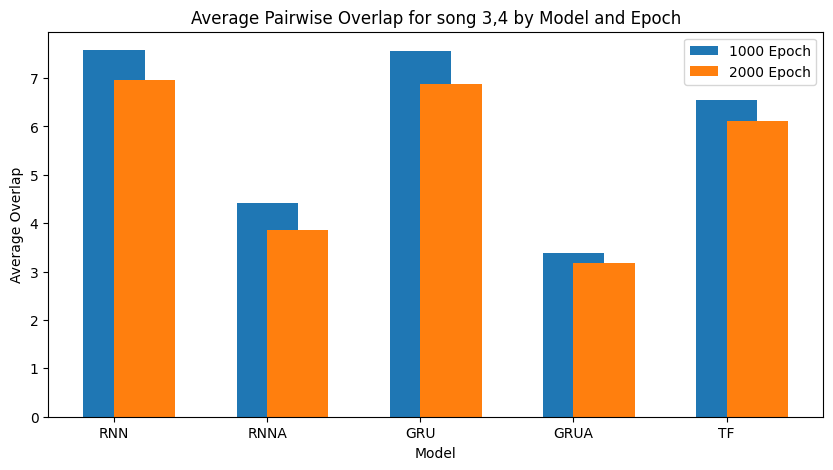

In [43]:
import matplotlib.pyplot as plt

# Assuming averages is a list of tuples where each tuple contains (avg_1000, avg_2000) for a model
x = range(len(models))  # Model indices
avg_1000, avg_2000 = zip(*averages)  # Unzip averages into two lists

plt.figure(figsize=(10, 5))
plt.bar(x, avg_1000, width=0.4, label='1000 Epoch', align='center')
plt.bar(x, avg_2000, width=0.4, label='2000 Epoch', align='edge')
plt.xlabel('Model')
plt.ylabel('Average Overlap')
plt.xticks(x, models)
plt.legend()
plt.title('Average Pairwise Overlap for song 3,4 by Model and Epoch')
plt.show()


In [44]:
models = ["RNN", "RNNA", "GRU", "GRUA", "TF"]
averages = []

for model in models:
    # For epoch 1000
    song_1000_song_3 = df[(df['Kind'] == model) & (df['epoch'] == 1000)]
    avg_song_3 = song_1000_song_3['Song_3_Nodes_exceeding_treshold'].mean()
    
    song_1000_song_4 = df[(df['Kind'] == model) & (df['epoch'] == 1000)]
    avg_song_4 = song_1000_song_4['Song_4_Nodes_exceeding_treshold'].mean()

    # For epoch 2000
    data_2000__song_1 = df[(df['Kind'] == model) & (df['epoch'] == 2000)]
    avg_song_1 = data_2000__song_1['Song_1_Nodes_exceeding_treshold'].mean()
    
    data_2000__song_1 = df[(df['Kind'] == model) & (df['epoch'] == 2000)]
    avg_song_2 = data_2000__song_1['Song_2_Nodes_exceeding_treshold'].mean()

    averages.append((avg_song_3, avg_song_4, avg_song_1, avg_song_2))


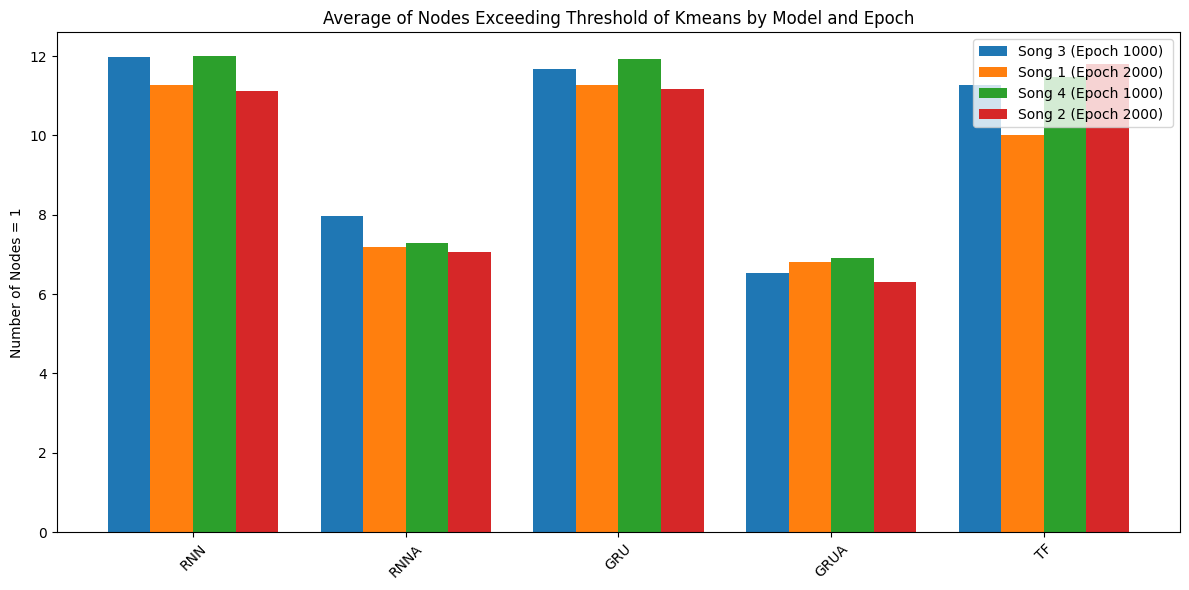

In [45]:
# Since I'm unable to directly access the CSV content, the following code snippet is a continuation
# based on your provided logic and aims to plot the calculated averages.

import matplotlib.pyplot as plt
import numpy as np

# Convert the list of tuples into a numpy array for easier manipulation
averages_array = np.array(averages)

# Extract individual averages for plotting
avg_song_3_1000 = averages_array[:, 0]
avg_song_4_1000 = averages_array[:, 1]
avg_song_1_2000 = averages_array[:, 2]
avg_song_2_2000 = averages_array[:, 3]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2 - width, avg_song_3_1000, width, label='Song 3 (Epoch 1000)')
rects2 = ax.bar(x - width/2,  avg_song_1_2000, width, label='Song 1 (Epoch 2000)')
rects3 = ax.bar(x + width/2, avg_song_4_1000, width, label='Song 4 (Epoch 1000) ')
rects4 = ax.bar(x + width/2 + width,  avg_song_2_2000  , width, label='Song 2 (Epoch 2000)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Nodes = 1')
ax.set_title('Average of Nodes Exceeding Threshold of Kmeans by Model and Epoch')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


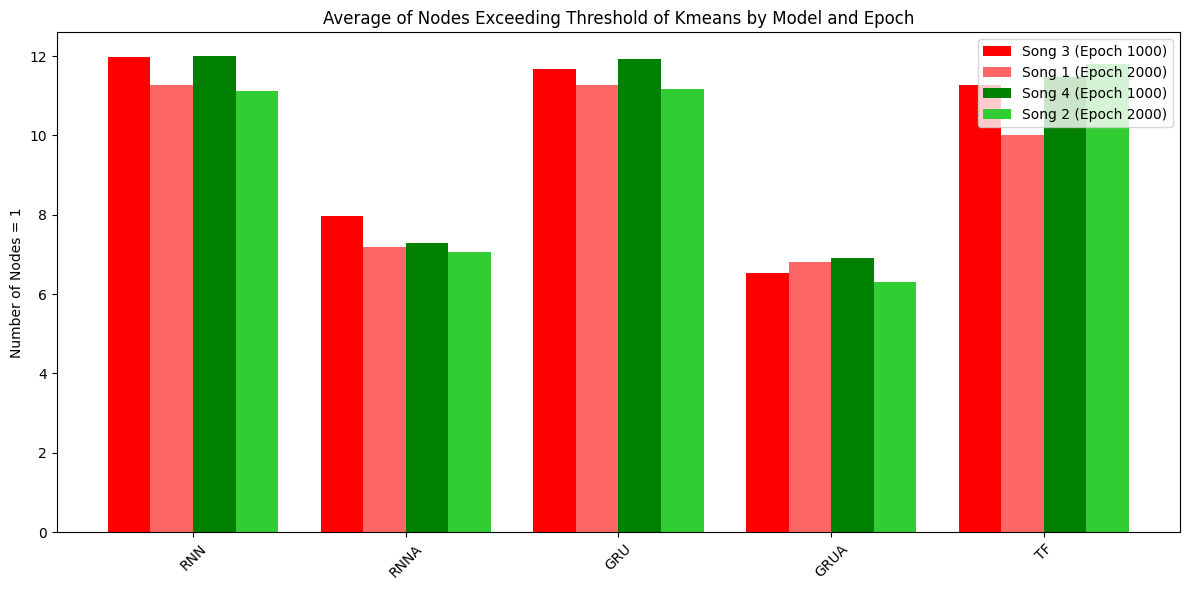

In [46]:
# Adjusting the plotting code to use specified colors for the bars
fig, ax = plt.subplots(figsize=(12, 6))

# Using red and green colors for the bars, with brighter versions for the 2000 epoch
colors = ['#FF0000', '#008000']  # Base colors: red for epoch 1000, darker green for epoch 2000
bright_colors = ['#FF6666', '#32CD32']  #  Brighter versions for differentiation

# Plotting the bars with specified colors
rects1 = ax.bar(x - width/2 - width, avg_song_3_1000, width, label='Song 3 (Epoch 1000)', color=colors[0])
rects2 = ax.bar(x - width/2, avg_song_1_2000, width, label='Song 1 (Epoch 2000)', color=bright_colors[0])
rects3 = ax.bar(x + width/2, avg_song_4_1000, width, label='Song 4 (Epoch 1000)', color=colors[1])
rects4 = ax.bar(x + width/2 + width, avg_song_2_2000, width, label='Song 2 (Epoch 2000)', color=bright_colors[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Nodes = 1')
ax.set_title('Average of Nodes Exceeding Threshold of Kmeans by Model and Epoch')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [49]:
data_epoch_1000 = df[(df['Kind'] == 'RNN') & (df['epoch'] == 1000) & (df['Repetition'] == 2)]
data_epoch_1000

Empty DataFrame
Columns: [Kind, epoch, Repetition, Sum of Absolute Values, Mean Value, Standard Deviation, Maximum Value, Minimum Value, Kmeans_song_1_treshold, Kmeans_song_2_treshold, Kmeans_song_3_treshold, Kmeans_song_4_treshold, Song_1_Nodes_exceeding_treshold, Song_2_Nodes_exceeding_treshold, Song_3_Nodes_exceeding_treshold, Song_4_Nodes_exceeding_treshold, Total_Nodes_exceeding_treshold, degree_2_overlapp, degree_3_overlapp, degree_4_overlapp, sum_of_degree_overlapp, Total_Overlapp_percentage, overlapp_column1, overlapp_column2, overlapp_column3, overlapp_column4, overlapp_column5, overlapp_column6, overlapp_column7, overlapp_column8, overlapp_column9, overlapp_column10, overlapp_column11, overlapp_column12, overlapp_column13, overlapp_column14, overlapp_column15, overlapp_column16, overlapp_column17, overlapp_column18, overlapp_column19, overlapp_column20, song_1_song_2_11_overlap, song_1_song_3_11_overlap, song_1_song_4_11_overlap, song_2_song_3_11_overlap, song_2_song_4_11_overlap, song_3_song_4_11_overlap, total_pairwise_overlap_count, Binarized_Vector_Song_1, Binarized_Vector_Song_2, Binarized_Vector_Song_3, Binarized_Vector_Song_4]
Index: []

[0 rows x 53 columns]

In [50]:
import pandas as pd

# Assuming df is your original DataFrame and it's already defined

# Define the function to calculate the percentage of change
def calculate_percentage_of_change(vec1, vec2):
    assert len(vec1) == len(vec2), "Vectors must be of the same length."
    hamming_distance = sum(e1 != e2 for e1, e2 in zip(vec1, vec2))
    percentage_of_change = (hamming_distance / len(vec1)) * 100
    return percentage_of_change

# Placeholder for storing the results
change_results = []

# Iterate over each model kind
for kind in df['Kind'].unique():
    # Iterate over each epoch
    for epoch in df['epoch'].unique():
        # Iterate over each repetition
        for rep in range(50):  # Assuming repetitions are labeled from 0 to 49
            data_epoch_1000 = df[(df['Kind'] == kind) & (df['epoch'] == 1000) & (df['Repetition'] == rep)]
            data_epoch_2000 = df[(df['Kind'] == kind) & (df['epoch'] == 2000) & (df['Repetition'] == rep)]
            
            if not data_epoch_1000.empty and not data_epoch_2000.empty:
                # Get vectors to compare
                vec1_2000 = data_epoch_2000['Binarized_Vector_Song_1'].iloc[0]
                vec3_1000 = data_epoch_1000['Binarized_Vector_Song_3'].iloc[0]
                
                vec2_2000 = data_epoch_2000['Binarized_Vector_Song_2'].iloc[0]
                vec4_1000 = data_epoch_1000['Binarized_Vector_Song_4'].iloc[0]
                
                # Calculate percentage of change
                change_3_to_1 = calculate_percentage_of_change(vec3_1000, vec1_2000)
                change_4_to_2 = calculate_percentage_of_change(vec4_1000, vec2_2000)
                
                # Append results
                change_results.append({
                    'Kind': kind,
                    'Epoch': '1000-2000',
                    'Repetition': rep,
                    'Percentage of Change_3_to_1': change_3_to_1,
                    'Percentage of Change_4_to_2': change_4_to_2
                })

# Convert the results to a DataFrame
change_df = pd.DataFrame(change_results)

# Here you have change_df with the calculated percentage of change for each repetition


C:\Users\ahmad\AppData\Local\Temp\ipykernel_27476\700340442.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hamming_distance = sum(e1 != e2 for e1, e2 in zip(vec1, vec2))


In [51]:
change_df

Kind      Epoch  Repetition  Percentage of Change_3_to_1  \
0    RNN  1000-2000           0                    18.333333   
1    RNN  1000-2000           1                    11.666667   
2    RNN  1000-2000           2                    16.666667   
3    RNN  1000-2000           3                    21.666667   
4    RNN  1000-2000           4                     8.333333   
..   ...        ...         ...                          ...   
495   TF  1000-2000          45                    15.000000   
496   TF  1000-2000          46                    20.000000   
497   TF  1000-2000          47                     6.666667   
498   TF  1000-2000          48                    20.000000   
499   TF  1000-2000          49                    15.000000   

     Percentage of Change_4_to_2  
0                      16.666667  
1                      18.333333  
2                      16.666667  
3                      20.000000  
4                      15.000000  
..                           ...  
495                    25.000000  
496                    15.000000  
497                    18.333333  
498                    11.666667  
499                    18.333333  

[500 rows x 5 columns]

In [52]:
# Group by 'Kind' and calculate the mean of 'Change_3_to_1' and 'Change_4_to_2'
average_changes = change_df.groupby('Kind').agg({
    'Percentage of Change_3_to_1': 'mean',
    'Percentage of Change_4_to_2': 'mean'
}).reset_index()

average_changes


Kind  Percentage of Change_3_to_1  Percentage of Change_4_to_2
0   GRU                    14.400000                    14.100000
1  GRUA                    10.900000                    10.766667
2   RNN                    14.766667                    15.600000
3  RNNA                    12.366667                    10.933333
4    TF                    16.900000                    15.533333

In [134]:
data_epoch_1000 = df[df['epoch'] == 1000]

In [147]:
data_epoch_1000_overlap = data_epoch_1000[['Kind','Repetition','Total_Overlapp_percentage','epoch']]

In [127]:
import pandas as pd

# Adjusted function to output more detailed results suitable for DataFrame creation
def analyze_model_accuracies_songs_12(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    accuracies = data['acc'].apply(myEval).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Process each song's accuracy, focusing on Song 1 and Song 2 for this demonstration
                    for song_index in range(2):  # only process the first two songs for demonstration
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]

                        # Calculate 50% drop after 1000 epochs
                        initial_accuracy = song_accuracies[999]
                        drop_index = np.argmax(song_accuracies[1000:] <= initial_accuracy * 0.5) + 1000
                        final_accuracy = song_accuracies[-1]

                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch at 50% Drop": drop_index,
                            "Final Accuracy": final_accuracy
                        })

    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models and create a DataFrame
df_model_accuracies_songs_12 = analyze_model_accuracies_songs_12(model_names)
df_model_accuracies_songs_12.head()


Kind  Repetition  Song  Epoch at 50% Drop  Final Accuracy
0   TF           0     1               1006        0.317073
1   TF           0     2               1006        0.307201
2   TF           1     1               1010        0.178862
3   TF           1     2               1010        0.290360
4   TF           2     1               1005        0.422764

In [148]:
df_model_accuracies_songs_12_merged = pd.merge(df_model_accuracies_songs_12, data_epoch_1000_overlap, on=['Kind', 'Repetition'])


In [149]:
df_model_accuracies_songs_12_merged

Kind  Repetition  Song  Epoch at 50% Drop  Final Accuracy  \
0      TF           0     1               1006        0.317073   
1      TF           0     2               1006        0.307201   
2      TF           1     1               1010        0.178862   
3      TF           1     2               1010        0.290360   
4      TF           2     1               1005        0.422764   
..    ...         ...   ...                ...             ...   
495  GRUA          47     2               1334        0.195122   
496  GRUA          48     1               1418        0.227642   
497  GRUA          48     2               1000        0.565041   
498  GRUA          49     1               1551        0.271196   
499  GRUA          49     2               1253        0.227642   

     Total_Overlapp_percentage  epoch  
0                        45.00   1000  
1                        45.00   1000  
2                        51.25   1000  
3                        51.25   1000  
4                        48.75   1000  
..                         ...    ...  
495                      26.25   1000  
496                      33.75   1000  
497                      33.75   1000  
498                      18.75   1000  
499                      18.75   1000  

[500 rows x 7 columns]

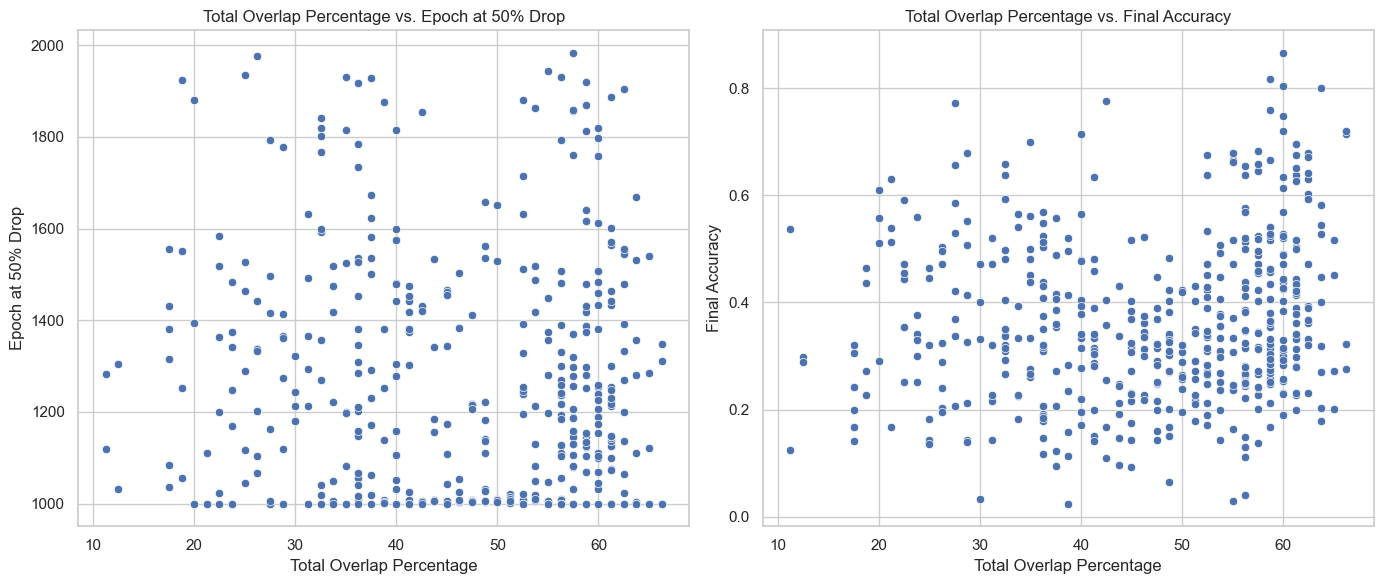

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_12_merged is already loaded and correct
# Setup the plotting environment
sns.set(style="whitegrid")

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Total_Overlap_Percentage vs Epoch at 50% Drop
sns.scatterplot(x='Total_Overlapp_percentage', y='Epoch at 50% Drop', data=df_model_accuracies_songs_12_merged, ax=axs[0])
axs[0].set_title('Total Overlap Percentage vs. Epoch at 50% Drop')
axs[0].set_xlabel('Total Overlap Percentage')
axs[0].set_ylabel('Epoch at 50% Drop')

# Plot Total_Overlap_Percentage vs Final Accuracy
sns.scatterplot(x='Total_Overlapp_percentage', y='Final Accuracy', data=df_model_accuracies_songs_12_merged, ax=axs[1])
axs[1].set_title('Total Overlap Percentage vs. Final Accuracy')
axs[1].set_xlabel('Total Overlap Percentage')
axs[1].set_ylabel('Final Accuracy')

# Display the plots
plt.tight_layout()
plt.show()


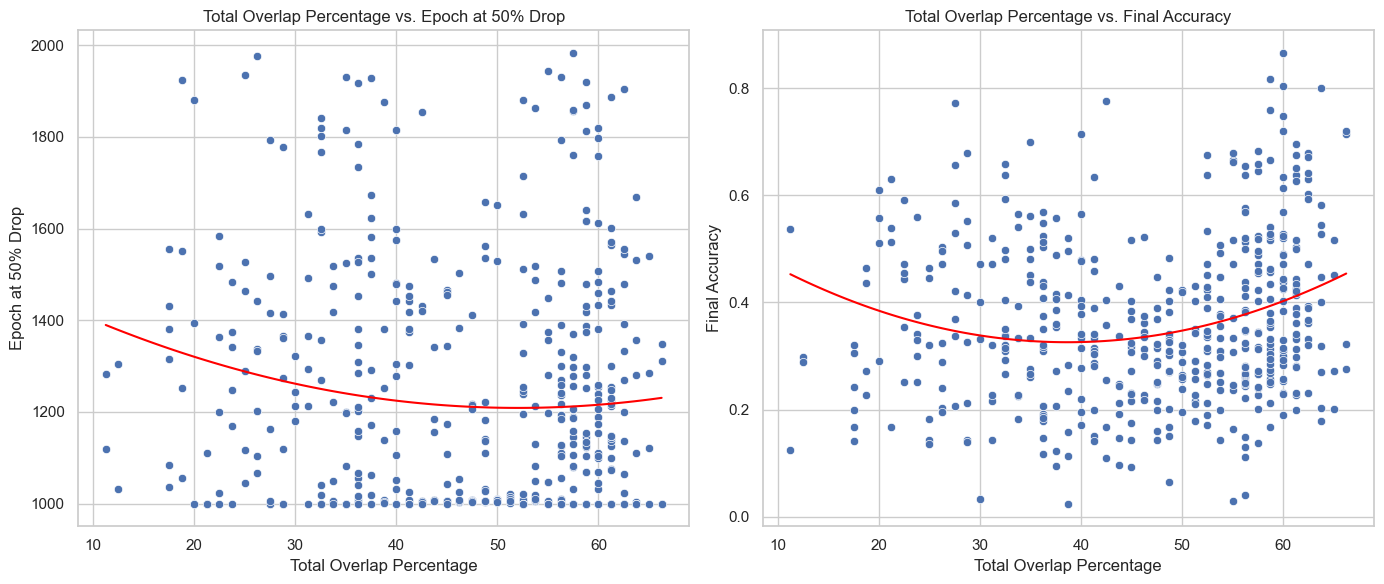

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_12_merged is already loaded
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Define a function to plot polynomial regression
def plot_poly_regression(x, y, ax, degree=2, title="", xlabel="", ylabel=""):
    # Scatter plot
    sns.scatterplot(x=x, y=y, data=df_model_accuracies_songs_12_merged, ax=ax)
    
    # Fit a polynomial regression of specified degree
    coeffs = np.polyfit(df_model_accuracies_songs_12_merged[x], df_model_accuracies_songs_12_merged[y], degree)
    # Generate a polynomial equation based on the coefficients
    poly_eq = np.poly1d(coeffs)
    # Generate x values (from min to max x in 100 steps)
    x_poly = np.linspace(df_model_accuracies_songs_12_merged[x].min(), df_model_accuracies_songs_12_merged[x].max(), 100)
    # Generate y values from the polynomial equation
    y_poly = poly_eq(x_poly)
    # Plot the regression line
    ax.plot(x_poly, y_poly, color='red')
    
    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Plot 1: Total_Overlap_Percentage vs Epoch at 50% Drop
plot_poly_regression('Total_Overlapp_percentage', 'Epoch at 50% Drop', axs[0], 
                     title='Total Overlap Percentage vs. Epoch at 50% Drop',
                     xlabel='Total Overlap Percentage', ylabel='Epoch at 50% Drop')

# Plot 2: Total_Overlap_Percentage vs Final Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Final Accuracy', axs[1], 
                     title='Total Overlap Percentage vs. Final Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Final Accuracy')

plt.tight_layout()
plt.show()


In [140]:
import os
import pandas as pd
import numpy as np

def analyze_simple_50_percent_reach_model_accuracies_songs_56(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    # Convert string accuracies to list of floats
                    accuracies = data['acc'].apply(lambda x: [float(n) for n in x.strip('[]').split(', ')]).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Focus on Song 5 and Song 6
                    for song_index in range(4, 6):  # indices 4 and 5 for Song 5 and 6
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]

                        # Determine the maximum accuracy from epoch 1000 onwards
                        max_accuracy_post_1000 = np.max(song_accuracies[1000:])
                        target_accuracy = max_accuracy_post_1000 * 0.5

                        # Calculate when accuracy reaches 50% of the max accuracy after epoch 1000
                        post_1000_accuracies = song_accuracies[1000:]
                        reach_50_index = np.where(post_1000_accuracies >= 0.5)[0][0] + 1000 if np.any(post_1000_accuracies >= 0.5) else 2000
                        
                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch to Reach 50% Accuracy": reach_50_index,
                            "Highest Accuracy": max_accuracy_post_1000
                        })
                        break
    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models for Songs 5 and 6 and create a DataFrame
df_simple_50_reach_accuracies_songs_56 = analyze_simple_50_percent_reach_model_accuracies_songs_56(model_names)
df_simple_50_reach_accuracies_songs_56.head()


Kind  Repetition  Song  Epoch to Reach 50% Accuracy  Highest Accuracy
0   TF           0     5                         1042          0.951220
1   TF           1     5                         1072          0.937863
2   TF           2     5                         1088          0.957607
3   TF           3     5                         1079          0.957607
4   TF           4     5                         1082          0.951220

In [150]:
df_model_accuracies_songs_56_merged = pd.merge(df_simple_50_reach_accuracies_songs_56, data_epoch_1000_overlap, on=['Kind', 'Repetition'])


In [151]:
df_model_accuracies_songs_56_merged

Kind  Repetition  Song  Epoch to Reach 50% Accuracy  Highest Accuracy  \
0      TF           0     5                         1042          0.951220   
1      TF           1     5                         1072          0.937863   
2      TF           2     5                         1088          0.957607   
3      TF           3     5                         1079          0.957607   
4      TF           4     5                         1082          0.951220   
..    ...         ...   ...                          ...               ...   
245  GRUA          45     5                         1113          0.906504   
246  GRUA          46     5                         1225          0.716609   
247  GRUA          47     5                         1320          0.703252   
248  GRUA          48     5                         1209          0.700929   
249  GRUA          49     5                         1462          0.699768   

     Total_Overlapp_percentage  epoch  
0                        45.00   1000  
1                        51.25   1000  
2                        48.75   1000  
3                        56.25   1000  
4                        38.75   1000  
..                         ...    ...  
245                      23.75   1000  
246                      27.50   1000  
247                      26.25   1000  
248                      33.75   1000  
249                      18.75   1000  

[250 rows x 7 columns]

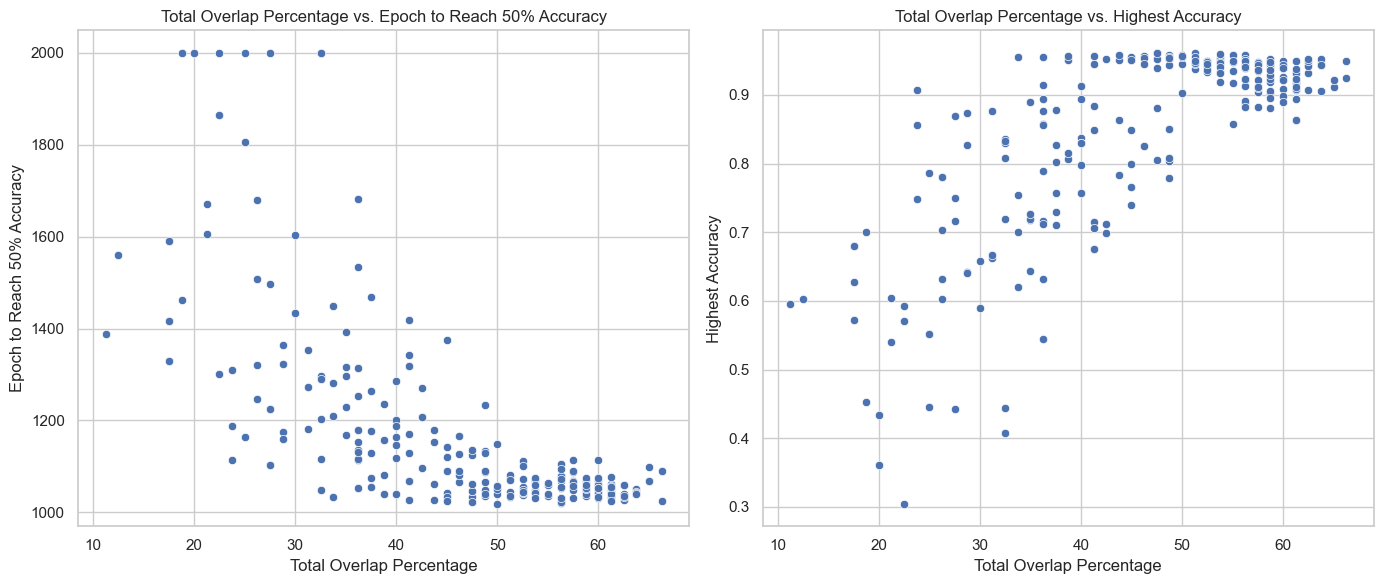

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_12_merged is already loaded and correct
# Setup the plotting environment
sns.set(style="whitegrid")

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Total_Overlap_Percentage vs Epoch at 50% Drop
sns.scatterplot(x='Total_Overlapp_percentage', y='Epoch to Reach 50% Accuracy', data=df_model_accuracies_songs_56_merged, ax=axs[0])
axs[0].set_title('Total Overlap Percentage vs. Epoch to Reach 50% Accuracy')
axs[0].set_xlabel('Total Overlap Percentage')
axs[0].set_ylabel('Epoch to Reach 50% Accuracy')

# Plot Total_Overlap_Percentage vs Final Accuracy
sns.scatterplot(x='Total_Overlapp_percentage', y='Highest Accuracy', data=df_model_accuracies_songs_56_merged, ax=axs[1])
axs[1].set_title('Total Overlap Percentage vs. Highest Accuracy')
axs[1].set_xlabel('Total Overlap Percentage')
axs[1].set_ylabel('Highest Accuracy')

# Display the plots
plt.tight_layout()
plt.show()


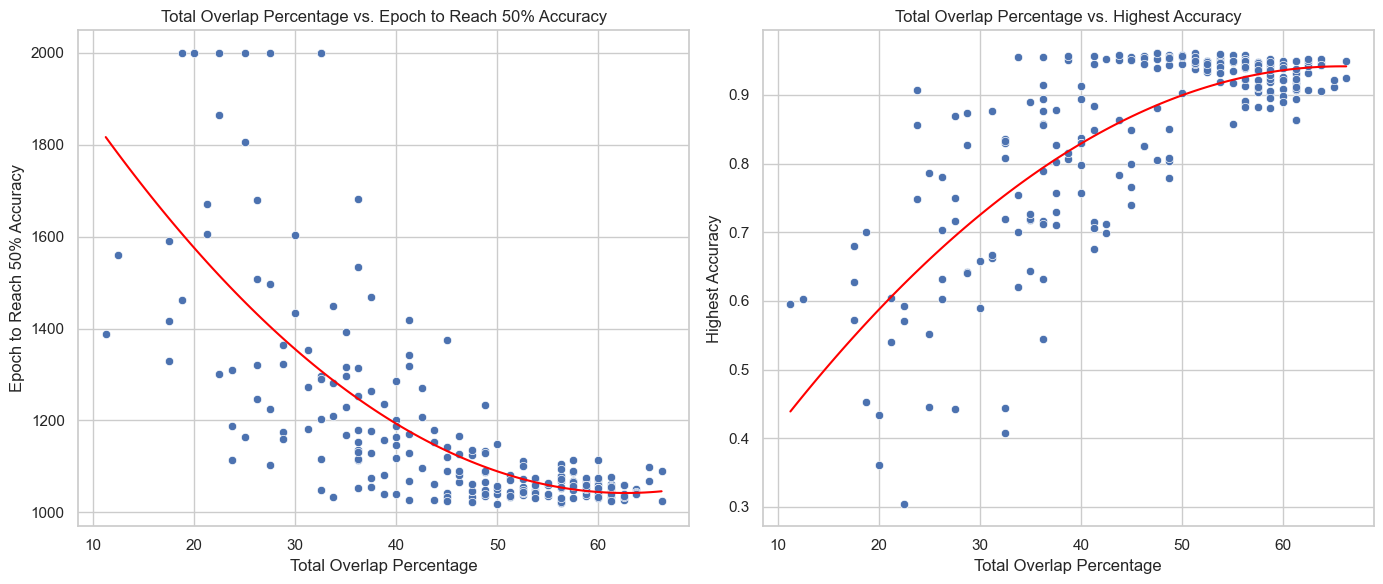

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_56_merged is already loaded
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Define a function to plot polynomial regression
def plot_poly_regression(x, y, ax, degree=2, title="", xlabel="", ylabel=""):
    # Scatter plot
    sns.scatterplot(x=x, y=y, data=df_model_accuracies_songs_56_merged, ax=ax)
    
    # Fit a polynomial regression of specified degree
    coeffs = np.polyfit(df_model_accuracies_songs_56_merged[x], df_model_accuracies_songs_56_merged[y], degree)
    # Generate a polynomial equation based on the coefficients
    poly_eq = np.poly1d(coeffs)
    # Generate x values (from min to max x in 100 steps)
    x_poly = np.linspace(df_model_accuracies_songs_56_merged[x].min(), df_model_accuracies_songs_56_merged[x].max(), 100)
    # Generate y values from the polynomial equation
    y_poly = poly_eq(x_poly)
    # Plot the regression line
    ax.plot(x_poly, y_poly, color='red')
    
    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Plot 1: Total_Overlap_Percentage vs Epoch to Reach 50% Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Epoch to Reach 50% Accuracy', axs[0], 
                     title='Total Overlap Percentage vs. Epoch to Reach 50% Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Epoch to Reach 50% Accuracy')

# Plot 2: Total_Overlap_Percentage vs Highest Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Highest Accuracy', axs[1], 
                     title='Total Overlap Percentage vs. Highest Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Highest Accuracy')

plt.tight_layout()
plt.show()


In [143]:
# Adjusted function to analyze Songs 3 and 4 as per new requirements
def analyze_model_accuracies_songs_34(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    accuracies = data['acc']. apply(myEval).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Focus on Song 3 and Song 4
                    for song_index in range(2, 4):  # indices 2 and 3 for Song 3 and 4
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]

                        # Calculate when accuracy reaches the lowest value after epoch 1000
                        lowest_accuracy = np.min(song_accuracies[1000:])
                        lowest_index = np.argmin(song_accuracies[1000:]) + 1000

                        # Determine the highest accuracy reached at the end
                        highest_accuracy = np.max(song_accuracies[1000:])

                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch at Lowest Accuracy": lowest_index,
                            "Lowest Accuracy": lowest_accuracy,
                            "Highest Accuracy": highest_accuracy
                        })

    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models for Songs 3 and 4 and create a DataFrame
df_model_accuracies_songs_34 = analyze_model_accuracies_songs_34(model_names)
df_model_accuracies_songs_34.head()


Kind  Repetition  Song  Epoch at Lowest Accuracy  Lowest Accuracy  \
0   TF           0     3                      1002         0.606852   
1   TF           0     4                      1018         0.590592   
2   TF           1     3                      1016         0.760743   
3   TF           1     4                      1016         0.586527   
4   TF           2     3                      1007         0.495354   

   Highest Accuracy  
0          0.955285  
1          0.955865  
2          0.955285  
3          0.955285  
4          0.961672

In [152]:
df_model_accuracies_songs_34_merged = pd.merge(df_model_accuracies_songs_34, data_epoch_1000_overlap, on=['Kind', 'Repetition'])


In [153]:
df_model_accuracies_songs_34_merged

Kind  Repetition  Song  Epoch at Lowest Accuracy  Lowest Accuracy  \
0      TF           0     3                      1002         0.606852   
1      TF           0     4                      1018         0.590592   
2      TF           1     3                      1016         0.760743   
3      TF           1     4                      1016         0.586527   
4      TF           2     3                      1007         0.495354   
..    ...         ...   ...                       ...              ...   
495  GRUA          47     4                      1014         0.442509   
496  GRUA          48     3                      1024         0.663763   
497  GRUA          48     4                      1015         0.638792   
498  GRUA          49     3                      1005         0.592334   
499  GRUA          49     4                      1006         0.470383   

     Highest Accuracy  Total_Overlapp_percentage  epoch  
0            0.955285                      45.00   1000  
1            0.955865                      45.00   1000  
2            0.955285                      51.25   1000  
3            0.955285                      51.25   1000  
4            0.961672                      48.75   1000  
..                ...                        ...    ...  
495          0.800813                      26.25   1000  
496          0.821138                      33.75   1000  
497          0.814170                      33.75   1000  
498          0.759582                      18.75   1000  
499          0.773519                      18.75   1000  

[500 rows x 8 columns]

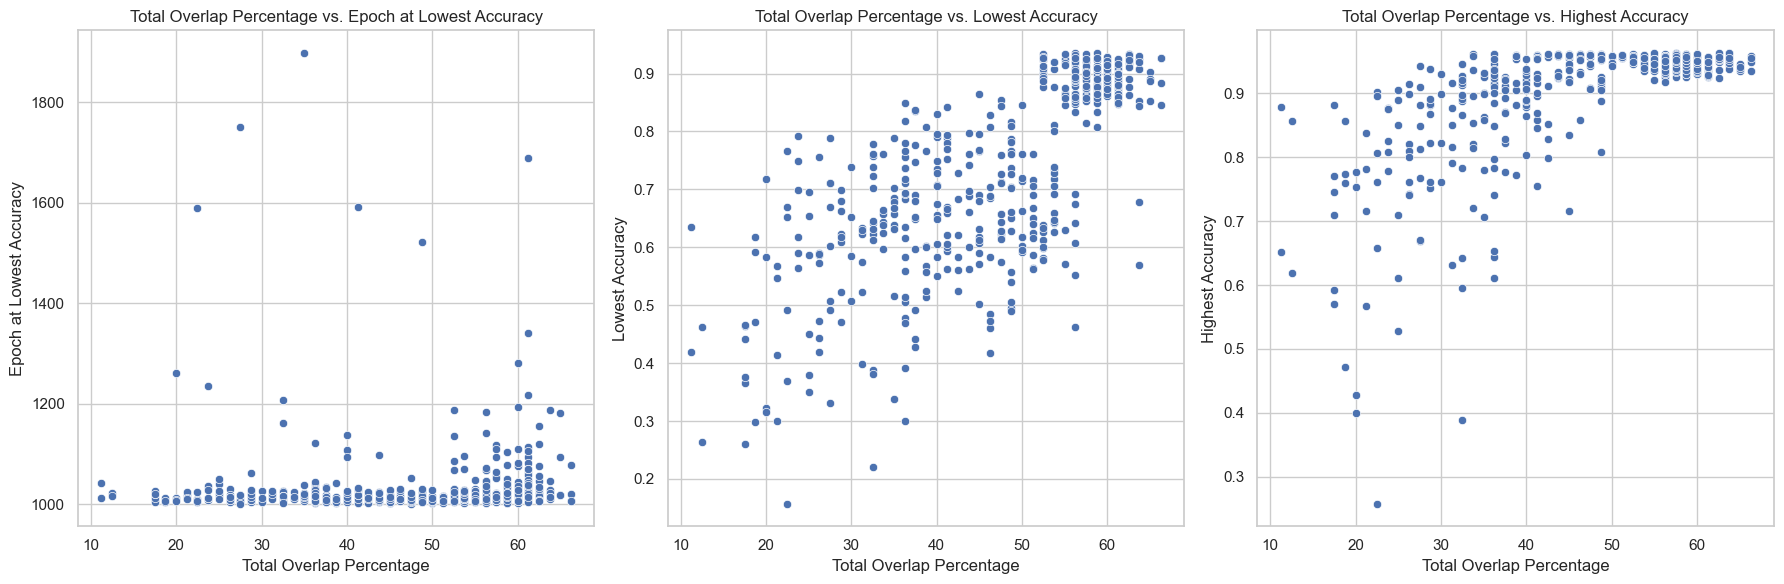

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_34_merged is loaded and contains the required columns
# Setup the plotting environment
sns.set(style="whitegrid")

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot: Total_Overlap_Percentage vs Epoch at Lowest Accuracy
sns.scatterplot(x='Total_Overlapp_percentage', y='Epoch at Lowest Accuracy', data=df_model_accuracies_songs_34_merged, ax=axs[0])
axs[0].set_title('Total Overlap Percentage vs. Epoch at Lowest Accuracy')
axs[0].set_xlabel('Total Overlap Percentage')
axs[0].set_ylabel('Epoch at Lowest Accuracy')

# Scatter plot: Total_Overlap_Percentage vs Lowest Accuracy
sns.scatterplot(x='Total_Overlapp_percentage', y='Lowest Accuracy', data=df_model_accuracies_songs_34_merged, ax=axs[1])
axs[1].set_title('Total Overlap Percentage vs. Lowest Accuracy')
axs[1].set_xlabel('Total Overlap Percentage')
axs[1].set_ylabel('Lowest Accuracy')

# Scatter plot: Total_Overlap_Percentage vs Highest Accuracy
sns.scatterplot(x='Total_Overlapp_percentage', y='Highest Accuracy', data=df_model_accuracies_songs_34_merged, ax=axs[2])
axs[2].set_title('Total Overlap Percentage vs. Highest Accuracy')
axs[2].set_xlabel('Total Overlap Percentage')
axs[2].set_ylabel('Highest Accuracy')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


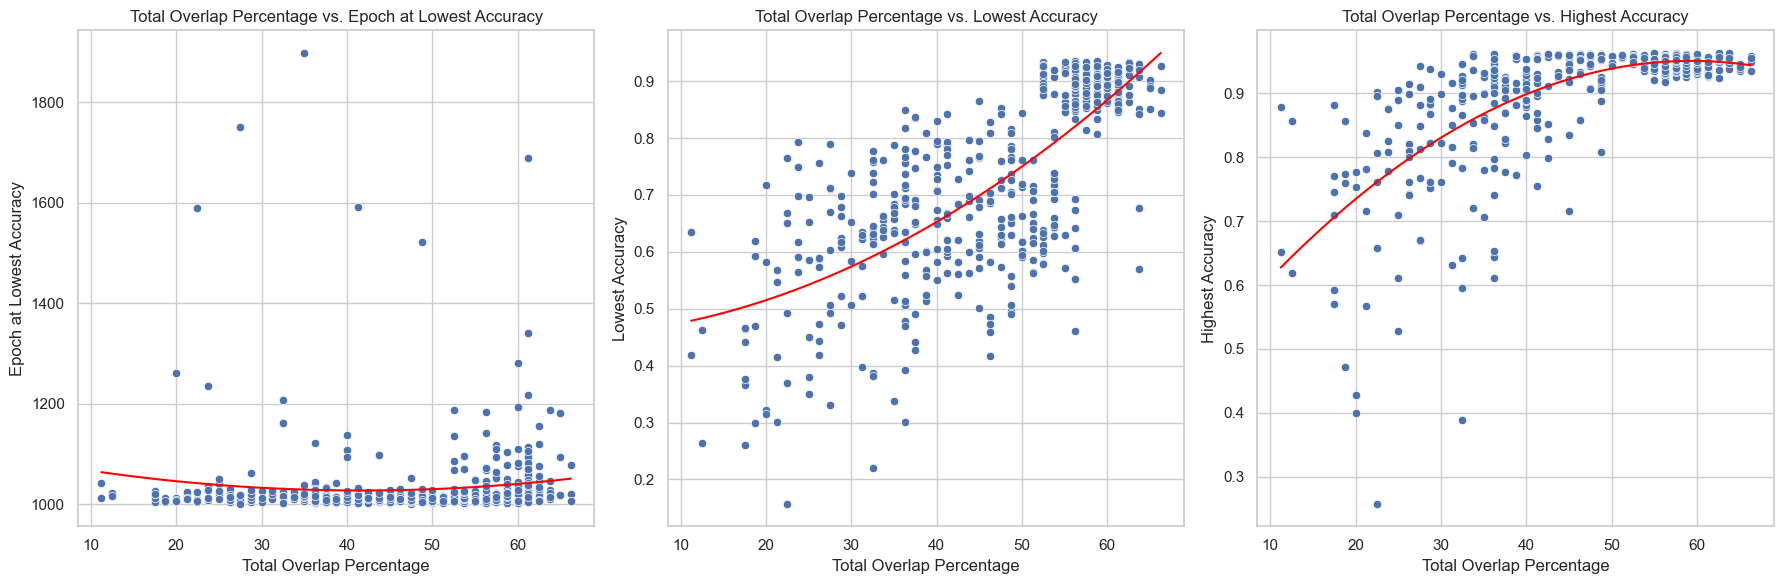

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_model_accuracies_songs_34_merged is already loaded
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define a function to plot polynomial regression
def plot_poly_regression(x, y, ax, degree=2, title="", xlabel="", ylabel=""):
    # Scatter plot
    sns.scatterplot(x=x, y=y, data=df_model_accuracies_songs_34_merged, ax=ax)
    
    # Fit a polynomial regression of specified degree
    coeffs = np.polyfit(df_model_accuracies_songs_34_merged[x], df_model_accuracies_songs_34_merged[y], degree)
    # Generate a polynomial equation based on the coefficients
    poly_eq = np.poly1d(coeffs)
    # Generate x values (from min to max x in 100 steps)
    x_poly = np.linspace(df_model_accuracies_songs_34_merged[x].min(), df_model_accuracies_songs_34_merged[x].max(), 100)
    # Generate y values from the polynomial equation
    y_poly = poly_eq(x_poly)
    # Plot the regression line
    ax.plot(x_poly, y_poly, color='red')
    
    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Plot 1: Total_Overlap_Percentage vs Epoch at Lowest Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Epoch at Lowest Accuracy', axs[0], 
                     title='Total Overlap Percentage vs. Epoch at Lowest Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Epoch at Lowest Accuracy')

# Plot 2: Total_Overlap_Percentage vs Lowest Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Lowest Accuracy', axs[1], 
                     title='Total Overlap Percentage vs. Lowest Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Lowest Accuracy')

# Plot 3: Total_Overlap_Percentage vs Highest Accuracy
plot_poly_regression('Total_Overlapp_percentage', 'Highest Accuracy', axs[2], 
                     title='Total Overlap Percentage vs. Highest Accuracy',
                     xlabel='Total Overlap Percentage', ylabel='Highest Accuracy')

plt.tight_layout()
plt.show()
